<h1><center>Presidential Election Results Prediction Based on Sentiment Analysis</center></h1>

In [479]:
# jupyter settings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Working Libraries
import sqlite3
import pandas as pd
import contractions
from gensim.parsing.preprocessing import (remove_stopwords, strip_numeric, strip_punctuation)
import re
import numpy as np
import nltk
from nltk.tokenize import TweetTokenizer

# For visualizing 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from wordcloud import WordCloud

# libraries needed for all models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from scipy import sparse
from scipy.sparse import csc_matrix

# Libraries needed for Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB

# Libraries needed for Support Vector Machine (SVM)
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import model_selection, svm
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
import time

# libraries needed for RandomForest Model
from sklearn.ensemble import RandomForestClassifier

# Data

## Loading Datasets

Our data was stored in a SQLIte database. So the first step was to load the dataset from the database. The datasets were stored separately at first.

To load all the files into dataframes, a connection to a SQLite database file called Nigerian_Election_2023.sqlite has to be established, and a dictionary of Pandas DataFrames created. The dictionary keys being the names of the tables in the database, and the values being the corresponding DataFrames.

In [480]:
# Connect to the SQLite database file
conn = sqlite3.connect('Nigerian_Election_2023.sqlite')

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Retrieve the list of table names in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
tables = cursor.fetchall()

# Create a dictionary to store the dataframes
dataframes = {}

# Process each table (dataframe) individually
for table in tables:
    table_name = table[0]
    print("Dataframe:", table_name)

    # Execute a query to read data from the current table (dataframe)
    cursor.execute(f"SELECT * FROM {table_name}")

    # Fetch all the rows from the query result
    rows = cursor.fetchall()

    # Get the column names from the cursor description
    column_names = [desc[0] for desc in cursor.description]

    # Create a Pandas DataFrame from the query result with column names
    df = pd.DataFrame(rows, columns=column_names)

    # Assign the dataframe to the corresponding key in the dictionary
    dataframes[table_name.lower()] = df

# Access the dataframes using the variable names
APC = dataframes['apc']
Atiku = dataframes['atiku']
Kwankwaso = dataframes['kwankwaso']
LabourParty = dataframes['labourparty']
PDP = dataframes['pdp']
PeterObi = dataframes['peterobi']
Tinubu = dataframes['tinubu']

# Close the cursor and the connection
cursor.close()
conn.close()

Dataframe: APC
Dataframe: Atiku
Dataframe: Kwankwaso
Dataframe: LabourParty
Dataframe: PDP
Dataframe: PeterObi
Dataframe: Tinubu


## Combining Similar Datasets

Table I: Table showing Presidential candidates and their political parties

| Presidential Candidate | Political Party                          |
|------------------------|------------------------------------------|
| Atiku Abubakar         | People’s Democratic Party (PDP)           |
| Bola Ahmed Tinubu      | All Progressives Congress (APC)           |
| Peter Obi              | Labor Party (LP)                          |
| Rabiu Kwankwaso        | New Nigeria Peoples Party (NNPP)          |


The tweets about each of the presidential candidate above and tweets about their political party were combined for the analysis. 

In [481]:
# Concatenate the dataframes along the rows
# Atiku Abubaka and People’s Democratic Party (PDP)
atiku_pdp = pd.concat([Atiku, PDP]) 

# Bola Ahmed Tinubu and All Progressives Congress (APC)
tinubu_apc = pd.concat([Tinubu, APC]) 

# Peter Obi, and Labor Party (LP)
peterobi_lp = pd.concat([PeterObi, LabourParty]) 

# Rabiu Kwankwaso
kwankwaso = Kwankwaso.copy() 

## Preprocessing Datasets

All the datasets have similar columns. Therefore, it would be very difficult to separate the dataframes if you decided to combine them without adding a unique identifier for each of them. A column, therefore, was added to each of the dataset that indicated the dataframe name. And because the dataframes were names after the candidates and their parties, that would make it easier to access each adataframe individually through filtering.

### Adding a Candidate Name in Each Dataframe 

A function called add_candidate_column was defined that adds a new column called 'candidate' to a given dataframe. The purpose is to associate a specific candidate name with each row of the dataframe. The function takes two arguments: dataframe, which is the input dataframe to be modified, and candidate_name, which is the name of the candidate to be written in the 'candidate' column.

The function implementation is straightforward. It adds a new column called 'candidate' to the input dataframe by assigning the same candidate_name value to all rows. This ensures that the 'candidate' column contains the specified candidate name for all rows.

The function returns the modified dataframe with the added 'candidate' column. This allows the user to assign the returned dataframe to a variable for further use or analysis.

In [482]:
def add_candidate_column(dataframe, candidate_name):
    """
    Adds a 'candidate' column to the dataframe with the specified candidate name for all rows.

    Args:
        dataframe (pd.DataFrame): Input dataframe to which the 'candidate' column will be added.
        candidate_name (str): Name of the candidate to be written in the 'candidate' column.

    Returns:
        pd.DataFrame: The modified dataframe with the 'candidate' column added.
    """
    dataframe['candidate'] = candidate_name
    return dataframe

# Calling the function on each of the dataframes
atiku_pdp = add_candidate_column(atiku_pdp, 'Atiku')  # Atiku Abubaka & People’s Democratic Party (PDP)
tinubu_apc = add_candidate_column(tinubu_apc, 'Tinubu') # Bola Tinubu & All Progressives Congress (APC)
peterobi_lp = add_candidate_column(peterobi_lp, 'PeterObi') # Peter Obi, and Labor Party (LP) 
kwankwaso = add_candidate_column(kwankwaso, 'Kwankwaso') # Rabiu Kwankwaso

### Concatenating Dataframes

The multiple dataframes were merged into a single dataframe, combined_df. This concatenation operation merges the data from these individual dataframes, allowing for a consolidated dataset for further analysis.

To achieve this, the pd.concat() function from the pandas library is utilized. The resulting concatenated dataframe, combined_df, is assigned as the merged dataset. To ensure a continuous and sequential index for the merged dataframe, the reset_index() method is applied with the drop=True parameter. This operation resets the index of the combined_df dataframe, discarding the original indices from the individual dataframes.

In [483]:
# Concatenate the dataframes along the rows
combined_df = pd.concat([atiku_pdp, tinubu_apc, peterobi_lp, kwankwaso])

# Shuffle the data
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Reset the index of the resulting dataframe
combined_df = combined_df.reset_index(drop=True)

# overview of the data
combined_df.head(3)

,tweet_id,Text,created_at,author_id,retweet_count,reply_count,like_count,quote_count,impression,tweet_url,candidate
0,1615855621521252357,Atiku and Tinubu should face the issues https:...,2023-01-18 23:36:15+00:00,239378208,0,0,0,0,3.0,https://twitter.com/cooldejay/status/161585562...,Atiku
1,1612582468510519299,2023 Presidency: Reactions As Picture Of Atiku...,2023-01-09 22:49:55+00:00,221031131_732,0,0,0,0,43.0,https://twitter.com/wolecypher/status/16125824...,Atiku
2,1618731406804533249,@jiddah_mk You know what are you doing that’s ...,2023-01-26 22:03:36+00:00,1475480568745713664,0,0,2,0,65.0,https://twitter.com/Ibrahim14Ibrah/status/1618...,Kwankwaso


## Data Cleansing

This section is for the purposes of cleaning and preprocessing the dataframe, specifically the dataframe contains textual data, that is being targetted. The intention is to apply a series of transformations and cleaning operations to prepare the data for further analysis or modeling.

The following steps are taken:

* dropping duplicates, 
* expanding contractions, 
* removing stopwords, 
* stripping numeric values, 
* stripping punctuation, 
* removing extra spaces, and 
* removing greetings and other unimportant words. It also converts all text to lowercase.

### Dropping Unnecessary Columns

The line combined_df = combined_df.drop([], axis=1) drops all the columns from the combined_df dataframe that are considered unnecessary for the analysis; the columns that won't be used at all.

In [484]:
# Dropping unneccessary Columns
combined_df = combined_df.drop(['author_id', 'retweet_count', 'reply_count', 'like_count', 
                                'quote_count', 'impression', 'tweet_url'], axis=1)

combined_df.head(5)

,tweet_id,Text,created_at,candidate
0,1615855621521252357,Atiku and Tinubu should face the issues https:...,2023-01-18 23:36:15+00:00,Atiku
1,1612582468510519299,2023 Presidency: Reactions As Picture Of Atiku...,2023-01-09 22:49:55+00:00,Atiku
2,1618731406804533249,@jiddah_mk You know what are you doing that’s ...,2023-01-26 22:03:36+00:00,Kwankwaso
3,1628535780720185345,You mean all the youth will vote Labour Party ...,2023-02-22 23:22:41+00:00,PeterObi
4,1623456755207540736,"@DanielRegha Obidients, play stay off any trib...",2023-02-08 23:00:27+00:00,Tinubu


### Dropping Duplicates

The code checks for and drops any duplicate rows based on the 'Text' column. It prints the length of the dataframe before and after dropping duplicates using the drop_duplicates() method.

In [485]:
print('Before dropping duplicates:', len(combined_df)) # shape of the data before dropping duplicates
combined_df.drop_duplicates(subset = "Text", inplace = True) # # Dropping duplicates 
combined_df.drop_duplicates(subset = "tweet_id", inplace = True) # # Dropping duplicates 
print('After dropping duplicates:', len(combined_df)) # shape of the data after dropping duplicates

Before dropping duplicates: 157700
After dropping duplicates: 140827


### Expanding Contractions

The function expand_contractions expands contractions in the 'Text' column of the combined_df dataframe using the contractions.fix() function from the contractions library.

In [486]:
# define function to expand contractions
def expand_contractions(text):
    expanded_words = []
    for word in text.split():
        expanded_words.append(contractions.fix(word))
    return ' '.join(expanded_words)

combined_df['clean_Text'] = combined_df['Text'].apply(expand_contractions)

# overview of the data
combined_df.head(5)

,tweet_id,Text,created_at,candidate,clean_Text
0,1615855621521252357,Atiku and Tinubu should face the issues https:...,2023-01-18 23:36:15+00:00,Atiku,Atiku and Tinubu should face the issues https:...
1,1612582468510519299,2023 Presidency: Reactions As Picture Of Atiku...,2023-01-09 22:49:55+00:00,Atiku,2023 Presidency: Reactions As Picture Of Atiku...
2,1618731406804533249,@jiddah_mk You know what are you doing that’s ...,2023-01-26 22:03:36+00:00,Kwankwaso,@jiddah_mk You know what are you doing that is...
3,1628535780720185345,You mean all the youth will vote Labour Party ...,2023-02-22 23:22:41+00:00,PeterObi,You mean all the youth will vote Labour Party ...
4,1623456755207540736,"@DanielRegha Obidients, play stay off any trib...",2023-02-08 23:00:27+00:00,Tinubu,"@DanielRegha Obidients, play stay off any trib..."


### Removing Stopwords

The remove_stopwords function is applied to the 'clean_Text' column of the combined_df dataframe to remove common stopwords.

In [487]:
# Remove Stopwords
combined_df.clean_Text = combined_df.clean_Text.apply(remove_stopwords)

# overview of the data
combined_df.head(5)

,tweet_id,Text,created_at,candidate,clean_Text
0,1615855621521252357,Atiku and Tinubu should face the issues https:...,2023-01-18 23:36:15+00:00,Atiku,Atiku Tinubu face issues https://t.co/zLWu21bSVE
1,1612582468510519299,2023 Presidency: Reactions As Picture Of Atiku...,2023-01-09 22:49:55+00:00,Atiku,2023 Presidency: Reactions As Picture Of Atiku...
2,1618731406804533249,@jiddah_mk You know what are you doing that’s ...,2023-01-26 22:03:36+00:00,Kwankwaso,@jiddah_mk You know vote kwankwaso almighty al...
3,1628535780720185345,You mean all the youth will vote Labour Party ...,2023-02-22 23:22:41+00:00,PeterObi,You mean youth vote Labour Party ??? 😂😂😂😂.Be r...
4,1623456755207540736,"@DanielRegha Obidients, play stay off any trib...",2023-02-08 23:00:27+00:00,Tinubu,"@DanielRegha Obidients, play stay tribal-relat..."


### Removing Mentions

The clean_text function uses regular expressions to perform text cleaning operations, such as removing mentions, URLs, and hashtags. It converts the text to lowercase.

In [488]:
# Clean text 
def clean_text(text):
    text = re.sub(r'@[A-Z_a-z_0-9_]+', '', text)    
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r'#', '', text)     
    text = text.lower()
    return text

# calling the function
combined_df['clean_Text'] = combined_df['clean_Text'].apply(clean_text)

# overview of the data
combined_df.head(5)

,tweet_id,Text,created_at,candidate,clean_Text
0,1615855621521252357,Atiku and Tinubu should face the issues https:...,2023-01-18 23:36:15+00:00,Atiku,atiku tinubu face issues
1,1612582468510519299,2023 Presidency: Reactions As Picture Of Atiku...,2023-01-09 22:49:55+00:00,Atiku,2023 presidency: reactions as picture of atiku...
2,1618731406804533249,@jiddah_mk You know what are you doing that’s ...,2023-01-26 22:03:36+00:00,Kwankwaso,you know vote kwankwaso almighty allah bless
3,1628535780720185345,You mean all the youth will vote Labour Party ...,2023-02-22 23:22:41+00:00,PeterObi,you mean youth vote labour party ??? 😂😂😂😂.be r...
4,1623456755207540736,"@DanielRegha Obidients, play stay off any trib...",2023-02-08 23:00:27+00:00,Tinubu,"obidients, play stay tribal-related tweet!!! ..."


### Removing Numbers, Punctuation, and Extra Spaces

Several functions (strip_numeric, strip_punctuation, and remove_extra_spaces) are applied to the 'clean_Text' column of the combined_df dataframe to remove numbers, punctuation, and extra spaces.

In [489]:
# Remove numbers
combined_df.clean_Text = combined_df.clean_Text.apply(strip_numeric)

# Remove Punctuation
combined_df.clean_Text = combined_df.clean_Text.apply(strip_punctuation)

#Remove Exra Spaces
def remove_extra_spaces(text):
    # replace multiple spaces with a single space
    text = " ".join(text.split())
    return text

# calling the function
combined_df['clean_Text'] = combined_df['clean_Text'].apply(remove_extra_spaces)

# overview of the data
combined_df.head(5)

,tweet_id,Text,created_at,candidate,clean_Text
0,1615855621521252357,Atiku and Tinubu should face the issues https:...,2023-01-18 23:36:15+00:00,Atiku,atiku tinubu face issues
1,1612582468510519299,2023 Presidency: Reactions As Picture Of Atiku...,2023-01-09 22:49:55+00:00,Atiku,presidency reactions as picture of atiku arriv...
2,1618731406804533249,@jiddah_mk You know what are you doing that’s ...,2023-01-26 22:03:36+00:00,Kwankwaso,you know vote kwankwaso almighty allah bless
3,1628535780720185345,You mean all the youth will vote Labour Party ...,2023-02-22 23:22:41+00:00,PeterObi,you mean youth vote labour party 😂😂😂😂 be reali...
4,1623456755207540736,"@DanielRegha Obidients, play stay off any trib...",2023-02-08 23:00:27+00:00,Tinubu,obidients play stay tribal related tweet it tr...


### Removing Unimportant Words

The remove_words function removes specified words from the 'clean_Text' column of the combined_df dataframe, based on the list of words provided.

In [490]:
# Listing greetings and unimportant words 
words_to_remove = ['hello', 'hi', 'abeg', 'oga', 'go', 'brother', 'bro', 'dey', 'o']


def remove_words(df, column_name, words_to_remove):
    """
    Remove specified words from a column of a pandas DataFrame.
    """
    words = df[column_name].str.lower().str.split() # Convert to lowercase and split into words
    words = words.apply(lambda x: [word for word in x if word not in words_to_remove])
    cleaned_column = words.str.join(' ') # Combine words back into strings
    df[column_name] = cleaned_column # Replace original column with cleaned column in DataFrame
    return df

# calling the function
combined_df = remove_words(combined_df, 'clean_Text', words_to_remove)

# overview of the dataframe
combined_df.head(5)

,tweet_id,Text,created_at,candidate,clean_Text
0,1615855621521252357,Atiku and Tinubu should face the issues https:...,2023-01-18 23:36:15+00:00,Atiku,atiku tinubu face issues
1,1612582468510519299,2023 Presidency: Reactions As Picture Of Atiku...,2023-01-09 22:49:55+00:00,Atiku,presidency reactions as picture of atiku arriv...
2,1618731406804533249,@jiddah_mk You know what are you doing that’s ...,2023-01-26 22:03:36+00:00,Kwankwaso,you know vote kwankwaso almighty allah bless
3,1628535780720185345,You mean all the youth will vote Labour Party ...,2023-02-22 23:22:41+00:00,PeterObi,you mean youth vote labour party 😂😂😂😂 be reali...
4,1623456755207540736,"@DanielRegha Obidients, play stay off any trib...",2023-02-08 23:00:27+00:00,Tinubu,obidients play stay tribal related tweet it tr...


### Word Count Filtering

The code creates a new column called 'Word_Count' in the combined_df dataframe, which counts the number of words in each row of the 'Text' column. It filters out rows where the word count is less than or equal to 3.

In [491]:
# Create a new column with the number of words in the "Text" column
combined_df['Word_Count'] = combined_df['Text'].apply(lambda x: len(str(x).split()))
combined_df = combined_df[combined_df['Word_Count'] > 3 ]
print('After thorough cleaning:', len(combined_df))

After thorough cleaning: 139994


# Sentiment Analysis

Sentiment analysis, also known as opinion mining, is a valuable technique used to extract subjective information from text and determine the sentiment or emotional tone of the text. The availability of labeled datasets is crucial for training machine learning models to perform sentiment analysis effectively. 

However, manually labeling a large dataset can be time-consuming and resource-intensive. In this report, we propose an alternative approach using NLTK's sentiment analyzer and TextBlob to automatically label the dataset, thus facilitating the creation of a sentiment analysis model.

## Labelling Dataset

We splitted our data into two parts, one that was labelled to help in training and testing our sentiment model, and one for predicting using our created model. Since a better model should always be trained on a large dataset, we decided to split data by about 50% for training and testing, and 50% for predicting using our created model.

### Advantages of Automatic Labeling:

It significantly reduces the manual effort and time required to label a large dataset. Manually labeling each text entry in a dataset can be a laborious and time-consuming task. 

Second, NLTK's sentiment analyzer and TextBlob have been extensively used and evaluated in sentiment analysis research. They have been trained on large and diverse datasets, allowing them to capture a wide range of sentiment patterns. 

### Disadvantage of Automatic Labbeling

It is important to note that automatic labeling does have limitations. The sentiment labels generated by NLTK's sentiment analyzer and TextBlob may not always perfectly reflect the true sentiment of a text. These tools are trained on general language patterns and might not handle specific domains, slang, or sarcasm accurately.

### Labelling Data and Deploying Data

#### Removing Unnecessary Columns

The columns 'tweet_id', 'Text', and 'Word_Count' are dropped from the combined_df DataFrame using the drop function. 

#### Splitting the Data for Labeling:

The data is split into two separate DataFrames: labelling_df and deploying_df. The first 69,997 records from the combined_df DataFrame are assigned to the labelling_df, which will be used for labeling the sentiment of the corresponding texts.

Separating Data for Deployment:

The remaining records after the first 69,997 are assigned to the deploying_df. This portion of the data will be used for deploying and evaluating the trained sentiment analysis model.

In [492]:
# remove the unneccessary columns
combined_df = combined_df.drop(['tweet_id', 'Text', 'Word_Count'], axis=1)

# splitting the data for labbelling
labelling_df = combined_df[:69997]

# data for deploying
deploying_df = combined_df[69997:]

print("Labelling data", labelling_df.shape)
print("Deploying data", deploying_df.shape)
print('')

# overview of data
labelling_df.head(5)

Labelling data (69997, 3)
Deploying data (69997, 3)



,created_at,candidate,clean_Text
0,2023-01-18 23:36:15+00:00,Atiku,atiku tinubu face issues
1,2023-01-09 22:49:55+00:00,Atiku,presidency reactions as picture of atiku arriv...
2,2023-01-26 22:03:36+00:00,Kwankwaso,you know vote kwankwaso almighty allah bless
3,2023-02-22 23:22:41+00:00,PeterObi,you mean youth vote labour party 😂😂😂😂 be reali...
4,2023-02-08 23:00:27+00:00,Tinubu,obidients play stay tribal related tweet it tr...


# Labelling the labelling_df Dataset (VADER)

In [493]:
# Import the VADER library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
VADER = SentimentIntensityAnalyzer()

# function to add sentiment
def add_vader_sentiment(df, text_column):
    """
    Adds sentiment labels to a DataFrame based on the text in a specified column using VADER sentiment analysis.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to which the sentiment labels will be added.
    - text_column (str): The name of the column containing the text data.

    Returns:
    - df (pandas.DataFrame): The modified DataFrame with an additional column 'VADER_Sentiments' containing VADER sentiment labels.

    Description:
    The 'add_sentiment' function takes a DataFrame and a text column as input and adds a new column 'VADER_Sentiments'
    to the DataFrame. The sentiment labels in the 'VADER_Sentiments' column are determined based on the text in the specified column
    using VADER sentiment analysis.

    VADER sentiment analysis assigns sentiment scores to the text, including positive, negative, and neutral scores.
    The function uses the compound score provided by VADER for determining the sentiment labels.

    The updated sentiment labeling is as follows:
    - Positive sentiment: compound score >= 0.05
    - Neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
    - Negative sentiment: compound score <= -0.05

    The function applies the modified sentiment labeling logic to the text in the specified column of the DataFrame,
    and adds the corresponding sentiment labels to the 'VADER_Sentiments' column.

    """
    # Add sentiment labels based on text analysis
    df.loc[:, 'VADER_Sentiments'] = df[text_column].apply(lambda x: 'Positive' if VADER.polarity_scores(x)
                                                          ['compound'] >= 0.05 else 
                                                          ('Negative' if VADER.polarity_scores(x)
                                                           ['compound'] <= -0.05 else 'Neutral'))

    return df


# Call the function to add Sentiment labels
labelling_df = add_vader_sentiment(labelling_df, 'clean_Text')

# overview of the data
labelling_df.head(5)

,created_at,candidate,clean_Text,VADER_Sentiments
0,2023-01-18 23:36:15+00:00,Atiku,atiku tinubu face issues,Neutral
1,2023-01-09 22:49:55+00:00,Atiku,presidency reactions as picture of atiku arriv...,Neutral
2,2023-01-26 22:03:36+00:00,Kwankwaso,you know vote kwankwaso almighty allah bless,Positive
3,2023-02-22 23:22:41+00:00,PeterObi,you mean youth vote labour party 😂😂😂😂 be reali...,Positive
4,2023-02-08 23:00:27+00:00,Tinubu,obidients play stay tribal related tweet it tr...,Negative


## Labelling TextBlob Sentiment Analyzer

In [494]:
# additional libraries
from textblob import TextBlob

# function to add sentiment using textblob
def add_textblob_sentiment(df, text_column):
    """
    Adds TextBlob sentiment labels to a DataFrame based on the text in a specified column.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to which the sentiment labels will be added.
    - text_column (str): The name of the column containing the text data.

    Returns:
    - df (pandas.DataFrame): The modified DataFrame with an additional column 'TextBlob_Sentiments' 
    containing TextBlob sentiment labels.

    Description:
    The 'add_textblob_sentiment' function takes a DataFrame and a text column as input and adds a new 
    column 'TextBlob_Sentiments' to the DataFrame. The sentiment labels in the 'TextBlob_Sentiments' 
    column are determined based on the text in the specified column using TextBlob sentiment analysis.

    TextBlob sentiment analysis calculates the polarity of the text, which represents the sentiment on a 
    scale from -1 to 1. Negative values indicate negative sentiment, positive values indicate positive 
    sentiment, and 0 indicates neutral sentiment.

    The function first defines a helper function 'getPolarity' that uses TextBlob to get the polarity 
    score for each text.
    It then applies this function to the 'tweet' column of the DataFrame to calculate the polarity scores.

    Next, another helper function 'add_textblob_sentiment' is defined to convert the polarity scores into 
    sentiment labels.
    Scores below 0 are labeled as 'Negative', scores equal to 0 are labeled as 'Neutral', and scores 
    above 0 are labeled as 'Positive'.
    This function is applied to the 'TextBlob_Sentiments' column to convert the polarity scores into 
    sentiment labels.
    """
    
    # Calculate polarity scores
    df['TextBlob_Sentiments'] = df[text_column].apply(lambda x: TextBlob(x).sentiment.polarity)

    # Convert polarity scores to sentiment labels
    def add_textblob_sentiment(score):
        if score < 0:
            return 'Negative'
        elif score == 0:
            return 'Neutral'
        else:
            return 'Positive'

    df['TextBlob_Sentiments'] = df['TextBlob_Sentiments'].apply(add_textblob_sentiment)

    return df

# Call the function to add Sentiment labels
labelling_df = add_textblob_sentiment(labelling_df, 'clean_Text')

# overview of the data
labelling_df.head(5)

,created_at,candidate,clean_Text,VADER_Sentiments,TextBlob_Sentiments
0,2023-01-18 23:36:15+00:00,Atiku,atiku tinubu face issues,Neutral,Neutral
1,2023-01-09 22:49:55+00:00,Atiku,presidency reactions as picture of atiku arriv...,Neutral,Neutral
2,2023-01-26 22:03:36+00:00,Kwankwaso,you know vote kwankwaso almighty allah bless,Positive,Neutral
3,2023-02-22 23:22:41+00:00,PeterObi,you mean youth vote labour party 😂😂😂😂 be reali...,Positive,Negative
4,2023-02-08 23:00:27+00:00,Tinubu,obidients play stay tribal related tweet it tr...,Negative,Neutral


# Visualizing Results From Labelled Dataset

## Bar Plot

In [495]:
def plot_sentiment_analysis(df, sentiment_column, library):
    """
    Generates a bar plot of sentiment analysis results based on a specified sentiment column in a 
    DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the sentiment analysis results.
    - sentiment_column (str): The name of the column containing the sentiment labels.
    - library (str): The name of the sentiment analysis library used (e.g., 'VADER', 'TextBlob').

    Description:
    The 'plot_sentiment_analysis' function takes a DataFrame, a sentiment column, and the sentiment 
    analysis
    library used as input and generates a bar plot representing the sentiment analysis results. 
    The plot shows the count of each sentiment category in the column.

    The function calculates the count of each sentiment category and creates a vertical bar plot with 
    different colors for each sentiment. The sentiment categories are 'Negative', 'Neutral', and 
    'Positive'.

    The plot appearance is customized with labels, title indicating the sentiment analysis library 
    used, 
    grid lines, total counts on top of each bar, and a legend.
    """
    # Calculate count of sentiments
    counts = df[sentiment_column].value_counts().sort_index().tolist()
    
    # print value counts
    print(df[sentiment_column].value_counts())

    # Define colors for each sentiment
    colors = ['red', 'orange', 'green']

    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Create a vertical bar plot with different colors for each bar and custom width
    bars = ax.bar(['Negative', 'Neutral', 'Positive'], counts, color=colors, width=0.3, align='edge')

    # Customize the plot appearance
    ax.set_xlabel('Sentiments')
    ax.set_ylabel('Counts')
    ax.set_title(f'{library} Sentiment Analysis Results')

    # Add grid lines
    ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.5)

    # Add total number on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

    # Add legend
    ax.legend(bars, ['Negative', 'Neutral', 'Positive'], bbox_to_anchor=(0.22, 1))

    plt.tight_layout()
    
    # Save the plot as PNG file
    fig.savefig(f'sentiment_analysis_{library}.png')
    
    # Show the plot
    plt.show()

### Sentiment Results From VADER

Positive    37880
Negative    19232
Neutral     12885
Name: VADER_Sentiments, dtype: int64


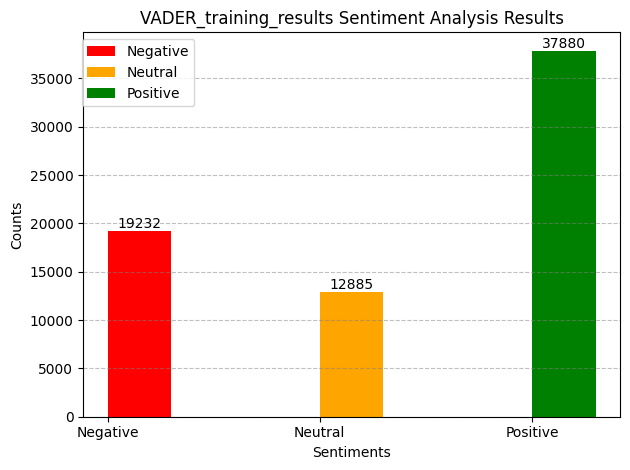

In [496]:
plot_sentiment_analysis(labelling_df, 'VADER_Sentiments', 'VADER_training_results')

### Sentiment Results From TextBlob

Neutral     29575
Positive    26718
Negative    13704
Name: TextBlob_Sentiments, dtype: int64


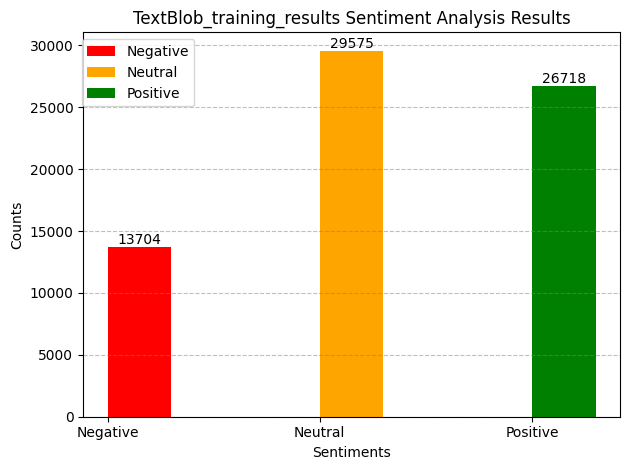

In [497]:
plot_sentiment_analysis(labelling_df, 'TextBlob_Sentiments', 'TextBlob_training_results')

## Pie Chart

In [498]:
def plot_sentiment_distribution(df, sentiment_column, library):
    """
    Generates a pie chart of sentiment distribution based on a specified sentiment column in a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the sentiment data.
    - sentiment_column (str): The name of the column containing the sentiment labels.
    - library (str): The name of the sentiment analysis library used (e.g., 'NLTK', 'TextBlob').

    Description:
    The 'plot_sentiment_distribution' function takes a DataFrame, a sentiment column, and the sentiment 
    analysis library used as input and generates a pie chart representing the sentiment distribution. 
    The chart displays the proportion of each sentiment category in the column.

    The function calculates the count of each sentiment category and creates a pie chart using Matplotlib 
    with labeled wedges indicating the sentiment category and the corresponding percentage.

    The chart title indicates the sentiment analysis library used.
    """
    # Count the number of occurrences of each sentiment value
    sentiment_counts = df[sentiment_column].value_counts()

    # Create a pie chart using Matplotlib
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')

    # Set the plot title
    plt.title(f'Sentiment Distribution ({library})')

    # Display the plot
    plt.show()

### Sentiment Results From VADER

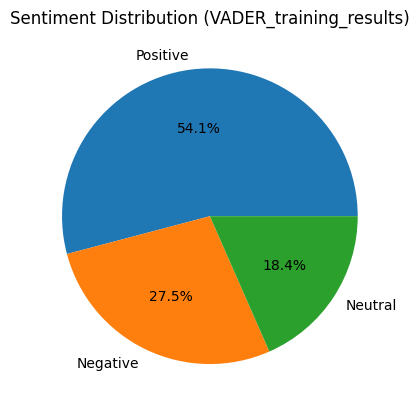

In [499]:
plot_sentiment_distribution(labelling_df, 'VADER_Sentiments', 'VADER_training_results')

### Sentiment Results From TextBlob

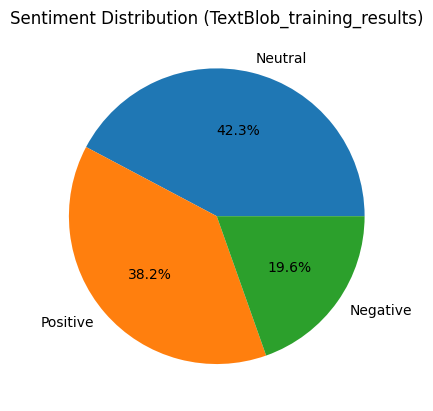

In [500]:
plot_sentiment_distribution(labelling_df, 'TextBlob_Sentiments', 'TextBlob_training_results')

### Sentiment Results From VADER

Based on the sentiment analysis results using VADER for presidential candidates' tweets from Nigerian people during the Nigerian elections, here is a breakdown of the sentiment distribution:

* Positive: 37,880
* Negative: 19,232
* Neutral: 12,885

### Sentiment Results From TextBlob

Based on the sentiment analysis results using TextBlob for presidential candidates' tweets from Nigerian people during the Nigerian elections, here is a breakdown of the sentiment distribution:

* Neutral: 29,575
* Positive: 26,718
* Negative: 13,704

# Machine Learning Models for Sentiment Analysis

Supervised machine learning algorithms such as Naive Bayes, Support Vector Machine (SVM), and Random Forest were used to classify the sentiment of the collected data. 

## Selecting Only Positive and Negative Sentiments

### Positive and Negative Data from VADER

In [314]:
# selecting only the data with positive and negative sentiments
vader_labelling_df = labelling_df[labelling_df['VADER_Sentiments'] != 'Neutral']

# drop the textblob sentiment column
vader_labelling_df.drop(['TextBlob_Sentiments'], axis=1, inplace=True)

# print shape of the data
print(vader_labelling_df.shape)

# overview of the vader positive and negative data
vader_labelling_df.head(5)

(57112, 4)


,created_at,candidate,clean_Text,VADER_Sentiments
2,2023-01-26 22:03:36+00:00,Kwankwaso,you know vote kwankwaso almighty allah bless,Positive
3,2023-02-22 23:22:41+00:00,PeterObi,you mean youth vote labour party 😂😂😂😂 be reali...,Positive
4,2023-02-08 23:00:27+00:00,Tinubu,obidients play stay tribal related tweet it tr...,Negative
6,2023-01-07 22:20:52+00:00,Atiku,watch pdp lose landslide february it party ind...,Positive
8,2023-01-19 22:48:53+00:00,PeterObi,obi labour party,Positive


### Positive and Negative Data from TextBlob

In [315]:
# selecting only the data with positive and negative sentiments
textblob_labelling_df = labelling_df[labelling_df['TextBlob_Sentiments'] != 'Neutral']

# drop the textblob sentiment column
textblob_labelling_df.drop(['VADER_Sentiments'], axis=1, inplace=True)

# print shape of the data
print(textblob_labelling_df.shape)

# overview of the vader positive and negative data
textblob_labelling_df.head(5)

(40422, 4)


,created_at,candidate,clean_Text,TextBlob_Sentiments
3,2023-02-22 23:22:41+00:00,PeterObi,you mean youth vote labour party 😂😂😂😂 be reali...,Negative
6,2023-01-07 22:20:52+00:00,Atiku,watch pdp lose landslide february it party ind...,Positive
12,2022-12-23 10:38:23+00:00,Kwankwaso,please ooo i hear frm kwankwaso far na abi ret...,Positive
13,2023-01-02 22:24:16+00:00,Atiku,add pdp folks list like look mirror tweeting o...,Negative
17,2023-02-09 17:14:00+00:00,Kwankwaso,i owe lot more i wonder i appreciation wins ye...,Positive


## Naive Bayes

Naive Bayes is a popular classification algorithm in machine learning, particularly suited for text classification tasks. It is based on the principles of Bayes' theorem and assumes independence among the features. 

### Naive Bayes Model Preparations

#### Transforming Text Data

The CountVectorizer from scikit-learn was used to transform text data into a matrix of token counts. 

In [316]:
def tokenize_and_count(df, text_column, ngram_range=(1, 1)):
    """
    Tokenizes the text data in a specified column of a DataFrame and returns the token counts.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the text data.
    - text_column (str): The name of the column containing the text data.
    - ngram_range (tuple, optional): The range of n-grams to consider for tokenization. Default is (1, 1).


    Returns:
    - text_counts (scipy.sparse.csr_matrix): The matrix of token counts.

    Description:
    The 'tokenize_and_count' function takes a DataFrame and the name of a text column as input and 
    performs tokenization on the text data in that column. It uses a regular expression pattern to tokenize
    the text into alphanumeric sequences.

    The function creates a CountVectorizer object with a customized tokenizer and specified parameters 
    such as stop words removal and n-gram range. It then fits the CountVectorizer on the text data, 
    transforming it into a matrix of token counts.

    The resulting matrix of token counts is returned.
    """
    # Define a regular expression pattern for tokenizing
    custom_tokenizer = re.compile(r'[a-zA-Z0-9]+')

    # Create a CountVectorizer object with customized tokenizer and n-gram range
    custom_vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range,
                                        tokenizer=custom_tokenizer.findall)

    # Transform the text data into token counts
    text_counts = custom_vectorizer.fit_transform(df[text_column])

    return text_counts

#### Splitting the Dataset

This is a common step in machine learning known as data splitting, specifically using the train_test_split function from scikit-learn. This process involves dividing a dataset into two separate subsets: one for training a model and the other for evaluating its performance.

In [317]:
def split_data(text_counts, sentiments):
    """
    Splits the data into training and testing sets using the provided text counts and sentiments.

    Parameters:
    - text_counts (scipy.sparse.csr_matrix): The matrix of token counts or features.
    - sentiments (pandas.Series): The series containing the target sentiment labels.

    Returns:
    - X_train (scipy.sparse.csr_matrix): The training data matrix of token counts or features.
    - X_test (scipy.sparse.csr_matrix): The testing data matrix of token counts or features.
    - Y_train (pandas.Series): The training target sentiment labels.
    - Y_test (pandas.Series): The testing target sentiment labels.

    Description:
    The 'split_data' function takes the matrix of token counts or features and the series of target 
    sentiment labels as input and splits the data into training and testing sets. It uses the 
    'train_test_split' function from scikit-learn.

    The training and testing data are split based on the provided 'test_size' parameter (0.25 in this case),
    which determines the proportion of the data to be allocated for testing. The 'random_state' parameter 
    ensures reproducibility of the splits.

    The function returns the training and testing data matrices, as well as the corresponding target 
    sentiment labels.
    """
    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(text_counts, sentiments, test_size=0.25, 
                                                        random_state=5)

    return X_train, X_test, Y_train, Y_test

#### Compiling, Fitting, and Evaluating the base Model

The classifier is created using the MultinomialNB class from scikit-learn's naive_bayes module. The fit method is then called on the classifier object, passing the training data (X_train) and corresponding target sentiment labels (Y_train) as arguments

In [318]:
def train_and_evaluate_model(X_train, Y_train, X_test, Y_test, model_name, naive_bayes_algorithm):
    """
    Trains a Naive Bayes classifier on the provided training data and evaluates its accuracy on the 
    testing data.

    Parameters:
    - X_train (scipy.sparse.csr_matrix): The training data matrix of token counts or features.
    - Y_train (pandas.Series): The training target sentiment labels.
    - X_test (scipy.sparse.csr_matrix): The testing data matrix of token counts or features.
    - Y_test (pandas.Series): The testing target sentiment labels.
    - model_name (str): The name of the sentiment analysis model used.
    - naive_bayes_algorithm (sklearn.naive_bayes.BaseNB): The Naive Bayes algorithm to use.

    Description:
    The 'train_and_evaluate_model' function trains a Naive Bayes classifier on the provided training data 
    and evaluates its accuracy on the testing data. The function takes the training data matrix, target 
    sentiment labels, testing data matrix, and the name of the sentiment analysis model as inputs.

    A Multinomial Naive Bayes classifier is used for sentiment analysis. The model is trained on the 
    training data and then used to predict the sentiment labels of the testing data. The accuracy of the 
    model is calculated by comparing the predicted labels with the true labels.

    The accuracy of the model is printed, indicating the performance of the Naive Bayes model using the 
    specified sentiment analysis model.
    """
    # Create a Naive Bayes classifier using the specified algorithm
    naive_bayes_classifier = naive_bayes_algorithm

    # Train the classifier using the training data
    naive_bayes_classifier.fit(X_train, Y_train)

    # Predict the sentiment labels using the trained model on the testing data
    predicted = naive_bayes_classifier.predict(X_test)

    # Calculate the accuracy score for the predictions
    accuracy_score = metrics.accuracy_score(predicted, Y_test)

    # Print the accuracy of the Naive Bayes model using the specified sentiment analysis model
    print("The accuracy of the Naive Bayes Model Using {}: {}%"
          .format(model_name, '{:04.2f}'.format(accuracy_score*100)))
    
    # Calculate the classification report
    classification_rep = classification_report(Y_test, predicted)
    # Print the classification report
    print()
    print("Classification Report:")
    print(classification_rep)
    
    # Print the confusion matrix
    confusion_matrix = metrics.confusion_matrix(Y_test, predicted)
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    print()
    print()

##### Using Unigrams and Multinomial Naive Bayes

The accuracy of the Naive Bayes Model Using VADER: 82.74%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.69      0.73      4845
    Positive       0.85      0.90      0.87      9433

    accuracy                           0.83     14278
   macro avg       0.81      0.79      0.80     14278
weighted avg       0.82      0.83      0.82     14278



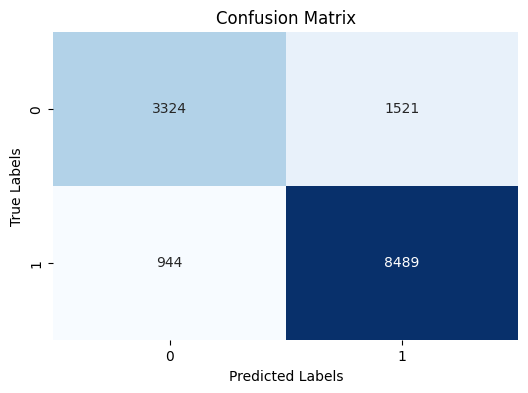



The accuracy of the Naive Bayes Model Using TextBlob: 84.58%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.69      0.75      3434
    Positive       0.85      0.93      0.89      6672

    accuracy                           0.85     10106
   macro avg       0.84      0.81      0.82     10106
weighted avg       0.84      0.85      0.84     10106



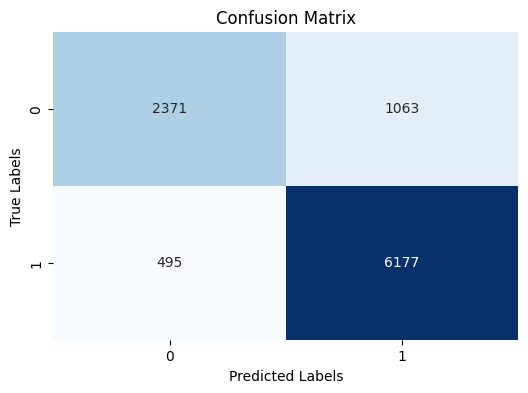

In [319]:
# Choose the Ngrams #################################################################################
# transforming data from Vader
vader_text_counts = tokenize_and_count(vader_labelling_df, 'clean_Text', ngram_range=(1, 1)) 

# transforming data from TextBlob
textblob_text_counts = tokenize_and_count(textblob_labelling_df, 'clean_Text', ngram_range=(1, 1))


# Split the data # Choose the Ngrams #################################################################
# call the function on vader data
X_train_v, X_test_v, Y_train_v, Y_test_v = split_data(vader_text_counts, 
                                                      vader_labelling_df['VADER_Sentiments'])

# call the function on Textblob data
X_train_t, X_test_t, Y_train_t, Y_test_t = split_data(textblob_text_counts, 
                                                      textblob_labelling_df['TextBlob_Sentiments'])


# Choose the Algorithm of Naive Bayes to use ###########################################################
# Train and Evaluate the classifier using the VADER training data using multinomial   
train_and_evaluate_model(X_train_v, Y_train_v, X_test_v, Y_test_v, 'VADER', MultinomialNB())

# Train and Evaluate the classifier using the TextBlob training data using multinomial    
train_and_evaluate_model(X_train_t, Y_train_t, X_test_t, Y_test_t, 'TextBlob', MultinomialNB())

#### Fine-Tuning the Naive Bayes Model

##### Using Bigrams and Multinomial Naive Bayes

The accuracy of the Naive Bayes Model Using VADER: 70.70%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.56      0.63      0.59      4845
    Positive       0.80      0.75      0.77      9433

    accuracy                           0.71     14278
   macro avg       0.68      0.69      0.68     14278
weighted avg       0.72      0.71      0.71     14278



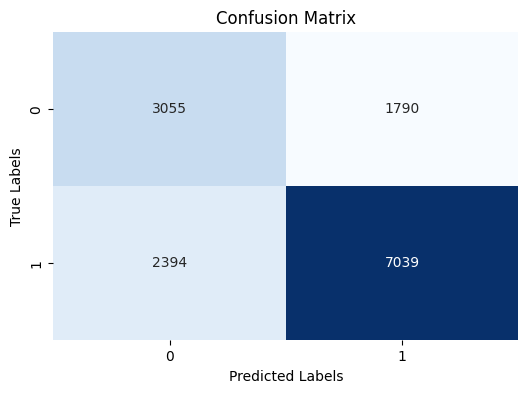



The accuracy of the Naive Bayes Model Using TextBlob: 69.16%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.54      0.67      0.60      3434
    Positive       0.81      0.70      0.75      6672

    accuracy                           0.69     10106
   macro avg       0.67      0.69      0.67     10106
weighted avg       0.72      0.69      0.70     10106



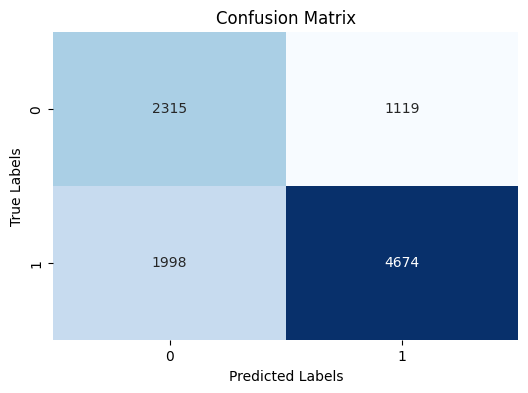

In [320]:
# Choose the Ngrams #################################################################################
# transforming data from Vader
vader_text_counts = tokenize_and_count(vader_labelling_df, 'clean_Text', ngram_range=(2, 2)) 

# transforming data from TextBlob
textblob_text_counts = tokenize_and_count(textblob_labelling_df, 'clean_Text', ngram_range=(2, 2))


# Split the data # Choose the Ngrams #################################################################
# call the function on vader data
X_train_v, X_test_v, Y_train_v, Y_test_v = split_data(vader_text_counts, 
                                                      vader_labelling_df['VADER_Sentiments'])

# call the function on Textblob data
X_train_t, X_test_t, Y_train_t, Y_test_t = split_data(textblob_text_counts, 
                                                      textblob_labelling_df['TextBlob_Sentiments'])


# Choose the Algorithm of Naive Bayes to use ###########################################################
# Train and Evaluate the classifier using the VADER training data using multinomial   
train_and_evaluate_model(X_train_v, Y_train_v, X_test_v, Y_test_v, 'VADER', MultinomialNB())

# Train and Evaluate the classifier using the TextBlob training data using multinomial    
train_and_evaluate_model(X_train_t, Y_train_t, X_test_t, Y_test_t, 'TextBlob', MultinomialNB())

##### Using Trigrams and Multinomial Naive Bayes

The accuracy of the Naive Bayes Model Using VADER: 55.41%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.42      0.77      0.54      4845
    Positive       0.79      0.44      0.57      9433

    accuracy                           0.55     14278
   macro avg       0.60      0.61      0.55     14278
weighted avg       0.66      0.55      0.56     14278



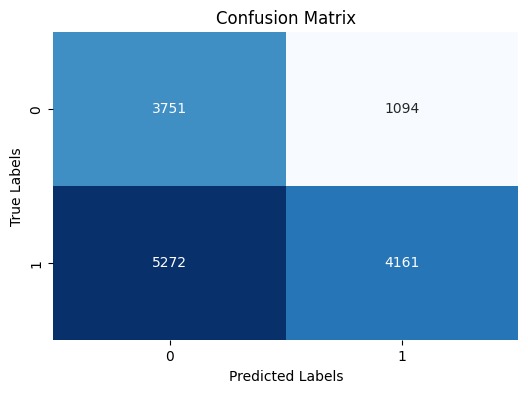



The accuracy of the Naive Bayes Model Using TextBlob: 50.60%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.39      0.83      0.53      3434
    Positive       0.79      0.34      0.48      6672

    accuracy                           0.51     10106
   macro avg       0.59      0.58      0.50     10106
weighted avg       0.66      0.51      0.50     10106



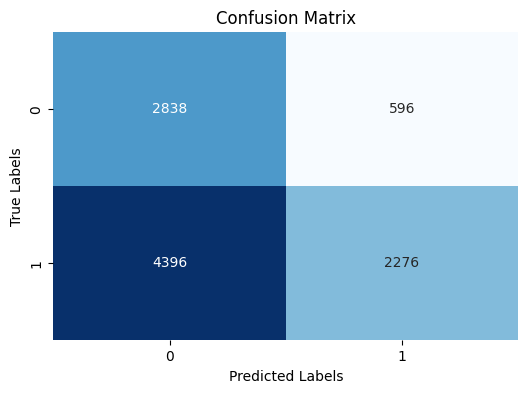

In [321]:
# Choose the Ngrams #################################################################################
# transforming data from Vader
vader_text_counts = tokenize_and_count(vader_labelling_df, 'clean_Text', ngram_range=(3, 3)) 

# transforming data from TextBlob
textblob_text_counts = tokenize_and_count(textblob_labelling_df, 'clean_Text', ngram_range=(3, 3))


# Split the data # Choose the Ngrams #################################################################
# call the function on vader data
X_train_v, X_test_v, Y_train_v, Y_test_v = split_data(vader_text_counts, 
                                                      vader_labelling_df['VADER_Sentiments'])

# call the function on Textblob data
X_train_t, X_test_t, Y_train_t, Y_test_t = split_data(textblob_text_counts, 
                                                      textblob_labelling_df['TextBlob_Sentiments'])


# Choose the Algorithm of Naive Bayes to use ###########################################################
# Train and Evaluate the classifier using the VADER training data using multinomial   
train_and_evaluate_model(X_train_v, Y_train_v, X_test_v, Y_test_v, 'VADER', MultinomialNB())

# Train and Evaluate the classifier using the TextBlob training data using multinomial    
train_and_evaluate_model(X_train_t, Y_train_t, X_test_t, Y_test_t, 'TextBlob', MultinomialNB())

##### Using Unigrams and ComplementNB

The accuracy of the Naive Bayes Model Using VADER: 82.19%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.72      0.79      0.75      4845
    Positive       0.88      0.84      0.86      9433

    accuracy                           0.82     14278
   macro avg       0.80      0.81      0.81     14278
weighted avg       0.83      0.82      0.82     14278



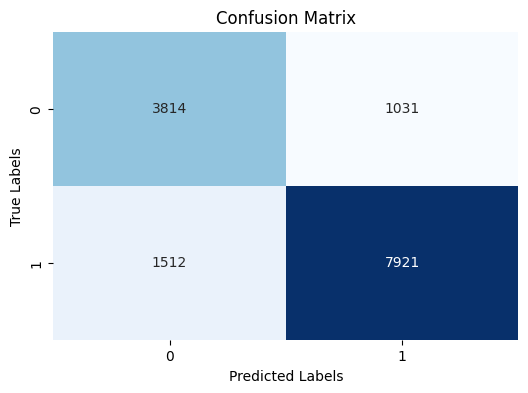



The accuracy of the Naive Bayes Model Using TextBlob: 84.70%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.78      0.78      3434
    Positive       0.89      0.88      0.88      6672

    accuracy                           0.85     10106
   macro avg       0.83      0.83      0.83     10106
weighted avg       0.85      0.85      0.85     10106



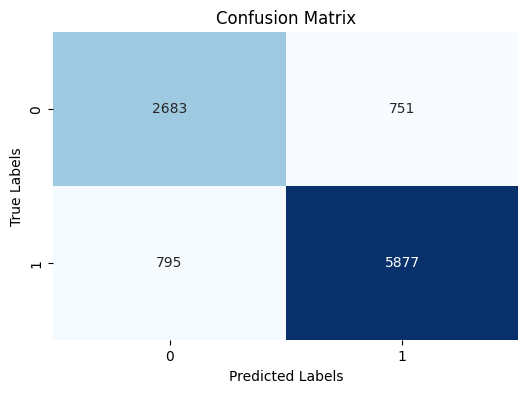

In [322]:
# Choose the Ngrams #################################################################################
# transforming data from Vader
vader_text_counts = tokenize_and_count(vader_labelling_df, 'clean_Text', ngram_range=(1, 1)) 

# transforming data from TextBlob
textblob_text_counts = tokenize_and_count(textblob_labelling_df, 'clean_Text', ngram_range=(1, 1))


# Split the data # Choose the Ngrams #################################################################
# call the function on vader data
X_train_v, X_test_v, Y_train_v, Y_test_v = split_data(vader_text_counts, 
                                                      vader_labelling_df['VADER_Sentiments'])

# call the function on Textblob data
X_train_t, X_test_t, Y_train_t, Y_test_t = split_data(textblob_text_counts, 
                                                      textblob_labelling_df['TextBlob_Sentiments'])


# Choose the Algorithm of Naive Bayes to use ###########################################################
# Train and Evaluate the classifier using the VADER training data using ComplementNB   
train_and_evaluate_model(X_train_v, Y_train_v, X_test_v, Y_test_v, 'VADER', ComplementNB())

# Train and Evaluate the classifier using the TextBlob training data using ComplementNB    
train_and_evaluate_model(X_train_t, Y_train_t, X_test_t, Y_test_t, 'TextBlob', ComplementNB())

##### Using Unigrams and GaussianNB

The accuracy of the Naive Bayes Model Using VADER: 43.23%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.35      0.81      0.49      4845
    Positive       0.71      0.24      0.36      9433

    accuracy                           0.43     14278
   macro avg       0.53      0.52      0.42     14278
weighted avg       0.59      0.43      0.40     14278



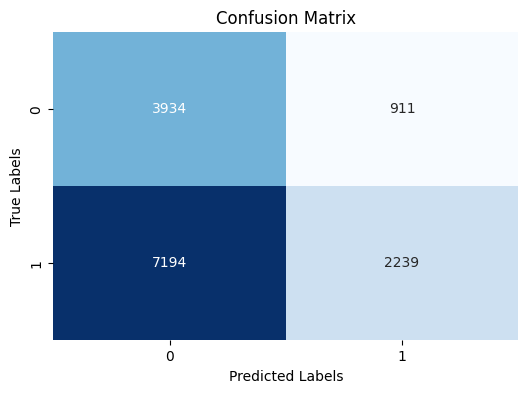



The accuracy of the Naive Bayes Model Using TextBlob: 45.75%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.36      0.77      0.49      3434
    Positive       0.71      0.30      0.42      6672

    accuracy                           0.46     10106
   macro avg       0.54      0.53      0.46     10106
weighted avg       0.59      0.46      0.44     10106



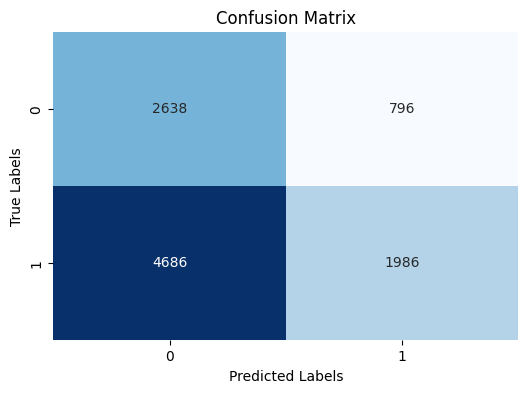

In [323]:
# Choose the Ngrams #################################################################################
# transforming data from Vader
vader_text_counts = tokenize_and_count(vader_labelling_df, 'clean_Text', ngram_range=(1, 1)) 

# transforming data from TextBlob
textblob_text_counts = tokenize_and_count(textblob_labelling_df, 'clean_Text', ngram_range=(1, 1))


# Split the data # Choose the Ngrams #################################################################
# call the function on vader data
X_train_v, X_test_v, Y_train_v, Y_test_v = split_data(vader_text_counts, 
                                                      vader_labelling_df['VADER_Sentiments'])

# call the function on Textblob data
X_train_t, X_test_t, Y_train_t, Y_test_t = split_data(textblob_text_counts, 
                                                      textblob_labelling_df['TextBlob_Sentiments'])


# Choose the Algorithm of Naive Bayes to use ###########################################################
# Convert sparse matrix to dense numpy array
X_train_v_dense = X_train_v.toarray()
X_test_v_dense = X_test_v.toarray()

X_train_t_dense = X_train_t.toarray()
X_test_t_dense = X_test_t.toarray()

# Train and Evaluate the classifier using the VADER training data using GaussianNB   
train_and_evaluate_model(X_train_v_dense, Y_train_v, X_test_v_dense, Y_test_v, 'VADER', GaussianNB())

# Train and Evaluate the classifier using the TextBlob training data using multinomial    
train_and_evaluate_model(X_train_t_dense, Y_train_t, X_test_t_dense, Y_test_t, 'TextBlob', GaussianNB())

These results show the performance of Naive Bayes models using different n-gram settings and sentiment data from VADER and TextBlob. Here's a breakdown of the results for each case:

#### i. Multinomial Naive Bayes

* **Unigrams and VADER sentiment data using Multinomial Naive Bayes:**

    * Accuracy: 82.74%
    * Precision, recall, and F1-score for the "Negative" class are 0.78, 0.69, and 0.73, respectively.
    * Precision, recall, and F1-score for the "Positive" class are 0.85, 0.90, and 0.87, respectively.

* **Unigrams and TextBlob sentiment data using Multinomial Naive Bayes:**

    * Accuracy: 84.58%
    * Precision, recall, and F1-score for the "Negative" class are 0.83, 0.69, and 0.75, respectively.
    * Precision, recall, and F1-score for the "Positive" class are 0.85, 0.93, and 0.89, respectively.

* **Bigrams and VADER sentiment data using Multinomial Naive Bayes:**

    * Accuracy: 70.70%
    * Precision, recall, and F1-score for the "Negative" class are 0.56, 0.63, and 0.59, respectively.
    * Precision, recall, and F1-score for the "Positive" class are 0.80, 0.75, and 0.77, respectively.

* **Bigrams and TextBlob sentiment data using Multinomial Naive Bayes:**

    * Accuracy: 69.16%
    * Precision, recall, and F1-score for the "Negative" class are 0.54, 0.67, and 0.60, respectively.
    * Precision, recall, and F1-score for the "Positive" class are 0.81, 0.70, and 0.75, respectively.

* **Trigrams and VADER sentiment data using Multinomial Naive Bayes:** 

    * Accuracy: 55.41%
    * Precision, recall, and F1-score for the "Negative" class are 0.42 , 0.77, and 0.54, respectively.
    * Precision, recall, and F1-score for the "Positive" class are 0.79, 0.44, and 0.57, respectively.

* **Bigrams and TextBlob sentiment Data using Using Multinomial Naive Bayes:**

    * Accuracy: 50.60%
    * Precision, recall, and F1-score for the "Negative" class are 0.39, 0.83, and 0.53, respectively.
    * Precision, recall, and F1-score for the "Positive" class are 0.79, 0.34, and 0.48, respectively.


#### ii. Using Unigrams and ComplementNB:

* **Naive Bayes Model Using VADER:**

    * Accuracy: 82.19%
    * Precision, recall, and F1-score for the "Negative" class: 0.72, 0.79, 0.75
    * Precision, recall, and F1-score for the "Positive" class: 0.88, 0.84, 0.86
    
* **Naive Bayes Model Using TextBlob:**

    * Accuracy: 84.70%
    * Precision, recall, and F1-score for the "Negative" class: 0.77, 0.78, 0.78
    * Precision, recall, and F1-score for the "Positive" class: 0.89, 0.88, 0.88
    
#### iii. Using Unigrams and GaussianNB:

* **Naive Bayes Model Using VADER:**

    * Accuracy: 43.23%
    * Precision, recall, and F1-score for the "Negative" class: 0.35, 0.81, 0.49
    * Precision, recall, and F1-score for the "Positive" class: 0.71, 0.24, 0.36
    
* **Naive Bayes Model Using TextBlob:**

    * Accuracy: 45.75%
    * Precision, recall, and F1-score for the "Negative" class: 0.36, 0.77, 0.49
    * Precision, recall, and F1-score for the "Positive" class: 0.71, 0.30, 0.42
    

**Therfore, It was concluded that Using Unigrams makes the best predictor and therefore, the other algorithms would be tested using Unigrams**

## Support Vector Machine (SVM)

Support Vector Machine (SVM) is a powerful and widely used machine learning algorithm for both classification and regression tasks. It belongs to the family of supervised learning algorithms and is particularly effective in solving complex classification problems. 

### Support Vector Machine (SVM) Preparations

In [ ]:
# Splitting datasets for VADER sentiment data ####################################################
train_v, test_v = train_test_split(vader_labelling_df, test_size=0.2, random_state=1)

# Training data features (VADER)
X_train_v = train_v['clean_Text']  

# Testing data features (VADER)
X_test_v = test_v['clean_Text'] 

# Training data labels (VADER)
y_train_v = train_v['VADER_Sentiments'] 

# Testing data labels (VADER)
y_test_v = test_v['VADER_Sentiments']  


# Splitting datasets for TextBlob sentiment data ####################################################
train_t, test_t = train_test_split(textblob_labelling_df, test_size=0.2, random_state=1)

# Training data features (TextBlob)
X_train_t = train_t['clean_Text'].values 

# Testing data features (TextBlob)
X_test_t = test_t['clean_Text'].values

# Training data labels (TextBlob)
y_train_t = train_t['TextBlob_Sentiments']  

# Testing data labels (TextBlob)
y_test_t = test_t['TextBlob_Sentiments']  

### Hyperparameter Tuning

In [325]:
# classifier
pipeline = Pipeline([('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1,1))),
                     ('clf', svm.SVC(kernel='linear',C=1.9, gamma='auto')),])

parameters = {'tfidf__max_features': (3600,10000)}

# function for hyperparameter tuning
def perform_sentiment_analysis_grid_search(X_train, y_train, pipeline, parameters, model):
    """
    Perform grid search for sentiment analysis using a specified pipeline and parameters.

    Parameters:
    - X_train (array-like, shape (n_samples,)): The training data.
    - y_train (array-like, shape (n_samples,)): The target labels.
    - pipeline (sklearn.pipeline.Pipeline): The pipeline object containing the feature extraction and 
    classification steps.
    - parameters (dict): The parameters to be tuned for grid search.

    Returns:
    - None

    Prints the best score, best parameters, and the duration of the grid search process.

    """
    
    # Create a scorer for F1 score
    f1_scorer = make_scorer(f1_score, average='micro', pos_label="fake")

    # Create a grid search object
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=10, verbose=1, scoring=f1_scorer)

    print(f"Performing grid search for {model}...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)

    # Start the timer
    t0 = time.time()

    # Fit the grid search object to the training data
    grid_search.fit(X_train, y_train)

    # Print the duration of the grid search process
    print("done in %0.3fs" % (time.time() - t0))
    print()

    # Print the best score and best parameters found
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")

    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
    print('')


# Calling the function for VADER data
# VADER dataset
perform_sentiment_analysis_grid_search(X_train_v, y_train_v, pipeline, parameters, "VADER")

# Calling the function for TextBlob data
# TextBlob dataset
perform_sentiment_analysis_grid_search(X_train_t, y_train_t, pipeline, parameters, "TextBlob")

Performing grid search for VADER...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_features': (3600, 10000)}
Fitting 10 folds for each of 2 candidates, totalling 20 fits
done in 2170.284s

Best score: 0.897
Best parameters set:
	tfidf__max_features: 10000

Performing grid search for TextBlob...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_features': (3600, 10000)}
Fitting 10 folds for each of 2 candidates, totalling 20 fits
done in 1158.152s

Best score: 0.936
Best parameters set:
	tfidf__max_features: 10000



###  Training the model

In [326]:
def train_sentiment_analysis_SVM_model(data, x_train, x_test, y_train, y_test, column):
    """
    Train a sentiment analysis model using SVM with TF-IDF vectorization.

    Parameters:
    - data (pandas.DataFrame): The complete dataset containing tweet data.
    - column (str): The column name in `data` containing the text data.
    - x_train (array-like, shape (n_samples,)): The training data.
    - x_test (array-like, shape (n_samples,)): The testing data.
    - y_train (array-like, shape (n_samples,)): The training labels.
    - y_test (array-like, shape (n_samples,)): The testing labels.

    Returns:
    - SVM (sklearn.svm.SVC): The trained SVM model.
    - Tfidf_vect (sklearn.feature_extraction.text.TfidfVectorizer): The TF-IDF vectorizer fitted on 
    the complete data.

    """

    # Initialize the TF-IDF vectorizer
    Tfidf_vect = TfidfVectorizer(max_features=3600, min_df=2, max_df=0.5, ngram_range=(1,1))

    # Fit the vectorizer on the complete data
    Tfidf_vect.fit(data[column])

    # Transform the training and testing data into TF-IDF features
    train_x_tfidf = Tfidf_vect.transform(x_train)
    test_x_tfidf = Tfidf_vect.transform(x_test)

    labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    categories = ['Positive', 'Negative']

    # Classifier - Support Vector Machine
    # Initialize the SVM classifier
    SVM = svm.SVC(C=1.9, kernel='linear')

    # Train the SVM model
    SVM.fit(train_x_tfidf, y_train)
    
    # Predict using the trained SVM model
    svm_predictions = SVM.predict(test_x_tfidf)

    # Return the trained model and vectorizer
    return SVM, svm_predictions

# Train sentiment analysis model on VADER dataset
svm_model_v, svm_predictions_v = train_sentiment_analysis_SVM_model(train_v,
                                                 X_train_v,  
                                                 X_test_v, 
                                                 y_train_v, 
                                                 y_test_v,
                                                'clean_Text',)

# Train sentiment analysis model on TextBlob dataset
svm_model_t, svm_predictions_t = train_sentiment_analysis_SVM_model(train_t,
                                                 X_train_t, 
                                                 X_test_t, 
                                                 y_train_t, 
                                                 y_test_t,
                                                'clean_Text')

###  Evaluating the Model

The accuracy of the SVM Model; VADER dataset: 89.01%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.81      0.83      3833
    Positive       0.90      0.93      0.92      7590

    accuracy                           0.89     11423
   macro avg       0.88      0.87      0.87     11423
weighted avg       0.89      0.89      0.89     11423


Confusion Matrix:


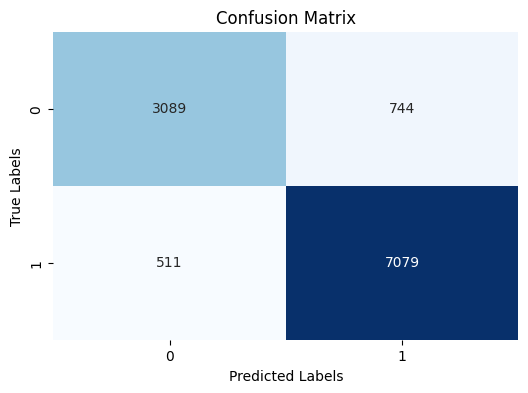



The accuracy of the SVM Model; TextBlob dataset: 93.89%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.89      0.91      2749
    Positive       0.94      0.96      0.95      5336

    accuracy                           0.94      8085
   macro avg       0.94      0.93      0.93      8085
weighted avg       0.94      0.94      0.94      8085


Confusion Matrix:


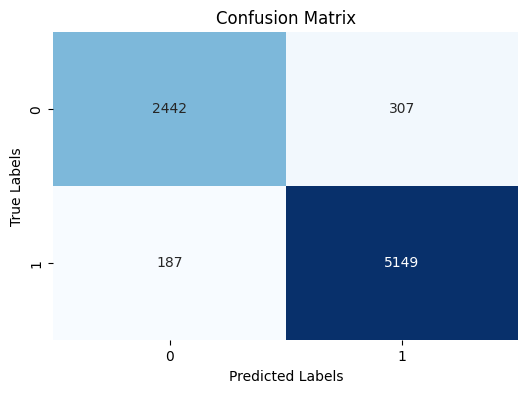

In [327]:
def print_sentiment_analysis_results(y_test, predictions, sent_model):
    """
    Print the sentiment analysis results including accuracy, classification report, and 
    confusion matrix.

    Parameters:
    - y_test (array-like, shape (n_samples,)): The true labels.
    - predictions (array-like, shape (n_samples,)): The predicted labels.

    Returns:
    - None

    Prints the accuracy, classification report, and confusion matrix.

    """

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions) * 100

    # Print accuracy
    print("The accuracy of the SVM Model; {} dataset: {:.2f}%".format(sent_model, accuracy))

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))

    # Print confusion matrix
    print('')
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    print()
    print()

# Print sentiment analysis results for VADER dataset
print_sentiment_analysis_results(y_test_v, svm_predictions_v, "VADER")

# Print sentiment analysis results for TextBlob dataset
print_sentiment_analysis_results(y_test_t, svm_predictions_t, "TextBlob")

The classification results indicate the accuracy, precision, recall, and F1-score of the SVM models using the Support Vector Machine algorithm. Here's a summary of the results:

**For the VADER dataset:**

* SVM Model Accuracy: 89.01%
* Precision, recall, and F1-score for the "Negative" class: 0.86, 0.81, 0.83
* Precision, recall, and F1-score for the "Positive" class: 0.90, 0.93, 0.92

**For the TextBlob dataset:**

* SVM Model Accuracy: 93.89%
* Precision, recall, and F1-score for the "Negative" class: 0.93, 0.89, 0.91
* Precision, recall, and F1-score for the "Positive" class: 0.94, 0.96, 0.95

## Random Forest

### Random Forest Preparations

In [328]:
# Splitting datasets for VADER sentiment data ####################################################
train_v, test_v = train_test_split(vader_labelling_df, test_size=0.2, random_state=1)

# Training data features (VADER)
X_train_v = train_v['clean_Text']  

# Testing data features (VADER)
X_test_v = test_v['clean_Text'] 

# Training data labels (VADER)
y_train_v = train_v['VADER_Sentiments'] 

# Testing data labels (VADER)
y_test_v = test_v['VADER_Sentiments']  

# Splitting datasets for TextBlob sentiment data ####################################################
train_t, test_t = train_test_split(textblob_labelling_df, test_size=0.2, random_state=1)

# Training data features (TextBlob)
X_train_t = train_t['clean_Text'].values 

# Testing data features (TextBlob)
X_test_t = test_t['clean_Text'].values

# Training data labels (TextBlob)
y_train_t = train_t['TextBlob_Sentiments']  

# Testing data labels (TextBlob)
y_test_t = test_t['TextBlob_Sentiments']  

#### Creating TF-IDF Vectorized Data

In [329]:
def create_vect_data(train_data, test_data, X_train, X_test, column):
    """
    Create TF-IDF vectorized data from the text data in the given columns of the training and 
    testing datasets.

    Parameters:
    - X_train (pandas.DataFrame): The training dataset.
    - X_test (pandas.DataFrame): The testing dataset.
    - column (str): The column name in X_train and X_test that contains the text data.

    Returns:
    - X_train_vect (scipy.sparse.csr_matrix): The TF-IDF vectorized training data.

    """

    # Initialize the TF-IDF vectorizer
    tfidf_vect = TfidfVectorizer()

    # Fit the vectorizer on the training data
    tfidf_vect_fit = tfidf_vect.fit(train_data[column])

    # Transform the training and testing data into TF-IDF features
    tfidf_train = tfidf_vect_fit.transform(train_data[column])
    tfidf_test = tfidf_vect_fit.transform(test_data[column])

    # Convert the TF-IDF features to sparse matrices
    X_train_vect = sparse.csr_matrix(tfidf_train)
    X_test_vect = sparse.csr_matrix(tfidf_test)

    # Return the TF-IDF vectorized training data
    return X_train_vect, X_test_vect

# Create TF-IDF vectorized data for VADER dataset
X_train_vect_v, X_test_vect_v = create_vect_data(train_v, test_v, X_train_v, X_test_v, 'clean_Text')

# Create TF-IDF vectorized data for TextBlob dataset
X_train_vect_t, X_test_vect_t = create_vect_data(train_t, test_t, X_train_t, X_test_t, 'clean_Text')

#### Training Random Forest

This function train_random_forest takes the TF-IDF vectorized training data (X_train), training labels (y_train), and the TF-IDF vectorized testing data (X_test) as input. It trains a Random Forest classifier using the training data and labels.

Within the function:

* The Random Forest classifier (rf) is initialized with the specified parameters, such as n_estimators and max_depth.
* The Random Forest model is trained using the TF-IDF vectorized training data and labels.
* The labels are predicted for the TF-IDF vectorized testing data using the trained Random Forest model.
* The predicted labels (y_pred) for the testing data are returned.

This function allows you to train a Random Forest classifier using the TF-IDF vectorized data, making it suitable for performing sentiment analysis or other classification tasks on different datasets.

In [330]:
def train_random_forest(X_train_vect,  y_train, X_test_vect):
    """
    Train a Random Forest classifier using the given TF-IDF vectorized training data and labels.

    Parameters:
    - X_train (pandas.DataFrame): The TF-IDF vectorized training data.
    - y_train (array-like, shape (n_samples,)): The training labels.
    - X_test (pandas.DataFrame): The TF-IDF vectorized testing data.

    Returns:
    - y_pred (array-like, shape (n_samples,)): The predicted labels for the testing data.

    """

    # Initialize the Random Forest classifier
    rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

    # Train the Random Forest model using the TF-IDF vectorized training data and labels
    rf_model = rf.fit(X_train_vect, y_train)

    # Predict the labels for the TF-IDF vectorized testing data
    y_pred = rf_model.predict(X_test_vect)

    # Return the predicted labels for the testing data
    return y_pred

# Train Random Forest classifier on VADER dataset
RF_predictions_v = train_random_forest(X_train_vect_v, y_train_v, X_test_vect_v)

# Train Random Forest classifier on TextBlob dataset
RF_predictions_t = train_random_forest(X_train_vect_t, y_train_t, X_test_vect_t)

#### Evaluating Random Forest Model

The accuracy of the Random Forest Model; VADER dataset: 83.06%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.59      0.70      3833
    Positive       0.82      0.95      0.88      7590

    accuracy                           0.83     11423
   macro avg       0.84      0.77      0.79     11423
weighted avg       0.83      0.83      0.82     11423


Confusion Matrix:


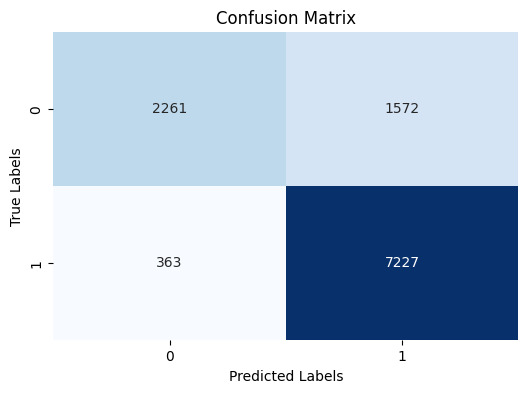



The accuracy of the Random Forest Model; TextBlob dataset: 89.87%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.77      0.84      2749
    Positive       0.89      0.97      0.93      5336

    accuracy                           0.90      8085
   macro avg       0.91      0.87      0.88      8085
weighted avg       0.90      0.90      0.90      8085


Confusion Matrix:


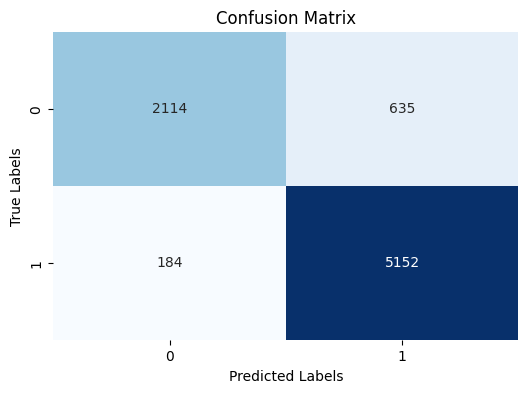

In [331]:
def print_sentiment_analysis_results(y_test, predictions, sent_model):
    """
    Print the sentiment analysis results including accuracy, classification report, and 
    confusion matrix.

    Parameters:
    - y_test (array-like, shape (n_samples,)): The true labels.
    - predictions (array-like, shape (n_samples,)): The predicted labels.

    Returns:
    - None

    Prints the accuracy, classification report, and confusion matrix.

    """

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions) * 100

    # Print accuracy
    print("The accuracy of the Random Forest Model; {} dataset: {:.2f}%".format(sent_model, accuracy))

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))

    # Print confusion matrix
    print('')
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    print()
    print()

# Print sentiment analysis results for VADER dataset
print_sentiment_analysis_results(y_test_v, RF_predictions_v, "VADER")

# Print sentiment analysis results for TextBlob dataset
print_sentiment_analysis_results(y_test_t, RF_predictions_t, "TextBlob")

The classification results indicate the accuracy, precision, recall, and F1-score of the Random Forest models. Here's a summary of the results:

**For the VADER dataset:**

* Random Forest Model Accuracy: 83.03%
* Precision, recall, and F1-score for the "Negative" class: 0.86, 0.59, 0.70
* Precision, recall, and F1-score for the "Positive" class: 0.82, 0.95, 0.88

**For the TextBlob dataset:**

* Random Forest Model Accuracy: 89.98%
* Precision, recall, and F1-score for the "Negative" class: 0.92, 0.77, 0.84
* Precision, recall, and F1-score for the "Positive" class: 0.89, 0.96, 0.93

**Based on the accuracy scores provided, the SVM model using the TextBlob dataset achieved the highest accuracy of 93.89%, followed closely by the Random Forest model using the TextBlob dataset with an accuracy of 89.98%.**

# Deploying SVM on Deploying Dataset

The model SVM performed best so we decided to use it to predict our deploying dataset. Therefore, we first used the TF-IDF (Term Frequency-Inverse Document Frequency) vectorization technique to process text data and create numerical features for SVM, just like we did with the training data. 

## Separating the Train Test Data and the Validation Data

In [332]:
# Shuffle the DataFrame rows randomly
reshuffled_df = deploying_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the reshuffled DataFrame into train_test_data and prediction_data
train_test_data = reshuffled_df.iloc[:59997]
prediction_data = reshuffled_df.iloc[59997:]

# If you want to reset the index for both DataFrames (optional)
train_test_data.reset_index(drop=True, inplace=True)
prediction_data.reset_index(drop=True, inplace=True)

# save the data for final prediction
prediction_data.to_csv('final_prediction.csv', index=False)

In [333]:
# Initialize the TF-IDF vectorizer
Tfidf_vect = TfidfVectorizer(max_features=3600, min_df=2, max_df=0.5, ngram_range=(1,1))

# Fit the vectorizer on the complete data
Tfidf_vect.fit(train_test_data['clean_Text'])

# Transform the new data into TF-IDF features
new_data_tfidf = Tfidf_vect.transform(train_test_data['clean_Text'])

## Predicting the Sentiments

Since we had trained two models in 1; One using sentiment labels from VADER and another using sentiment labels from TextBlob libraries, we will use both of them to make predictions. We will then visualize them separately to compare the results. 

In [334]:
# Make predictions using the SVM models
predictions_v = svm_model_v.predict(new_data_tfidf)
predictions_t = svm_model_t.predict(new_data_tfidf)

# Adding the predictions to the DataFrame
train_test_data['VADER_Sentiments'] = predictions_v
train_test_data['TextBlob_Sentiments'] = predictions_t

# Save the DataFrame with predictions to a new CSV file
# train_test_data.to_csv('train_test_data_with_predictions.csv', index=False)

# Creating A Model To Predict Elections

* The major assumption here is that sentiment expressed in comments or tweets directly translates into voting behavior. The model assumes that any positive comment or tweet about a specific candidate reflects an intention to vote for that candidate, while any negative sentiment indicates a vote against them.

* The model also assumes that social media is representative of the entire voting population, and that no certain demographics is over- or under-represented on various social media platforms, leading to potential biases in the sentiment analysis.

## Importing Additional Libraries

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import keras 
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential, Model 
from keras.callbacks import History
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_selection import RFE
from pylab import rcParams
from matplotlib import rc
from collections import defaultdict
from textwrap import wrap
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import AutoTokenizer, TFAutoModel
from IPython.display import clear_output
import tensorflow as tf
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

## Loading the New Predicted Dataset

Since we saved the predicted dataset as csv to access it without training the model again, we need to load the new data into our environments. 

In [3]:
# loading the dataset
data = pd.read_csv('train_test_data_with_predictions.csv')

# remove nulls
data = data.dropna()

# print shape of data
print(data.shape)

# overview of data
data.head(5)

(59986, 5)


,created_at,candidate,clean_Text,VADER_Sentiments,TextBlob_Sentiments
0,2023-01-09 07:17:03+00:00,Kwankwaso,all presidential candidates addressed your exc...,Negative,Positive
1,2023-01-19 23:56:48+00:00,Atiku,makinde absent loyalists attend atiku’s rally ...,Positive,Positive
2,2023-02-13 22:29:34+00:00,Atiku,the reality ground for president olusegun obas...,Positive,Positive
3,2022-12-29 21:56:56+00:00,Tinubu,in years old st pic years later years old nd p...,Negative,Negative
4,2023-01-27 22:38:47+00:00,Tinubu,naja’atu said tinubu is mentally deranged does...,Negative,Positive


## Separating VADER and TextBlob Data

And because we had predicted the sentiment using two models, one based on sentiments from VADER and another based on Textblob, we are going to separate both datasets so we can look at them individually.

In [4]:
# select VADER data
vader_data = data.drop(['TextBlob_Sentiments'], axis=1)

# select TextBlob Data
textblob_data = data.drop(['VADER_Sentiments'], axis=1)

## Logistic Regression

Logistic Regression is a fundamental and widely used statistical method for binary classification tasks. It is a type of linear regression that models the relationship between the input features and the probability of a binary outcome, such as yes/no, true/false, or 0/1.

### Converting Sentiment Labels into Binary
This process converts the sentiment labels into numerical format, making it suitable for model training and evaluation.

In [5]:
# define mapping function
sentiment_map = {'Positive': 1, 'Negative': 0}

# apply mapping function to sentiment column - vader data
vader_data['VADER_Sentiment'] = vader_data['VADER_Sentiments'].map(sentiment_map)

# apply mapping function to sentiment column - TextBlob data
textblob_data['TextBlob_Sentiment'] = textblob_data['TextBlob_Sentiments'].map(sentiment_map)

### Splitting the Data in the Best Way for Logistic Regression

This function takes the original DataFrame containing the text data and sentiment labels as input. It splits the data into 80% training and 20% testing for both positive and negative samples, while ensuring class balance.

In [6]:
def splitting_data(data, Sent_colum):
    """
    Split data into training and testing sets while balancing the classes.

    Args:
        data (pandas.DataFrame): The original DataFrame containing the text data and sentiment labels.

    Returns:
        tuple: A tuple containing X_train, y_train, X_test, and y_test.

    """
    # Separate positive and negative samples
    positive_data = data[data[Sent_colum] == 1]
    negative_data = data[data[Sent_colum] == 0]

    # Split positive data into 80% training and 20% testing
    X_train_positive, X_test_positive, y_train_positive, y_test_positive = train_test_split(
        positive_data['clean_Text'], positive_data[Sent_colum], test_size=0.2, random_state=42)

    # Split negative data into 80% training and 20% testing
    X_train_negative, X_test_negative, y_train_negative, y_test_negative = train_test_split(
        negative_data['clean_Text'], negative_data[Sent_colum], test_size=0.2, random_state=42)

    # Concatenate the training and testing sets for both groups
    X_train = pd.concat([X_train_positive, X_train_negative])
    X_test = pd.concat([X_test_positive, X_test_negative])
    y_train = pd.concat([y_train_positive, y_train_negative])
    y_test = pd.concat([y_test_positive, y_test_negative])

    # Shuffle the data
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    X_test, y_test = shuffle(X_test, y_test, random_state=42)

    return X_train, y_train, X_test, y_test

# split the vader data
X_train_vader, y_train_vader, X_test_vader, y_test_vader = splitting_data(vader_data, 'VADER_Sentiment')

# splitting the TextBlob Data
X_train_textblob, y_train_textblob, X_test_textblob, y_test_textblob = splitting_data(textblob_data, 
                                                                                      'TextBlob_Sentiment')

### Tokenizing Data

The code below defines a function named tokenize_data that tokenizes text data using Keras Tokenizer. 

In [7]:
def tokenize_data(data, max_features=100000, max_seq_length=29):
    """
    Tokenize the text data using Keras Tokenizer.

    Args:
        data (pandas.Series): The text data to be tokenized.
        max_features (int): The maximum number of features (vocabulary size). Default is 100000.
        max_seq_length (int): The maximum sequence length for padding. Default is 29.

    Returns:
        tuple: A tuple containing the tokenized and padded sequences and the tokenizer object.
    """
    # Create a Tokenizer object with a specified maximum vocabulary size and word split character
    tokenizer = Tokenizer(num_words=max_features, split=' ')

    # Fit the Tokenizer on the input text data to build the vocabulary
    tokenizer.fit_on_texts(data)

    # Convert the input text data to sequences of integers using the learned vocabulary
    sequences = tokenizer.texts_to_sequences(data)

    # Pad the sequences to ensure uniform length for the model input
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)

    # Return the padded sequences and the Tokenizer object for later use
    return padded_sequences, tokenizer

# tokenize vader data
X_train_sequences_vader, tokenizer_vader = tokenize_data(X_train_vader)
X_test_sequences_vader, _ = tokenize_data(X_test_vader)

# tokenize textblob data
X_train_sequences_textblob, tokenizer_textblob = tokenize_data(X_train_textblob)
X_test_sequences_textblob, _ = tokenize_data(X_test_textblob)

### Training the Logistic Regression Model

In [8]:
def train_model(X_train, y_train, n_features=29):
    """
    Train a logistic regression model with cross-validation and perform feature selection with RFE.

    Args:
        X_train (array-like): Training feature matrix.
        y_train (array-like): Training labels.
        n_features (int): Number of features to select. Default is 29.

    Returns:
        RandomForestClassifier: Trained ensemble model.
    """
    # Define the logistic regression estimator with cross-validation
    lr_cv = LogisticRegression(max_iter=1000, random_state=42)

    # Fitting the model
    lr_cv.fit(X_train, y_train)

    # Passing the fitted logistic regression model to the feature selector
    rfe = RFE(lr_cv, n_features_to_select=n_features)

    # Fitting the feature selector
    rfe.fit(X_train, y_train)

    # Creating a new dataset with the selected features
    X_train_rfe = rfe.transform(X_train)

    # Fitting an ensemble model
    ensemble = RandomForestClassifier(n_estimators=100, random_state=42)
    ensemble.fit(X_train_rfe, y_train)

    return ensemble

# Train the model on VADER data
print('Training model for VADER data')
model_vader = train_model(X_train_sequences_vader, y_train_vader)

# Train the model on TextBlob data
print('Training model for TextBlob data')
model_textblob = train_model(X_train_sequences_textblob, y_train_textblob)

Training model for VADER data
Training model for TextBlob data


### Evaluating and  Printing Evaluation Metrics for Logistic Regression Model

Evaluation for VADER data
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.22      0.31      4820
           1       0.62      0.85      0.72      7178

    accuracy                           0.60     11998
   macro avg       0.56      0.54      0.51     11998
weighted avg       0.57      0.60      0.55     11998

Confusion Matrix:


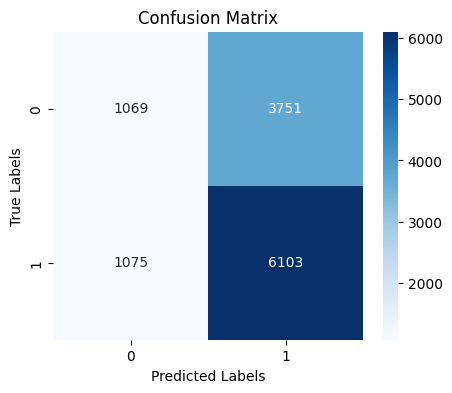



Evaluation for TextBlob data
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.15      0.23      4433
           1       0.65      0.93      0.76      7565

    accuracy                           0.64     11998
   macro avg       0.60      0.54      0.50     11998
weighted avg       0.61      0.64      0.57     11998

Confusion Matrix:


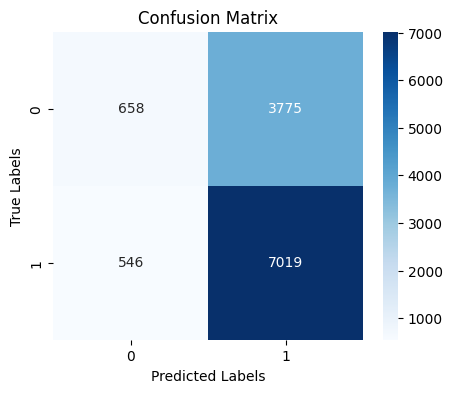

In [9]:
def predict_and_evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model on the test data and print the classification report and confusion matrix.

    Args:
        model: The trained model.
        X_test (numpy.array): The test feature matrix.
        y_test (numpy.array): The test labels.

    Returns:
        None
    """
    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Convert probabilities to binary predictions based on a threshold of 0.5
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Print the classification report comparing the predictions to the true labels
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary))

    # Print the confusion matrix
    print("Confusion Matrix:")
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred_binary)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on VADER test set
print('Evaluation for VADER data')
predict_and_evaluate_model(model_vader, X_test_sequences_vader, y_test_vader)
print('')
print('')

# Evaluate the model on TextBlob test set
print('Evaluation for TextBlob data')
predict_and_evaluate_model(model_textblob, X_test_sequences_textblob, y_test_textblob)

## BERT Transformer Model

The code below loads a pre-trained BERT (Bidirectional Encoder Representations from Transformers) model along with its tokenizer. 

In [10]:
# Load the pre-trained tokenizer for BERT
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Load the pre-trained BERT model with hidden states enabled
model_bert = TFAutoModel.from_pretrained(checkpoint, output_hidden_states=True)

# Clear the output to avoid displaying unnecessary information
# clear_output()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Balancing the Sentiment Labels

We perform data sampling and preprocessing on two datasets, VADER sentiment analysis, and TextBlob sentiment analysis. 

In [ ]:
vader_data.VADER_Sentiment.value_counts()

1    35887
0    24099
Name: VADER_Sentiment, dtype: int64

In [ ]:
textblob_data.TextBlob_Sentiments.value_counts()

Positive    37825
Negative    22161
Name: TextBlob_Sentiments, dtype: int64

In [13]:
# VADER data 
positive_df = vader_data[vader_data['VADER_Sentiments'] == 'Positive'].head(n=24099) # get 24099 positive tweets
negative_df = vader_data[vader_data['VADER_Sentiments'] == 'Negative'].head(n=24099) # get 24099 negative tweets
vader_data = pd.concat([positive_df, negative_df], ignore_index=True) # Concatenate the +ve and _ve data
vader_data = vader_data.sample(frac=1, random_state=0) # Shuffle the resulting dataframe

# TextBlob data 
positive_df2 = textblob_data[textblob_data['TextBlob_Sentiments'] == 'Positive'].head(n=22161) # get 22161 positive tweets
negative_df2 = textblob_data[textblob_data['TextBlob_Sentiments'] == 'Negative'].head(n=22161) # get 22161 negative tweets
textblob_data = pd.concat([positive_df2, negative_df2], ignore_index=True) # Concatenate the +ve and _ve data
textblob_data = textblob_data.sample(frac=1, random_state=0) # Shuffle the resulting dataframe

In [14]:
vader_data.VADER_Sentiment.value_counts()

1    24099
0    24099
Name: VADER_Sentiment, dtype: int64

In [15]:
textblob_data.TextBlob_Sentiments.value_counts()

Negative    22161
Positive    22161
Name: TextBlob_Sentiments, dtype: int64

### Splitting the Data for Train and Test

The create_datasets function takes a DataFrame df, text column name text_column, and sentiment column name sentiment_column as inputs. It splits the input DataFrame into training, validation, and test sets using train_test_split while ensuring the class distribution is stratified based on sentiment labels.

In [16]:
def create_datasets(df, text_column, sentiment_column):
    """
    Splits the data into training, validation, and test sets and creates datasets and targets dictionaries.

    Args:
        df (pandas.DataFrame): The original DataFrame containing the text data and sentiment labels.
        text_column (str): The name of the column containing the text data.
        sentiment_column (str): The name of the column containing the sentiment labels.
        test_size (float): The proportion of the data to include in the test set. Default is 0.2.
        random_state (int or None): Random state for reproducibility. Default is None.

    Returns:
        tuple: A tuple containing datasets and targets dictionaries for training, validation, and test sets.
    """
    
    test_size=0.2
    random_state=44

    # Split data into sequences and test_val_sequences
    sequences, test_val_sequences = train_test_split(df, test_size=test_size,
                                                     stratify=df[sentiment_column],
                                                     random_state=random_state)

    # Split test_val_sequences into validation and test sets
    val_sequences, test_sequences = train_test_split(test_val_sequences, test_size=0.5,
                                                     stratify=test_val_sequences[sentiment_column],
                                                     random_state=random_state)

    # Create datasets dictionary
    datasets = {
        "TRAIN": sequences[text_column].values.tolist(),
        "TEST": test_sequences[text_column].values.tolist(),
        "VAL": val_sequences[text_column].values.tolist()
    }

    # Create targets dictionary
    targets = {
        "TRAIN": sequences[sentiment_column].values.tolist(),
        "TEST": test_sequences[sentiment_column].values.tolist(),
        "VAL": val_sequences[sentiment_column].values.tolist()
    }

    return datasets, targets

# For VADER data
datasets_vader, targets_vader = create_datasets(vader_data, 'clean_Text', 'VADER_Sentiment')

# For TextBlob DAta
datasets_textblob, targets_textblob = create_datasets(textblob_data, 'clean_Text', 'TextBlob_Sentiment')

### Data Tokenization

The tokenization function performs tokenization on the input data using the BERT tokenizer. 

In [17]:
def tokenization(data, **kwargs):
    # Tokenize the input data using the BERT tokenizer    
    return tokenizer(data, 
                     # Padding: Pad sequences to the longest sequence in the data
                     padding=kwargs.get('padding','longest'),
                     
                     # Max length: Set the maximum length of the tokenized sequences to 54 (default value)
                     max_length=kwargs.get('max_length',54),
                     
                     # Truncation: Truncate sequences that exceed the maximum length
                     truncation=True, 
                     
                     # Return tensors: Return the tokenized sequences as TensorFlow tensors
                     return_tensors="tf")

### Base BERT Model

In [18]:
def get_model(**kwargs):
    # Get the maximum sequence length from kwargs, default is 54
    max_seq_length = kwargs.get('max_seq_length', 54)

    # Define the input layers for input_ids and attention_mask
    input_ids = tf.keras.Input(shape=(max_seq_length,), dtype='int32')
    attention_mask = tf.keras.Input(shape=(max_seq_length,), dtype='int32')

    # Pass input_ids and attention_mask to the BERT transformer and set training mode to False
    transformer = model_bert({'input_ids': input_ids, 'attention_mask': attention_mask}, training=False)
    pooler_output = transformer["pooler_output"]

    # Model Head
    # Add a dense layer with 32 units and ReLU activation after the BERT output
    h1 = tf.keras.layers.Dense(32, activation='relu')(pooler_output)
    # Add a dropout layer with dropout rate 0.2 after the dense layer
    dropout = tf.keras.layers.Dropout(0.2)(h1)
    # Add the final dense layer with 1 unit and sigmoid activation for binary classification
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout)

    # Create a new model with input_ids and attention_mask as inputs and output as the output
    new_model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

    # Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metric
    new_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

    return new_model

### Evaluating BERT Base Model

In [19]:
def test_result(model, dataset, targets):
    # Tokenize the text data in the "TEST" set
    test_inputs = tokenization(dataset["TEST"])
    
    # Make predictions on the tokenized input using the model
    result_proba = model.predict([test_inputs.input_ids, test_inputs.attention_mask])
    
    # Determine the optimal threshold for each class based on the class distribution in the training data
    class_distribution = np.bincount(targets['TRAIN'])
    class_thresholds = [class_distribution[0] / sum(class_distribution), class_distribution[1] / sum(class_distribution)]
    
    # Convert probabilities to binary predictions based on the class-specific thresholds
    result = [1 if prob > class_thresholds[1] else 0 for prob in result_proba]
    
    # Print the classification report comparing the predictions to the true labels
    print(classification_report(targets['TEST'], result))
    
    # Return both the predicted probabilities and binary predictions
    return result_proba, result

# Create a new BERT-based binary classification model
new_model = get_model()

### Applying Hyperparameters on Base Model to Improve Accuracy

In [20]:
def train_model_on_subset(model, dataset, targets, subset_size=1000, epochs=5, batch_size=32):
    """
    Train the model on a smaller subset of the data.

    Args:
        model (tf.keras.models.Model): The compiled Keras model.
        dataset (dict): A dictionary containing the 'TRAIN', 'TEST', and 'VAL' datasets.
        targets (dict): A dictionary containing the 'TRAIN', 'TEST', and 'VAL' targets.
        subset_size (int): The size of the smaller subset of the training data.
        epochs (int): The number of epochs for training.
        batch_size (int): The batch size for training.

    Returns:
        None
    """   
    # Get a smaller subset of the data for tokenization
    train_subset = dataset['TRAIN'][:subset_size]

    # Tokenize the smaller subset of the data
    inputs_subset = tokenization(train_subset)
    train_targets_subset = tf.convert_to_tensor(targets['TRAIN'][:subset_size])

    # Tokenize the validation data
    val_inputs = tokenization(dataset['VAL'])
    val_targets = tf.convert_to_tensor(targets['VAL'])

    # Train the model on the smaller subset of the tokenized data
    model.fit([inputs_subset.input_ids, inputs_subset.attention_mask], 
              train_targets_subset,
              validation_data=([val_inputs.input_ids, val_inputs.attention_mask], val_targets),
              epochs=epochs, 
              batch_size=batch_size)
    
    # Make predictions on the validation set
    val_predictions = model.predict([val_inputs.input_ids, val_inputs.attention_mask])
    
    # Tune the threshold for binary predictions using the ROC curve
    fpr, tpr, thresholds = roc_curve(targets["VAL"], val_predictions)
    optimal_threshold = thresholds[np.argmax(tpr - fpr)]

    # Convert probabilities to binary predictions based on the adjusted threshold
    val_predicted_labels = [1 if p > optimal_threshold else 0 for p in val_predictions]

    # Print the classification report for the validation set
    # print(classification_report(targets["VAL"], val_predicted_labels))
    
    return model, val_targets, val_predicted_labels

# Call the function to train the model on the smaller subset of the data - vader data
vader_model, vader_val_targets, vader_val_predicted_labels = train_model_on_subset(new_model, 
                                                                datasets_vader, 
                                                                targets_vader)

print('')
print('')
# Call the function to train the model on the smaller subset of the data - textblob data
textblob_model, textblob_val_targets, textblob_val_predicted_labels = train_model_on_subset(new_model, 
                                                                      datasets_textblob, 
                                                                      targets_textblob)

Epoch 1/5
32/32 [==============================] - 656s 20s/step - loss: 0.7143 - accuracy: 0.5240 - val_loss: 0.6904 - val_accuracy: 0.5344
Epoch 2/5
32/32 [==============================] - 641s 20s/step - loss: 0.6455 - accuracy: 0.6340 - val_loss: 0.6974 - val_accuracy: 0.5436
Epoch 3/5
32/32 [==============================] - 651s 21s/step - loss: 0.5005 - accuracy: 0.8070 - val_loss: 0.7407 - val_accuracy: 0.5494
Epoch 4/5
32/32 [==============================] - 652s 21s/step - loss: 0.2532 - accuracy: 0.9370 - val_loss: 1.0212 - val_accuracy: 0.5525
Epoch 5/5
151/151 [==============================] - 386s 3s/step


Epoch 1/5
32/32 [==============================] - 600s 19s/step - loss: 0.8802 - accuracy: 0.5450 - val_loss: 0.6904 - val_accuracy: 0.5465
Epoch 2/5
32/32 [==============================] - 593s 19s/step - loss: 0.5863 - accuracy: 0.6940 - val_loss: 0.7187 - val_accuracy: 0.5539
Epoch 3/5
32/32 [==============================] - 598s 19s/step - loss: 0.3983 - accu

### Printing the Evaluation Metrics

Evaluation Metrics for VADER data
151/151 [==============================] - 368s 2s/step
              precision    recall  f1-score   support

           0       0.54      0.61      0.57      2410
           1       0.55      0.48      0.51      2410

    accuracy                           0.54      4820
   macro avg       0.55      0.54      0.54      4820
weighted avg       0.55      0.54      0.54      4820



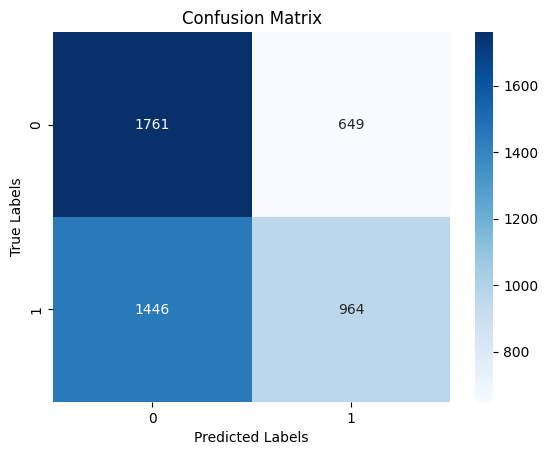



Evaluation Metrics for TextBlob data
139/139 [==============================] - 338s 2s/step
              precision    recall  f1-score   support

           0       0.55      0.62      0.58      2217
           1       0.57      0.49      0.52      2216

    accuracy                           0.56      4433
   macro avg       0.56      0.56      0.55      4433
weighted avg       0.56      0.56      0.55      4433



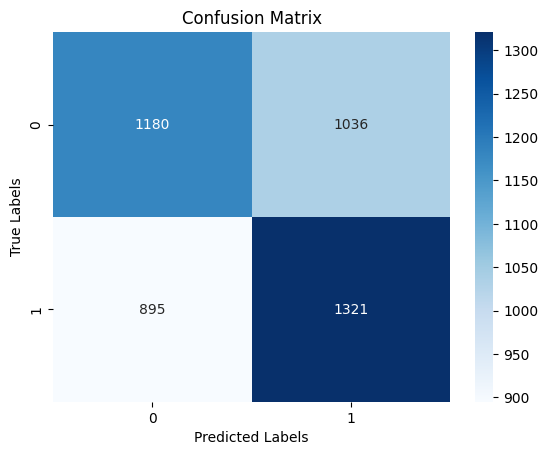

In [21]:
def plot_confusion_matrix(model, val_targets, val_predicted_labels):
    """
    Plot the confusion matrix for the model's predictions on the validation set.

    Args:
        model (tf.keras.models.Model): The trained Keras model.
        val_targets (tf.Tensor): True labels for the validation set.
        val_predicted_labels (np.ndarray): Predicted labels for the validation set.

    Returns:
        None
    """
   
    # Create the confusion matrix
    cm = confusion_matrix(val_targets, val_predicted_labels)

    # Plot the confusion matrix using seaborn
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to plot the confusion matrix _ vader data
print('Evaluation Metrics for VADER data')
# printing classification report
vader_result_proba_after, vader_result_after = test_result(vader_model, datasets_vader, targets_vader)
plot_confusion_matrix(vader_model, vader_val_targets, vader_val_predicted_labels)
print('')
print('')

print('Evaluation Metrics for TextBlob data')
textblob_result_proba_after, textblob_result_after = test_result(textblob_model, datasets_textblob, 
                                                                 targets_textblob) 

plot_confusion_matrix(textblob_model, textblob_val_targets, textblob_val_predicted_labels)

## LSTM Model

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) architecture that is widely used in deep learning for sequence data processing, such as time series data, natural language processing, and speech recognition. 

### Tokenizing Data

In [22]:
def tockenize(data, sentiment_column):
    """
    Performs sentiment analysis on the input data using VADER and TextBlob models.

    Args:
        data (pd.DataFrame): The DataFrame containing the data for sentiment analysis.
        text_column (str): The name of the column containing the text data.
        sentiment_column (str): The name of the column representing the sentiment.
        max_features (int): The maximum number of features to consider for the tokenizer (default is 100,000).
        max_len (int): The maximum length of the sequences after padding (default is 29).
        test_size (float): The proportion of the data to include in the test split (default is 0.2).
        random_state (int): The seed used by the random number generator (default is 42).

    Returns:
        Tuple: A tuple containing the preprocessed training and test data.

    # Sentiment analysis using VADER and TextBlob
    """
    
    text_column='clean_Text'
    max_features=100000
    max_len=29
    random_state=42
    test_size=0.2 
    
    # Separate majority and minority classes
    data_majority = data[data[sentiment_column] == 'Positive']
    data_minority = data[data[sentiment_column] == 'Negative']

    # Split data into train and test sets for both classes
    train_majority, test_majority = train_test_split(data_majority, test_size=test_size, 
                                                     random_state=random_state)
    train_minority, test_minority = train_test_split(data_minority, test_size=test_size, 
                                                     random_state=random_state)

    # Combine the splits for both classes
    train = pd.concat([train_majority, train_minority])
    test = pd.concat([test_majority, test_minority])

    # Shuffle the train and test sets
    train = shuffle(train, random_state=random_state)
    test = shuffle(test, random_state=random_state)

    print('positive data in training:', (train[sentiment_column] == 'Positive').sum())
    print('negative data in training:', (train[sentiment_column] == 'Negative').sum())
    print('positive data in test:', (test[sentiment_column] == 'Positive').sum())
    print('negative data in test:', (test[sentiment_column] == 'Negative').sum())

    # Tokenize and pad data
    tokenizer = Tokenizer(num_words=max_features, split=' ')
    tokenizer.fit_on_texts(data[text_column].values)

    X_train = tokenizer.texts_to_sequences(train[text_column].values)
    X_train = pad_sequences(X_train, maxlen=max_len)
    y_train = pd.get_dummies(train[sentiment_column]).values

    X_test = tokenizer.texts_to_sequences(test[text_column].values)
    X_test = pad_sequences(X_test, maxlen=max_len)
    y_test = pd.get_dummies(test[sentiment_column]).values

    return (X_train, y_train), (X_test, y_test)

# tockenize vader data
(X_train_vader, y_train_vader), (X_test_vader, y_test_vader) = tockenize(vader_data, 'VADER_Sentiments')

# tockenize textblob data
(X_train_textblob, y_train_textblob), (X_test_textblob, y_test_textblob) = tockenize(textblob_data, 
                                                                                     'TextBlob_Sentiments')

positive data in training: 19279
negative data in training: 19279
positive data in test: 4820
negative data in test: 4820
positive data in training: 17728
negative data in training: 17728
positive data in test: 4433
negative data in test: 4433


### Initializing the Model and Defining Hyperparameters

The code below defines a function called create_lstm_model that constructs a Long Short-Term Memory (LSTM) model for binary classification tasks.

In [27]:
def create_lstm_model(input_length):
    """
    Creates an LSTM model with the specified parameters.

    Args:
        max_features (int): The maximum number of features for the Embedding layer.
        embed_dim (int): The dimensionality of the dense embeddings in the Embedding layer.
        lstm_out (int): The number of LSTM units in the LSTM layer.
        input_length (int): The length of the input sequences.

    Returns:
        keras.models.Sequential: The compiled LSTM model.

    # Add Embedding layer
    # Add SpatialDropout1D layer to reduce overfitting
    # Add LSTM layer with dropout and recurrent dropout to reduce overfitting
    # Add Dense output layer with softmax activation for binary classification (2 classes)
    # Compile the model
    # Print model summary to inspect the layers and parameters
    """
    
    # Define hyperparameters
    embed_dim = 128
    lstm_out = 192
    max_features = 100000

    # Create the LSTM model
    model_lstm = Sequential()

    # Add Embedding layer
    model_lstm.add(Embedding(max_features, embed_dim, input_length=input_length))

    # Add SpatialDropout1D layer to reduce overfitting
    model_lstm.add(SpatialDropout1D(0.4))

    # Add LSTM layer with dropout and recurrent dropout to reduce overfitting
    model_lstm.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))

    # Add Dense output layer with softmax activation for binary classification (2 classes)
    model_lstm.add(Dense(2, activation='softmax'))

    # Compile the model
    model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print model summary to inspect the layers and parameters
    print(model_lstm.summary())
    return model_lstm

# Call the function to create the LSTM model
model_lstm_vader = create_lstm_model(X_train_vader.shape[1])

# Call the function to create the LSTM model
model_lstm_textblob = create_lstm_model(X_train_textblob.shape[1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 29, 128)           12800000  
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 29, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 192)               246528    
                                                                 
 dense_4 (Dense)             (None, 2)                 386       
                                                                 
Total params: 13,046,914
Trainable params: 13,046,914
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_3"
_________________________________________________________________
 Layer (type)  

### Fit and Train the LSTM Model

In [24]:
def fit_lstm_model(model, X_train, y_train, X_test, y_test):
    """
    Fits the LSTM model with the specified parameters.

    Args:
        model (keras.models.Sequential): The LSTM model.
        X_train (numpy.array): The training input data.
        y_train (numpy.array): The training target data.
        X_test (numpy.array): The test input data.
        y_test (numpy.array): The test target data.
        batch_size (int): The batch size for training.
        epochs (int): The number of training epochs.

    Returns:
        keras.models.Sequential: The fitted LSTM model.

    # Define class weights based on the bias
    # Fit the model on the training data and validate on the test data
    """
    # Define class weights based on the bias
    bias = y_train.sum(axis=0)[0] / y_train.sum(axis=0)[1]
    class_weights = {0: 1, 1: 1.6 / bias}

    # Fit the model on the training data and validate on the test data
    history = History()
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1,
              class_weight=class_weights, validation_data=(X_test, y_test), callbacks=[history],
              steps_per_epoch=50)

    return model

# Define hyperparameters
batch_size = 128
epochs = 15
    
print('Fitting lstm on VADER DATA')
# Call the function to fit the LSTM model with the specified hyperparameters - vader data
model_lstm_vader = fit_lstm_model(model_lstm_vader, 
                                  X_train_vader, 
                                  y_train_vader, 
                                  X_test_vader, 
                                  y_test_vader)

print('')
print('')
print('Fitting lstm on TextBlob DATA')
# Call the function to fit the LSTM model with the specified hyperparameters - textblob
model_lstm_textblob = fit_lstm_model(model_lstm_textblob, 
                                  X_train_textblob, 
                                  y_train_textblob, 
                                  X_test_textblob, 
                                  y_test_textblob)

Fitting lstm on VADER DATA
Epoch 1/15
50/50 [==============================] - 46s 878ms/step - loss: 0.8584 - accuracy: 0.4914 - val_loss: 0.6810 - val_accuracy: 0.5367
Epoch 2/15
50/50 [==============================] - 43s 861ms/step - loss: 0.7478 - accuracy: 0.6338 - val_loss: 0.5886 - val_accuracy: 0.6793
Epoch 3/15
50/50 [==============================] - 43s 867ms/step - loss: 0.6188 - accuracy: 0.7527 - val_loss: 0.4592 - val_accuracy: 0.7678
Epoch 4/15
50/50 [==============================] - 43s 857ms/step - loss: 0.5416 - accuracy: 0.7903 - val_loss: 0.4048 - val_accuracy: 0.8032
Epoch 5/15
50/50 [==============================] - 43s 867ms/step - loss: 0.4751 - accuracy: 0.8211 - val_loss: 0.3606 - val_accuracy: 0.8266
Epoch 6/15
50/50 [==============================] - 43s 868ms/step - loss: 0.4401 - accuracy: 0.8383 - val_loss: 0.3275 - val_accuracy: 0.8505
Epoch 7/15
50/50 [==============================] - 43s 867ms/step - loss: 0.2854 - accuracy: 0.9027 - val_loss: 0.

### Evaluating the LSTM Model

Evaluate the LSTM model Using Vader data
76/76 [==============================] - 7s 86ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      4820
           1       0.84      0.93      0.88      4820

    accuracy                           0.88      9640
   macro avg       0.88      0.88      0.88      9640
weighted avg       0.88      0.88      0.88      9640



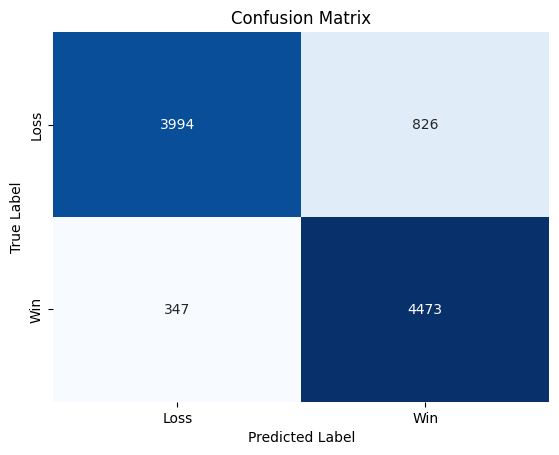



Evaluate the LSTM model Using TextBlob data
70/70 [==============================] - 6s 87ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      4433
           1       0.86      0.91      0.88      4433

    accuracy                           0.88      8866
   macro avg       0.88      0.88      0.88      8866
weighted avg       0.88      0.88      0.88      8866



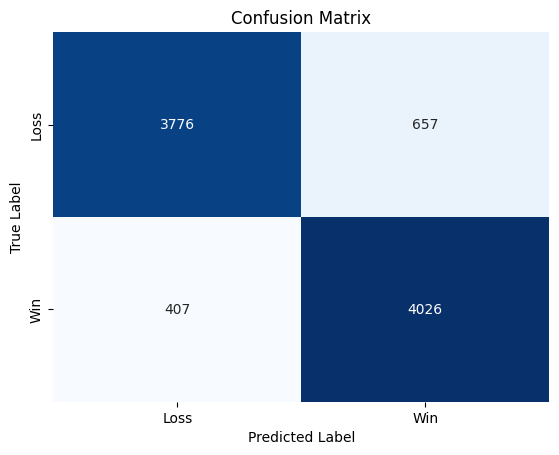

In [25]:
# VADER DATA LSTM model evaluation
# Accuracy and loss on test data for the VADER LSTM model
acc_vader = model_lstm_vader.history.history['accuracy']
val_acc_vader = model_lstm_vader.history.history['val_accuracy']
loss_vader = model_lstm_vader.history.history['loss']
val_loss_vader = model_lstm_vader.history.history['val_loss']

# TextBlob LSTM model evaluation
# Accuracy and loss on test data for the TextBlob LSTM model
acc_textblob = model_lstm_textblob.history.history['accuracy']
val_acc_textblob = model_lstm_textblob.history.history['val_accuracy']
loss_textblob = model_lstm_textblob.history.history['loss']
val_loss_textblob = model_lstm_textblob.history.history['val_loss']

# define a function to evaluate and print evaluation metrics
def evaluate_model(model, X_test, y_test, batch_size):
    """
    Evaluates the LSTM model using test data and prints evaluation metrics.

    Args:
        model (keras.models.Sequential): The fitted LSTM model.
        X_test (numpy.array): The test input data.
        y_test (numpy.array): The test target data.
        batch_size (int): The batch size for predictions.

    Returns:
        None

    # Calculate accuracy and loss on test data
    # Make predictions on test data
    # Calculate and print confusion matrix and classification report
    """

    # Make predictions on test data
    y_pred = np.argmax(model.predict(X_test, batch_size=batch_size), axis=1)

    # Create a DataFrame with true and predicted labels
    df_test = pd.DataFrame({'true': np.argmax(y_test, axis=1), 'pred': y_pred})

    # Print confusion matrix and classification report
    print("\nClassification Report:")
    print(classification_report(df_test.true, df_test.pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(df_test.true, df_test.pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
# Call the function to evaluate the model - Vader data
print('Evaluate the LSTM model Using Vader data')
evaluate_model(model_lstm_vader, X_test_vader, y_test_vader, batch_size=batch_size)

# Call the function to evaluate the model - TextBlob data
print('')
print('')
print('Evaluate the LSTM model Using TextBlob data')
evaluate_model(model_lstm_textblob, X_test_textblob, y_test_textblob, batch_size=batch_size)

### Plotting the Training and Validation Accuracy and Training and Validation Loss

Plot Accuracy for the LSTM model Using Vader data


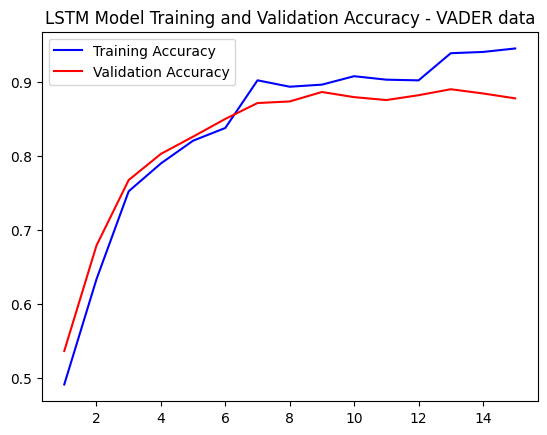

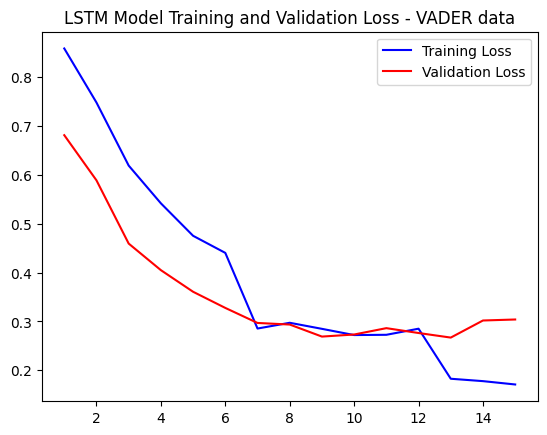





Plot Accuracy for LSTM model Using TextBlob data


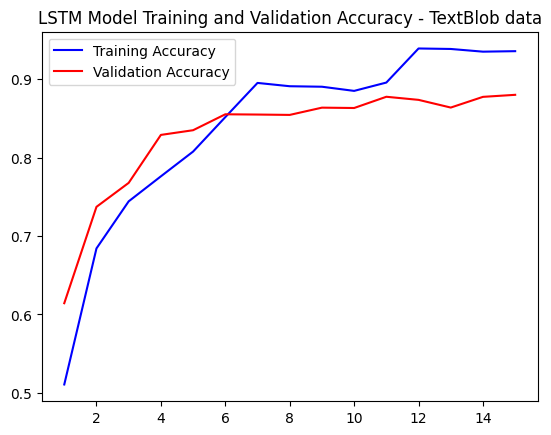

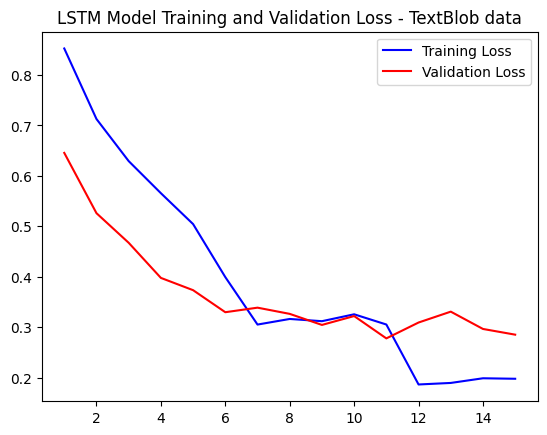

In [26]:
def plot_accuracy(epochs, acc, val_acc, loss, val_loss, sentiment_model):
    """
    Plots the accuracy and loss curves for an LSTM model.

    Args:
        acc (list): List of training accuracy values over epochs.
        val_acc (list): List of validation accuracy values over epochs.
        loss (list): List of training loss values over epochs.
        val_loss (list): List of validation loss values over epochs.
        sentiment_model (str): Name or identifier of the sentiment model.

    Returns:
        None

    This function plots the training and validation accuracy curves on one plot and
    the training and validation loss curves on another plot. It uses the provided lists
    of accuracy and loss values along with the specified sentiment model name to create
    informative and labeled plots.

    Example Usage:
        plot_accuracy(acc, val_acc, loss, val_loss, 'VADER LSTM Model')
    """
    # Plot accuracy and loss curves
    plt.plot(epochs, acc, 'b', label='Training Accuracy', color='blue')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', color='red')
    plt.title(f'LSTM Model Training and Validation Accuracy {sentiment_model}')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training Loss', color='blue')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss', color='red')
    plt.title(f'LSTM Model Training and Validation Loss {sentiment_model}')
    plt.legend()
    plt.show()
    
# Call the function to evaluate the model - Vader data
print('Plot Accuracy for the LSTM model Using Vader data')
epoch = range(1, len(acc_vader) + 1)
plot_accuracy(epoch, acc_vader, val_acc_vader, loss_vader, val_loss_vader, '- VADER data')

# Call the function to evaluate the model - TextBlob data
print('')
print('')
print('\n\nPlot Accuracy for LSTM model Using TextBlob data')
epoch = range(1, len(acc_textblob) + 1)
plot_accuracy(epoch, acc_textblob, val_acc_textblob, loss_textblob, val_loss_textblob, '- TextBlob data')

# Choosing the Best Model to Predict Elections

## Evaluation Metrics for Logistic Regression

| Evaluation for VADER data       | precision | recall | f1-score | support |
|--------------------------------|-----------|--------|----------|---------|
| 0                              | 0.50      | 0.22   | 0.31     | 4820    |
| 1                              | 0.62      | 0.85   | 0.72     | 7178    |
| accuracy                       | 0.60      |        |          | 11998   |
| macro avg                      | 0.56      | 0.54   | 0.51     | 11998   |
| weighted avg                   | 0.57      | 0.60   | 0.55     | 11998   |

<br>

| Evaluation for TextBlob data    | precision | recall | f1-score | support |
|--------------------------------|-----------|--------|----------|---------|
| 0                              | 0.55      | 0.15   | 0.23     | 4433    |
| 1                              | 0.65      | 0.93   | 0.76     | 7565    |
| accuracy                       | 0.64      |        |          | 11998   |
| macro avg                      | 0.60      | 0.54   | 0.50     | 11998   |
| weighted avg                   | 0.61      | 0.64   | 0.57     | 11998   |



## Evaluation Metriects for BERT


| Evaluation Metrics for VADER data | precision | recall | f1-score | support |
|----------------------------------|-----------|--------|----------|---------|
| 0                                | 0.54      | 0.61   | 0.57     | 2410    |
| 1                                | 0.55      | 0.48   | 0.51     | 2410    |
| accuracy                         | 0.54      |        |          | 4820    |
| macro avg                        | 0.55      | 0.54   | 0.54     | 4820    |
| weighted avg                     | 0.55      | 0.54   | 0.54     | 4820    |


<br>

| Evaluation Metrics for TextBlob data | precision | recall | f1-score | support |
|--------------------------------------|-----------|--------|----------|---------|
| 0                                    | 0.55      | 0.62   | 0.58     | 2217    |
| 1                                    | 0.57      | 0.49   | 0.52     | 2216    |
| accuracy                             | 0.56      |        |          | 4433    |
| macro avg                            | 0.56      | 0.56   | 0.55     | 4433    |
| weighted avg                         | 0.56      | 0.56   | 0.55     | 4433    |


## Evaluation Metrics for LSTM

| Evaluate the LSTM model Using Vader data | precision | recall | f1-score | support |
|-----------------------------------------|-----------|--------|----------|---------|
| 0                                       | 0.92      | 0.83   | 0.87     | 4820    |
| 1                                       | 0.84      | 0.93   | 0.88     | 4820    |
| accuracy                                | 0.88      |        |          | 9640    |
| macro avg                               | 0.88      | 0.88   | 0.88     | 9640    |
| weighted avg                            | 0.88      | 0.88   | 0.88     | 9640    |


Br>

| Evaluate the LSTM model Using TextBlob data | precision | recall | f1-score | support |
|--------------------------------------------|-----------|--------|----------|---------|
| 0                                          | 0.90      | 0.85   | 0.88     | 4433    |
| 1                                          | 0.86      | 0.91   | 0.88     | 4433    |
| accuracy                                   | 0.88      |        |          | 8866    |
| macro avg                                  | 0.88      | 0.88   | 0.88     | 8866    |
| weighted avg                               | 0.88      | 0.88   | 0.88     | 8866    |



## Final Model Selected

Based on the evaluation metrics above, we can observe the following:

* Logistic Regression Model:

The model's accuracy for the VADER dataset is 60.00% and 64.00% for the TextBlob dataset.
Precision, recall, and F1-score for both classes (0 and 1) are lower compared to other models.

* BERT Model:

The model's accuracy for the VADER dataset is 54.00% and 56.00% for the TextBlob dataset.
Precision, recall, and F1-score for both classes (0 and 1) are also relatively lower compared to other models.

* LSTM Model:

The LSTM model achieves the highest accuracy of 88.00% for both the VADER and TextBlob datasets.
Precision, recall, and F1-score for both classes (0 and 1) are higher compared to the other models.

Based on the metrics, the LSTM model outperforms both the Logistic Regression and BERT models in terms of accuracy and the precision, recall, and F1-scores for classifying sentiment in social media posts about the 2023 Nigerian Presidential election. **Therefore, the LSTM model was considered the best-performing model for predicting elections in this specific context.**

# Using the Best Model to Predict Elections Using Tweets

Using LSTM, we will predict the labels of the tweets in the validation data called "final_prediction" then plot a grouped bar plot. The results will then be compared to the real life situation, and the best sentiment pretrained model will be selected.  

### Loading the Validation Data

In [508]:
# Loading the final predicting data
pred_data = pd.read_csv('final_prediction.csv')

# drop nulls
pred_data = pred_data.dropna()

# value counts of candidates
pred_data.candidate.value_counts()

PeterObi     3085
Atiku        2685
Tinubu       2657
Kwankwaso    1572
Name: candidate, dtype: int64

### Balancing the Number of Tweets Per Candidate

Bacause we want to validate our model, we will take equal number of tweets per candidate, so that we can be able to know which model predicts the win accurately.

In [509]:
# Get the value_counts of candidate names to get tweet counts for each candidate
candidate_counts = pred_data['candidate'].value_counts()

# Find the minimum tweet count among candidates
min_tweet_count = candidate_counts.min()

# Filter pred_data to include only same number of tweets as minimum tweet count for all candidates
equal_tweets_data = pred_data.groupby('candidate').head(min_tweet_count)

# Reset the index of the resulting DataFrame
equal_tweets_data.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame with equal tweet counts for all candidates
pred_data = equal_tweets_data.copy()

# value counts of candidates
pred_data.candidate.value_counts()

PeterObi     1572
Tinubu       1572
Atiku        1572
Kwankwaso    1572
Name: candidate, dtype: int64

As we can see we use 1572 tweets per candidate. So the one with more wins indicates that they won.

### Step 1: Preprocess the data

In [510]:
# Tockenizing data
# VADER data
final_pred_sequences_vader = tokenizer_vader.texts_to_sequences(pred_data['clean_Text'].values)
max_len = 29  # The maximum sequence length used during training
final_pred_sequences_padded_vader = pad_sequences(final_pred_sequences_vader, maxlen=max_len)

# TextBlob Data
final_pred_sequences_textblob = tokenizer_textblob.texts_to_sequences(pred_data['clean_Text'].values)
max_len = 29  # The maximum sequence length used during training
final_pred_sequences_padded_textblob = pad_sequences(final_pred_sequences_textblob, maxlen=max_len)

### Step 2: Make predictions

In [511]:
# Predict the sentiment on the preprocessed 'FINAL_PRED' data using the loaded LSTM model
# using VADER model
print('Prediction Using Vader Model')
predictions_vader = model_lstm_vader.predict(final_pred_sequences_padded_vader)
print('')

# Using TextBlob model
print('Prediction Using TextBlob Model')
predictions_textblob = model_lstm_textblob.predict(final_pred_sequences_padded_textblob)

Prediction Using Vader Model
197/197 [==============================] - 4s 20ms/step

Prediction Using TextBlob Model
197/197 [==============================] - 4s 19ms/step


### Step 3: Convert probabilities to binary predictions

#### 3a. VADER data

In [512]:
# Take the class with the highest probability as the predicted class (1 or 0)
binary_predictions_vader = np.argmax(predictions_vader, axis=1)

# Add the binary predictions as a new column to the 'FINAL_PRED' DataFrame
pred_data['VaderSent_Pred'] = binary_predictions_vader

# Display the final DataFrame with predicted sentiment
pred_data.head(5)

,created_at,candidate,clean_Text,VaderSent_Pred
0,2023-01-08 23:28:14+00:00,PeterObi,keeping dreaming,1
1,2023-01-03 20:40:21+00:00,PeterObi,you want thank smallie empress njamah kaduna s...,0
2,2023-02-03 23:22:12+00:00,Tinubu,for better country generations come supporting...,1
3,2023-01-14 23:42:14+00:00,PeterObi,na mouth ogah bring prove dat peter obi stole ...,1
4,2023-02-04 23:08:40+00:00,Tinubu,ok yo tinubu win abi keep waitin northern vote...,0


#### 3b. TextBlob data

In [513]:
# Take the class with the highest probability as the predicted class (1 or 0)
binary_predictions_textblob = np.argmax(predictions_textblob, axis=1)

# Add the binary predictions as a new column to the 'FINAL_PRED' DataFrame
pred_data['textblob_Sent_Pred'] = binary_predictions_textblob

# Display the final DataFrame with predicted sentiment
pred_data.head(5)

,created_at,candidate,clean_Text,VaderSent_Pred,textblob_Sent_Pred
0,2023-01-08 23:28:14+00:00,PeterObi,keeping dreaming,1,1
1,2023-01-03 20:40:21+00:00,PeterObi,you want thank smallie empress njamah kaduna s...,0,0
2,2023-02-03 23:22:12+00:00,Tinubu,for better country generations come supporting...,1,1
3,2023-01-14 23:42:14+00:00,PeterObi,na mouth ogah bring prove dat peter obi stole ...,1,1
4,2023-02-04 23:08:40+00:00,Tinubu,ok yo tinubu win abi keep waitin northern vote...,0,1


### Step 4: Convert the Binary to Yes or No

In [514]:
# Define inverse mapping function to convert numerical labels to sentiment labels
inverse_sentiment_map = {1: 'Yes', 0: 'No'}

# apply mapping e-12qifunction to sentiment column - vader data
pred_data['VADER_Sentiment_labels'] = pred_data['VaderSent_Pred'].map(inverse_sentiment_map)

# apply mapping function to sentiment column - TextBlob data
pred_data['TextBlob_Sentiment_labels'] = pred_data['textblob_Sent_Pred'].map(inverse_sentiment_map)

# drop column
pred_data.drop(['VaderSent_Pred', 'textblob_Sent_Pred'], axis=1, inplace=True)

# overview 
pred_data.head(5)

,created_at,candidate,clean_Text,VADER_Sentiment_labels,TextBlob_Sentiment_labels
0,2023-01-08 23:28:14+00:00,PeterObi,keeping dreaming,Yes,Yes
1,2023-01-03 20:40:21+00:00,PeterObi,you want thank smallie empress njamah kaduna s...,No,No
2,2023-02-03 23:22:12+00:00,Tinubu,for better country generations come supporting...,Yes,Yes
3,2023-01-14 23:42:14+00:00,PeterObi,na mouth ogah bring prove dat peter obi stole ...,Yes,Yes
4,2023-02-04 23:08:40+00:00,Tinubu,ok yo tinubu win abi keep waitin northern vote...,No,Yes


### Step 5: Bar Plot to Choose the Pretrained Models

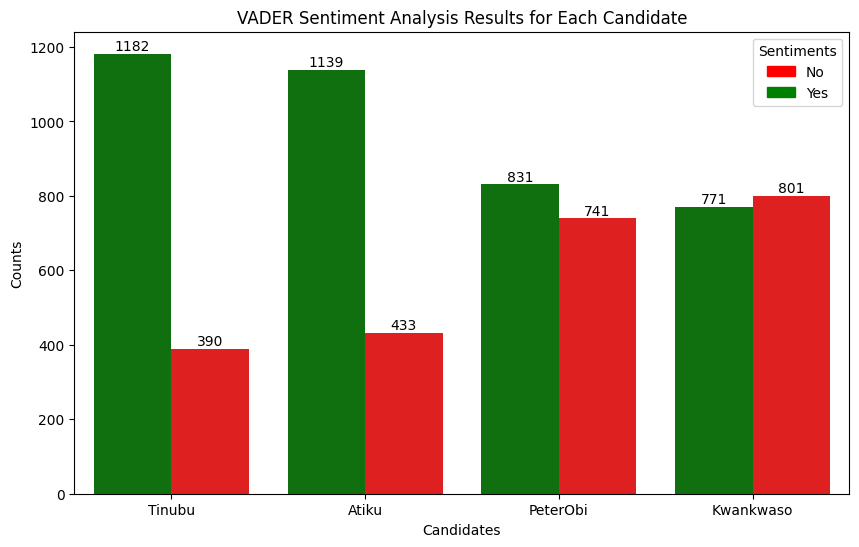

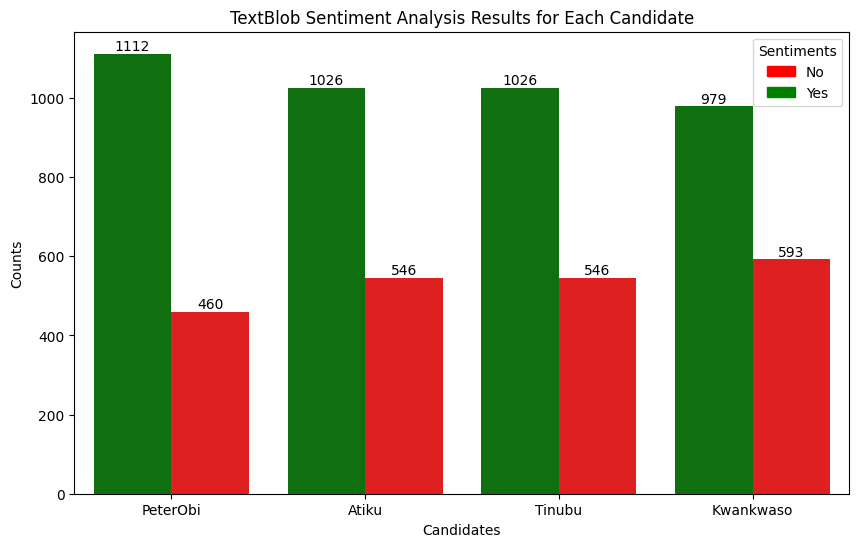

In [515]:
def plot_grouped_sentiment_analysis(df, candidate_column, sentiment_column, library):
    """
    Generates a grouped bar plot of sentiment analysis results for each candidate based on a specified 
    sentiment column in a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing sentiment analysis results for all candidates.
    - candidate_column (str): The name of the column containing the candidate names.
    - sentiment_column (str): The name of the column containing the sentiment labels.
    - library (str): The name of the sentiment analysis library used (e.g., 'VADER', 'TextBlob').

    Description:
    The 'plot_grouped_sentiment_analysis' function takes a DataFrame, a candidate column, a sentiment 
    column, and the sentiment analysis library used as input and generates a grouped bar plot 
    representing the sentiment analysis results for each candidate. 
    The grouped bar plot shows the count of each sentiment category for each candidate side by side.

    The function calculates the count of each sentiment category for each candidate and creates a 
    grouped bar plot with different colors for each sentiment category for each candidate. 
    The sentiment categories are 'Negative', 'Neutral', and 'Positive'.

    The plot appearance is customized with labels, title indicating the sentiment analysis library 
    used, grid lines, and a legend for each sentiment category.
    """
        
    # Calculate count of sentiments for each candidate and reset the index
    grouped_counts = df.groupby([candidate_column, sentiment_column]).size().unstack(fill_value=0)
    
    # Convert candidate names back to a regular column
    grouped_counts.reset_index(inplace=True) 
    
    # Melt the DataFrame to transform columns to variables for better plotting
    grouped_counts_melted = pd.melt(grouped_counts, id_vars=candidate_column, var_name='Sentiments', 
                                    value_name='Counts')
    
    # Sort the grouped counts by the count of positive sentiment in descending order
    grouped_counts_melted = grouped_counts_melted.sort_values(by='Counts', ascending=False)
    
    # Define custom colors for 'Negative' and 'Positive' sentiments
    custom_colors = {'No': 'red', 'Yes': 'green'}
    
    # Plot the grouped bar plot using seaborn and the custom color palette
    plt.figure(figsize=(10, 6))
    sns.barplot(data=grouped_counts_melted, x=candidate_column, y='Counts', hue='Sentiments', 
                palette=custom_colors)

    # Customize the plot appearance
    plt.xlabel('Candidates')
    plt.ylabel('Counts')
    plt.title(f'{library} Sentiment Analysis Results for Each Candidate')

    # Create custom legend patches for each sentiment category
    legend_patches = [mpatches.Patch(color=color, label=sentiment) for sentiment, color in 
                      custom_colors.items()]

    # Add the custom legend to the plot
    plt.legend(handles=legend_patches, title='Sentiments', bbox_to_anchor=(1, 1))

    # Annotate bars with the count values on top
    for p in plt.gca().patches:
        plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# For vader data
plot_grouped_sentiment_analysis(pred_data, 'candidate', 'VADER_Sentiment_labels', 'VADER')

# For TextBlob
plot_grouped_sentiment_analysis(pred_data, 'candidate', 'TextBlob_Sentiment_labels', 'TextBlob')

According to https://www.stears.co/elections/2023/president/, the Nigerian elections results were as follows:

* Tinubu Bola Ahmed ganered 8,794,726 votes, 36.61%, followed by,
* Abubakar Atiku with 6,984,520 votes which is 29.07%, followed by,
* Obi Peter Gregory with 6,101,533 votes which is 25.40% and then,
* Musa Mohammed Rabiu Kwankwaso with 1,496,687 votes which is 6.23%.

**Therefore, from the above plots, we can say the VADER data predicted accurately. We therefore conclude that the best pretrained model for labeling our tweets in readiness for machine learning is VADER model.**



## Visualizations With the Chosen Model and Pretrained Model

### Loading, Preprocessing and Predicting the Entire Dataset

In [540]:
# drop nulls
combined_df2 = combined_df.dropna()

# Get the value_counts of candidate names to get tweet counts for each candidate
candidate_counts2 = combined_df2['candidate'].value_counts()

# Find the minimum tweet count among candidates
min_tweet_count2 = candidate_counts2.min()

# Filter pred_data to include only same number of tweets as minimum tweet count for all candidates
equal_tweets_data2 = combined_df2.groupby('candidate').head(min_tweet_count2)

# Reset the index of the resulting DataFrame
equal_tweets_data2.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame with equal tweet counts for all candidates
combined_df2 = equal_tweets_data2.copy()

# Tockenizing data
# VADER data
final_pred_sequences_vader2 = tokenizer_vader.texts_to_sequences(combined_df2['clean_Text'].values)
max_len = 29  # The maximum sequence length used during training
final_pred_sequences_padded_vader2 = pad_sequences(final_pred_sequences_vader2, maxlen=max_len)

# Predict the sentiment on the preprocessed 'FINAL_PRED' data using the loaded LSTM model
# using VADER model
print('Prediction Using Vader Model')
predictions_vader2 = model_lstm_vader.predict(final_pred_sequences_padded_vader2)

# Take the class with the highest probability as the predicted class (1 or 0)
binary_predictions_vader2 = np.argmax(predictions_vader2, axis=1)

# Add the binary predictions as a new column to the 'FINAL_PRED' DataFrame
combined_df2['VaderSent_Pred'] = binary_predictions_vader2

# Define inverse mapping function to convert numerical labels to sentiment labels
inverse_sentiment_map = {1: 'Yes', 0: 'No'}

# apply mapping e-12qifunction to sentiment column - vader data
combined_df2['VADER_Sentiment_labels'] = combined_df2['VaderSent_Pred'].map(inverse_sentiment_map)

# drop column
combined_df2.drop(['VaderSent_Pred'], axis=1, inplace=True)

Prediction Using Vader Model
2566/2566 [==============================] - 36s 14ms/step


### 1. Bar Plot for Yes and No Votes For All Candidates

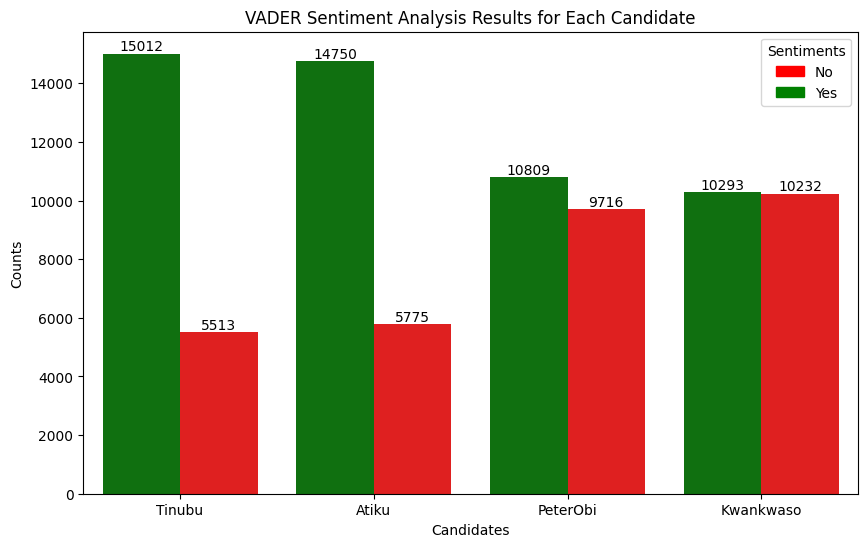

In [541]:
# plot the bar plot
plot_grouped_sentiment_analysis(combined_df2, 'candidate', 'VADER_Sentiment_labels', 'VADER')

### Pie Chart for Yes Votes For All Candidates

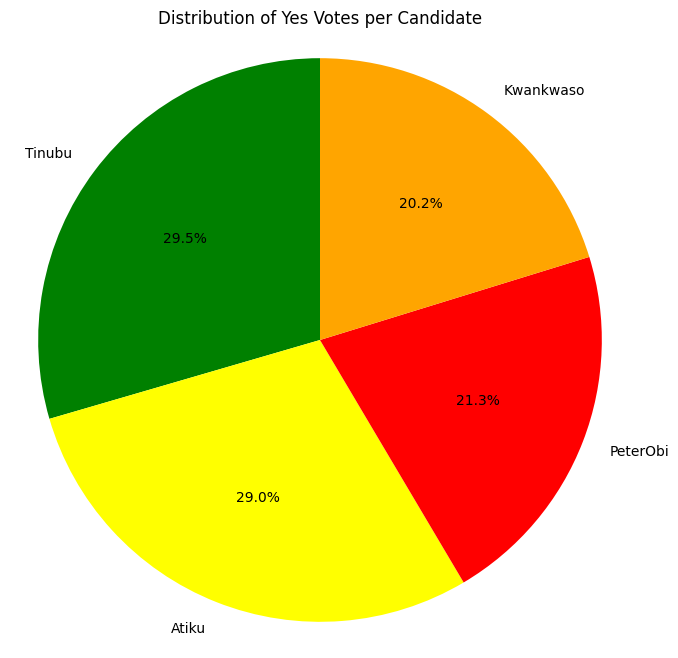

In [542]:
# Select only the data with 'Yes' votes
combined_df_no_votes = combined_df2[combined_df2['VADER_Sentiment_labels'] == 'No']

# Count the occurrences of 'Yes' votes per candidate
yes_votes_per_candidate = combined_df_yes_votes['candidate'].value_counts()

# Create a list of colors (all green) for the pie chart slices
colors = ['green', 'yellow', 'red', 'orange'] * len(yes_votes_per_candidate)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(yes_votes_per_candidate, labels=yes_votes_per_candidate.index, colors=colors, 
        autopct='%1.1f%%', startangle=90)

# Add a title to the pie chart
plt.title('Distribution of Yes Votes per Candidate')

# Display the pie chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Pie Chart for No Votes For All Candidates

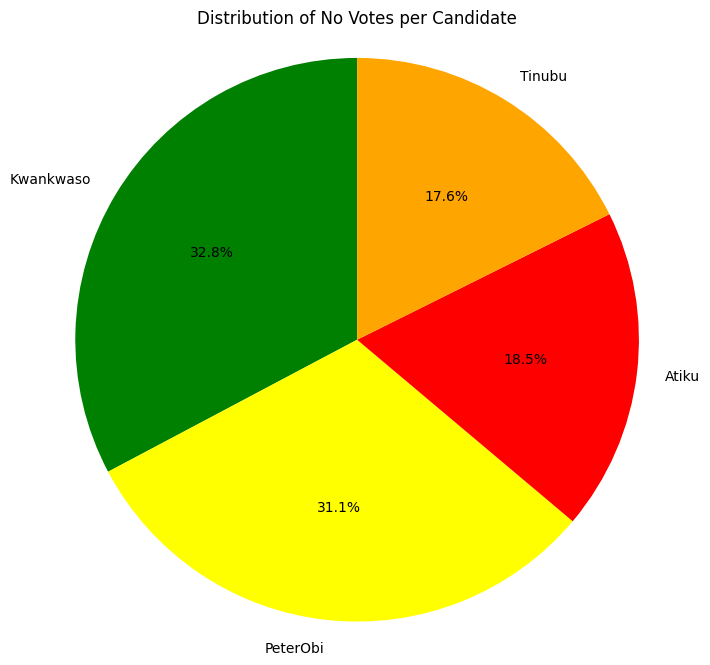

In [543]:
# Select only the data with 'no' votes
combined_df_no_votes = combined_df2[combined_df2['VADER_Sentiment_labels'] == 'No']

# Count the occurrences of 'no' votes per candidate
no_votes_per_candidate = combined_df_no_votes['candidate'].value_counts()

# Create a list of colors (all green) for the pie chart slices
colors = ['green', 'yellow', 'red', 'orange'] * len(no_votes_per_candidate)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(no_votes_per_candidate, labels=no_votes_per_candidate.index, colors=colors, autopct='%1.1f%%', startangle=90)

# Add a title to the pie chart
plt.title('Distribution of No Votes per Candidate')

# Display the pie chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Research Questions

### 1. What is the nature and extent of sentiment expressed on social media regarding the 2023 Nigerian Presidential election, and how does this relate to the official election results? Furthermore, what is the overall sentiment about the candidate who is contesting the results announced?

**Nature and Extent of Sentiment Expressed on Social Media:**

* The sentiment labels predicted on social media are divided into two categories: 'Yes' and 'No'.
* The sentiment prediction results indicate that there were more 'Yes' sentiments for all candidates compared to 'No' sentiments. This suggests that, overall, social media expressed more positive sentiment towards all the candidates during the 2023 Nigerian Presidential election.
* The counts for each sentiment label for each candidate are as follows:

| candidate   |  Tinubu |   Atiku     |   PeterObi |Kwankwaso |
|:------------|--------:|------------:|-----------:|---------:|
| Yes         |   15012 |       14750 |      10809 |    10293 |
| No          |    5513 |        5575 |       9716 |    10232 |





**Relation to Official Election Results:**

The official election results show the percentage of votes each candidate received as follows:

Tinubu Bola Ahmed: 36.61%
Abubakar Atiku: 29.07%
Obi Peter Gregory: 25.40%
Musa Mohammed Rabiu Kwankwaso: 6.23%

By comparing the sentiment prediction results with the official election results, we can observe the following:

* The candidate with the highest number of 'Yes' (positive) sentiments on social media is Tinubu, which aligns with the fact that Tinubu received the highest percentage of votes (36.61%) in the official election results.
* The candidate with the second-highest number of 'Yes' (positive) sentiments on social media is Atiku, which also aligns with the fact that Atiku received the second-highest percentage of votes (29.07%) in the official election results.
* The candidate with the third-highest number of 'Yes' (positive) sentiments on social media is PeterObi, which aligns with the fact that PeterObi received the third-highest percentage of votes (25.40%) in the official election results.
* The candidate with the lowest number of 'Yes' (positive) sentiments on social media is Kwankwaso, which aligns with the fact that Kwankwaso received the lowest percentage of votes (6.23%) in the official election results.

Overall, the sentiment expressed on social media seems to reflect the actual election results to some extent. Candidates who received higher percentages of votes also tended to have more positive sentiments on social media.

**Overall Sentiment About the Candidate Contesting the Results:**

The candidate who contested the election was Atiku. According to the sentiment prediction results, Atiku received the highest number of 'Yes' (positive) sentiments on social media, with 14,750 'Yes' votes. This indicates that the overall sentiment about Atiku on social media was mostly positive.


### 2. How did the sentiment towards the candidates and the electoral process expressed on social media evolve, and what factors contributed to these changes?

In [544]:
# 'created_at' is in string format, convert it to datetime and remove the time part
combined_df2['created_at'] = pd.to_datetime(combined_df2['created_at']).dt.date

# Define the target date (February 25, 2023) as a date without the time part
target_date = pd.to_datetime("2023-02-25").date()

# Calculate the number of weeks to the target date for each row
combined_df2['weeks_to_elections'] = (target_date - combined_df2['created_at']).dt.days // 7

# Separate dataframes based on 'weeks_to_target' conditions
# Over 8 weeks to elections
df_8_or_more = combined_df2[combined_df2['weeks_to_elections'] >= 8]

# 6 to 8 weeks to Elections
df_6_to_8 = combined_df2[(combined_df2['weeks_to_elections'] >= 6) & 
                            (combined_df2['weeks_to_elections'] < 8)]

# 4 to 6 Weeks to Elections
df_4_to_6 = combined_df2[(combined_df2['weeks_to_elections'] >= 4) & 
                            (combined_df2['weeks_to_elections'] < 6)]

# 2 to 4 Weeks to Elections
df_2_to_4 = combined_df2[(combined_df2['weeks_to_elections'] >= 2) & 
                            (combined_df2['weeks_to_elections'] < 4)]

# less tha 2 weeks
df_less_than_2 = combined_df2[combined_df2['weeks_to_elections'] < 2]

### 2a. Over 8 Weeks to Elections

Over 8 Weeks to Elections


candidate  VADER_Sentiment_labels
Atiku      No                        1098
           Yes                       2672
Kwankwaso  No                        1658
           Yes                       1476
PeterObi   No                        1844
           Yes                       1961
Tinubu     No                         996
           Yes                       2807
dtype: int64

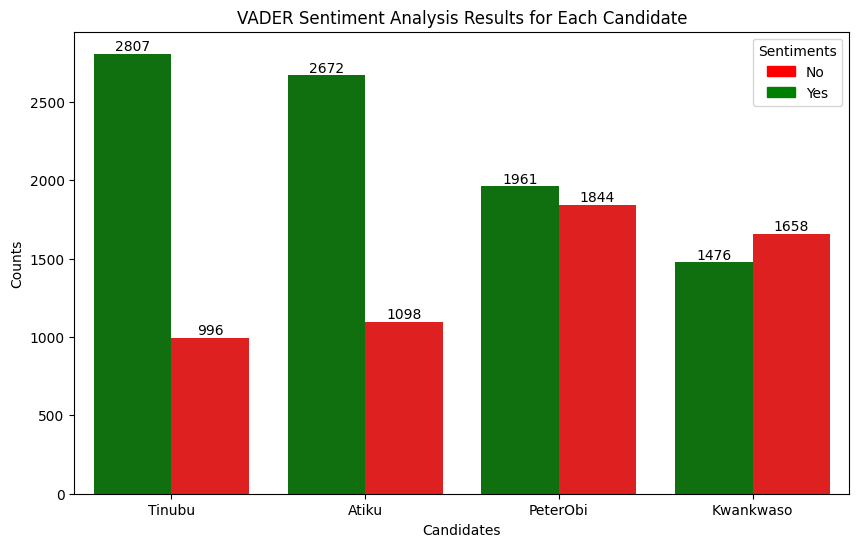

In [545]:
# plot the bar plot
plot_grouped_sentiment_analysis(df_8_or_more, 'candidate', 'VADER_Sentiment_labels', 'VADER')

# printing value counts
print('Over 8 Weeks to Elections')
df_8_or_more.groupby(['candidate', 'VADER_Sentiment_labels']).size()

### 2b. 6 to 8 weeks to Elections

6 to 8 weeks to Elections


candidate  VADER_Sentiment_labels
Atiku      No                        1271
           Yes                       3167
Kwankwaso  No                        1954
           Yes                       1958
PeterObi   No                        2132
           Yes                       2342
Tinubu     No                        1255
           Yes                       3269
dtype: int64

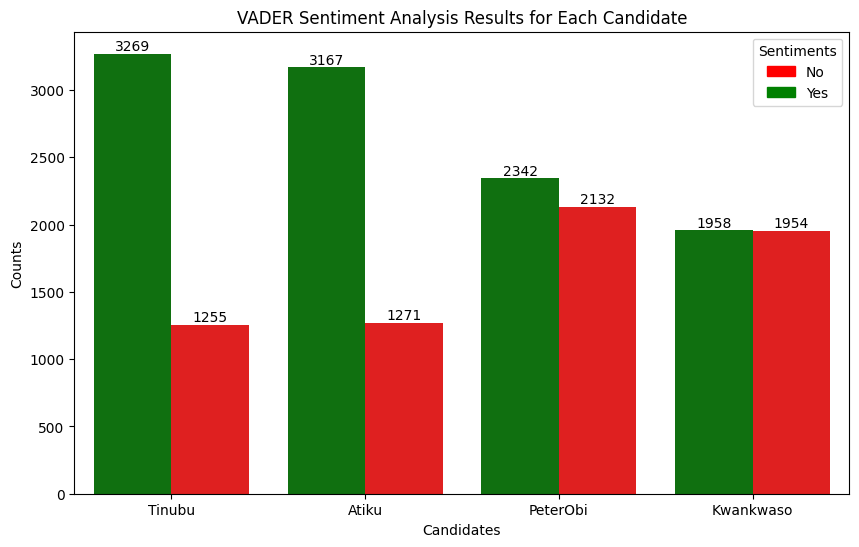

In [546]:
# plot the bar plot
plot_grouped_sentiment_analysis(df_6_to_8, 'candidate', 'VADER_Sentiment_labels', 'VADER')

# printing value counts
print('6 to 8 weeks to Elections')
df_6_to_8.groupby(['candidate', 'VADER_Sentiment_labels']).size()

### 2c. 4 to 6 Weeks to Elections

4 to 6 Weeks to Elections


candidate  VADER_Sentiment_labels
Atiku      No                        1197
           Yes                       3251
Kwankwaso  No                        2191
           Yes                       2269
PeterObi   No                        2059
           Yes                       2409
Tinubu     No                        1271
           Yes                       3216
dtype: int64

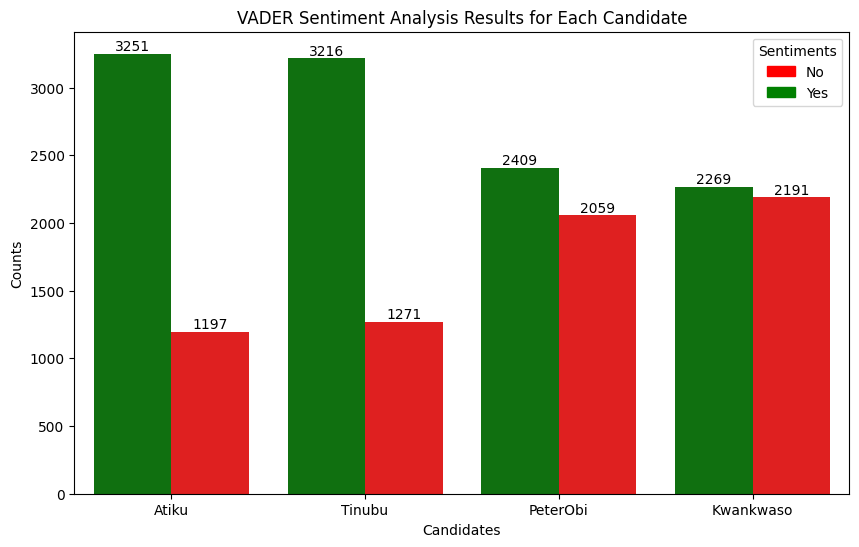

In [547]:
# plot the bar plot
plot_grouped_sentiment_analysis(df_4_to_6, 'candidate', 'VADER_Sentiment_labels', 'VADER')

# printing value counts
print('4 to 6 Weeks to Elections')
df_4_to_6.groupby(['candidate', 'VADER_Sentiment_labels']).size()

### 2d. 2 to 4 Weeks to Elections

2 to 4 Weeks to Elections


candidate  VADER_Sentiment_labels
Atiku      No                        1286
           Yes                       3178
Kwankwaso  No                        2420
           Yes                       2373
PeterObi   No                        2084
           Yes                       2352
Tinubu     No                        1097
           Yes                       3304
dtype: int64

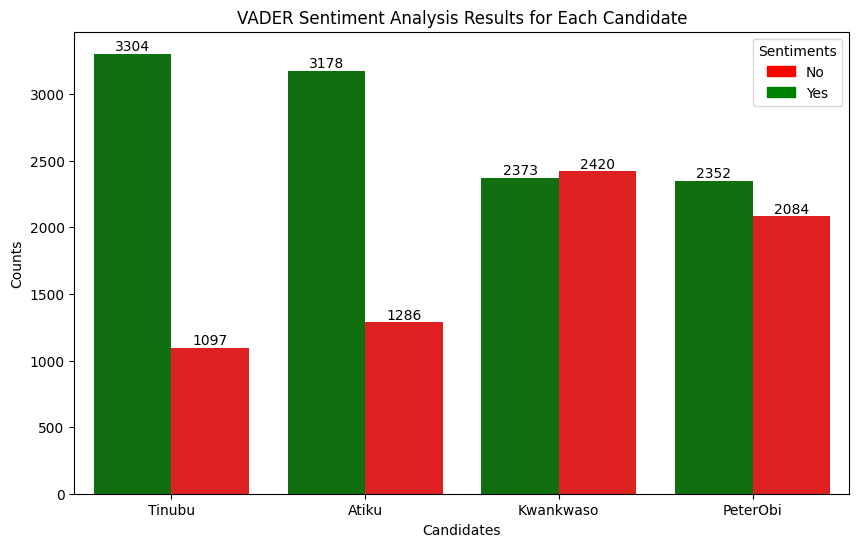

In [548]:
# plot the bar plot
plot_grouped_sentiment_analysis(df_2_to_4, 'candidate', 'VADER_Sentiment_labels', 'VADER')

# printing value counts
print('2 to 4 Weeks to Elections')
df_2_to_4.groupby(['candidate', 'VADER_Sentiment_labels']).size()

### 2e. Less than 2 Weeks to Elections

Less than 2 Weeks to Elections


candidate  VADER_Sentiment_labels
Atiku      No                         923
           Yes                       2482
Kwankwaso  No                        2009
           Yes                       2217
PeterObi   No                        1597
           Yes                       1745
Tinubu     No                         894
           Yes                       2416
dtype: int64

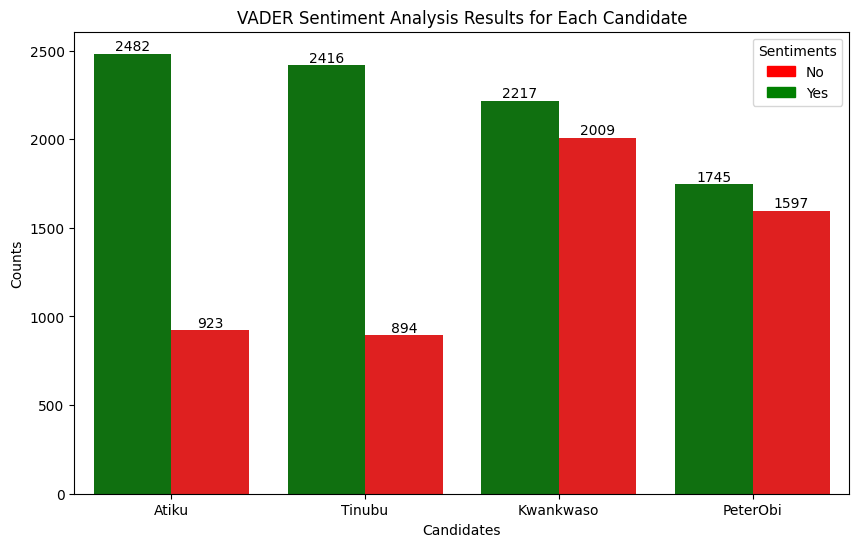

In [549]:
# plot the bar plot
plot_grouped_sentiment_analysis(df_less_than_2, 'candidate', 'VADER_Sentiment_labels', 'VADER')

# printing value counts
print('Less than 2 Weeks to Elections')
df_less_than_2.groupby(['candidate', 'VADER_Sentiment_labels']).size()

Based on the above plots and sentiment analysis results for different time intervals leading up to the elections, we can observe how the sentiment towards each candidate changed over time:

**Over 8 Weeks to Elections:**

* Tinubu: The sentiment was overwhelmingly positive ("Yes") with 2807 instances compared to 996 instances of negative sentiment ("No").
* Atiku: The sentiment was predominantly positive ("Yes") with 2672 instances compared to 1098 instances of negative sentiment ("No").
* Kwankwaso: The sentiment was balanced, with 1476 instances of positive sentiment ("Yes") and 1658 instances of negative sentiment ("No").
* PeterObi: The sentiment was slightly positive, with 1961 instances of positive sentiment ("Yes") and 1844 instances of negative sentiment ("No").

**6 to 8 Weeks to Elections:**

* Tinubu experienced a surge in positive sentiment with 3269 instances compared to 1255 instances of negative sentiment ("No").
* There was a significant increase in positive sentiment for Atiku with 3167 instances of positive sentiment ("Yes") compared to 1271 instances of negative sentiment ("No").
* PeterObi also remained balanced, with 2342 instances of positive sentiment ("Yes") and 2132 instances of negative sentiment ("No").
* Kwankwaso remained balanced, with 1958 instances of positive sentiment ("Yes") and 1954 instances of negative sentiment ("No").


**4 to 6 Weeks to Elections:**

* Atiku saw a slight decrease in positive sentiment with 3251 instances of positive sentiment ("Yes") and 1197 instances of negative sentiment ("No"), but got more positive tweets than Tinubu for the first time.
* Tinubu's positive sentiment decreased slightly with 3216 instances compared to 1271 instances of negative sentiment ("No").
* PeterObi experienced a similar pattern to Kwankwaso, with 2409 instances of positive sentiment ("Yes") and 2059 instances of negative sentiment ("No").
* Kwankwaso's sentiment remained relatively stable, with 2269 instances of positive sentiment ("Yes") and 2191 instances of negative sentiment ("No").


**2 to 4 Weeks to Elections:**

* Tinubu's positive sentiment increased significantly with 3304 instances compared to 1097 instances of negative sentiment ("No").
* Atiku's positive sentiment remained high with 3178 instances compared to 1286 instances of negative sentiment ("No").
* Kwankwaso experienced a decline in positive sentiment with 2373 instances compared to 2420 instances of negative sentiment ("No").
* PeterObi's sentiment was balanced, with 2352 instances of positive sentiment ("Yes") and 2084 instances of negative sentiment ("No").

**Less than 2 Weeks to Elections:**

* Atiku's positive sentiment remained high with 2482 instances compared to 923 instances of negative sentiment ("No"), but got more positive tweets than Tinubu, again.
* Tinubu's positive sentiment remained high with 2416 instances compared to 894 instances of negative sentiment ("No").
* Kwankwaso's sentiment was slightly positive, with 2217 instances of positive sentiment ("Yes") and 2009 instances of negative sentiment ("No").
* PeterObi experienced a similar pattern to Kwankwaso, with 1745 instances of positive sentiment ("Yes") and 1597 instances of negative sentiment ("No").

## 3. To what extent did the sentiment expressed on social media before and after the elections correspond to the official election results, and how did this reflect broader societal attitudes towards the political system?

### Performing Sentiment Analysis For Tweets After Elections

##### Loading Post-Elections Tweets Dataset

In [550]:
# Connect to the SQLite database file
conn = sqlite3.connect('Nigerian_Tweets_After_Elections_2023.sqlite')

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Retrieve the list of table names in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
tables = cursor.fetchall()

# Create a dictionary to store the dataframes
dataframes = {}

# Process each table (dataframe) individually
for table in tables:
    table_name = table[0]
    print("Dataframe:", table_name)

    # Execute a query to read data from the current table (dataframe)
    cursor.execute(f"SELECT * FROM {table_name}")

    # Fetch all the rows from the query result
    rows = cursor.fetchall()

    # Get the column names from the cursor description
    column_names = [desc[0] for desc in cursor.description]

    # Create a Pandas DataFrame from the query result with column names
    df = pd.DataFrame(rows, columns=column_names)

    # Assign the dataframe to the corresponding key in the dictionary
    dataframes[table_name.lower()] = df

# Access the dataframes using the variable names
APC = dataframes['apc']
Atiku = dataframes['atiku']
Kwankwaso = dataframes['kwankwaso']
LabourParty = dataframes['labourparty']
PDP = dataframes['pdp']
PeterObi = dataframes['peterobi']
Tinubu = dataframes['tinubu']
NNPP = dataframes['nnpp']

# Close the cursor and the connection
cursor.close()
conn.close()

Dataframe: APC
Dataframe: Atiku
Dataframe: Kwankwaso
Dataframe: LabourParty
Dataframe: PDP
Dataframe: PeterObi
Dataframe: Tinubu
Dataframe: NNPP


##### Concatenating Candidates Tweets With Their Partys' Tweets

In [551]:
# Concatenate the dataframes along the rows
# Atiku Abubaka and People’s Democratic Party (PDP)
atiku_pdp = pd.concat([Atiku, PDP]) 

# Bola Ahmed Tinubu and All Progressives Congress (APC)
tinubu_apc = pd.concat([Tinubu, APC]) 

# Peter Obi, and Labor Party (LP)
peterobi_lp = pd.concat([PeterObi, LabourParty]) 

# Rabiu Kwankwaso and NNP
kwankwaso = pd.concat([Kwankwaso, NNPP])

##### Adding Candidates Names for Each Dataset

In [552]:
def add_candidate_column(dataframe, candidate_name):
    """
    Adds a 'candidate' column to the dataframe with the specified candidate name for all rows.

    Args:
        dataframe (pd.DataFrame): Input dataframe to which the 'candidate' column will be added.
        candidate_name (str): Name of the candidate to be written in the 'candidate' column.

    Returns:
        pd.DataFrame: The modified dataframe with the 'candidate' column added.
    """
    dataframe['candidate'] = candidate_name
    return dataframe

# Calling the function on each of the dataframes
# Atiku Abubaka & People’s Democratic Party (PDP)
atiku_pdp = add_candidate_column(atiku_pdp, 'Atiku') 

# Bola Tinubu & All Progressives Congress (APC)
tinubu_apc = add_candidate_column(tinubu_apc, 'Tinubu') 

# Peter Obi, and Labor Party (LP)
peterobi_lp = add_candidate_column(peterobi_lp, 'PeterObi') 

# Rabiu Kwankwaso and NNPP
kwankwaso = add_candidate_column(kwankwaso, 'Kwankwaso') 

##### Combining the Datasets

In [553]:
# Concatenate the dataframes along the rows
after_elections_df = pd.concat([atiku_pdp, tinubu_apc, peterobi_lp, kwankwaso])

# Shuffle the data
after_elections_df = after_elections_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Reset the index of the resulting dataframe
after_elections_df = after_elections_df.reset_index(drop=True)

# overview of the data
after_elections_df.head(3)

,Timestamp,Username,Handle,Tweetcontent,Likescount,Retweetscount,candidate
0,2023-07-19 23:50:01+00:00,Johnpaul(Yekyzon),yekyzon,@PeterObi 001! Happy Birthday Sir!,0,0,PeterObi
1,2023-07-19 18:45:11+00:00,Uncle Sir’ad Sir’eed ⚖︎,Young__attorney,@AbbaM_Abiyos But the other person you are sup...,3,0,Kwankwaso
2,2023-07-19 22:22:03+00:00,dr ezebuiroh victor,ezebuvick,not muted as part of the solutions to d remova...,0,0,Tinubu


##### Preprocessing

In [554]:
# Renaming a column
after_elections_df.rename(columns={'Tweetcontent': 'Text'}, inplace=True)

# Dropping unneccessary Columns
after_elections_df = after_elections_df.drop(['Username', 'Handle', 'Likescount', 'Retweetscount'], axis=1)

# shape of the data before dropping duplicates
print('Before dropping duplicates:', len(after_elections_df)) 

 # Dropping duplicates 
after_elections_df.drop_duplicates(subset = "Text", inplace = True) #

# shape of the data after dropping duplicates
print('After dropping duplicates:', len(after_elections_df)) 

# define function to expand contractions
def expand_contractions(text):
    expanded_words = []
    for word in text.split():
        expanded_words.append(contractions.fix(word))
    return ' '.join(expanded_words)

after_elections_df['clean_Text'] = after_elections_df['Text'].apply(expand_contractions)

# Remove Stopwords
after_elections_df.clean_Text = after_elections_df.clean_Text.apply(remove_stopwords)

# Clean text 
def clean_text(text):
    text = re.sub(r'@[A-Z_a-z_0-9_]+', '', text)    
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r'#', '', text)     
    text = text.lower()
    return text

# calling the function
after_elections_df['clean_Text'] = after_elections_df['clean_Text'].apply(clean_text)

# Remove numbers
after_elections_df.clean_Text = after_elections_df.clean_Text.apply(strip_numeric)

# Remove Punctuation
after_elections_df.clean_Text = after_elections_df.clean_Text.apply(strip_punctuation)

#Remove Exra Spaces
def remove_extra_spaces(text):
    # replace multiple spaces with a single space
    text = " ".join(text.split())
    return text

# calling the function
after_elections_df['clean_Text'] = after_elections_df['clean_Text'].apply(remove_extra_spaces)

# Listing greetings and unimportant words 
words_to_remove = ['hello', 'hi', 'abeg', 'oga', 'go', 'brother', 'bro', 'dey', 'o']

def remove_words(df, column_name, words_to_remove):
    """
    Remove specified words from a column of a pandas DataFrame.
    """
    words = df[column_name].str.lower().str.split() # Convert to lowercase and split into words
    words = words.apply(lambda x: [word for word in x if word not in words_to_remove])
    cleaned_column = words.str.join(' ') # Combine words back into strings
    df[column_name] = cleaned_column # Replace original column with cleaned column in DataFrame
    return df

# calling the function
after_elections_df = remove_words(after_elections_df, 'clean_Text', words_to_remove)

# Create a new column with the number of words in the "Text" column
after_elections_df['Word_Count'] = after_elections_df['Text'].apply(lambda x: len(str(x).split()))
after_elections_df = after_elections_df[after_elections_df['Word_Count'] > 3 ]
print('After thorough cleaning:', len(after_elections_df))

Before dropping duplicates: 8183
After dropping duplicates: 7668
After thorough cleaning: 7602


##### Preprocess, Predict the Sentiments

Prediction Using Vader Model
233/233 [==============================] - 4s 17ms/step


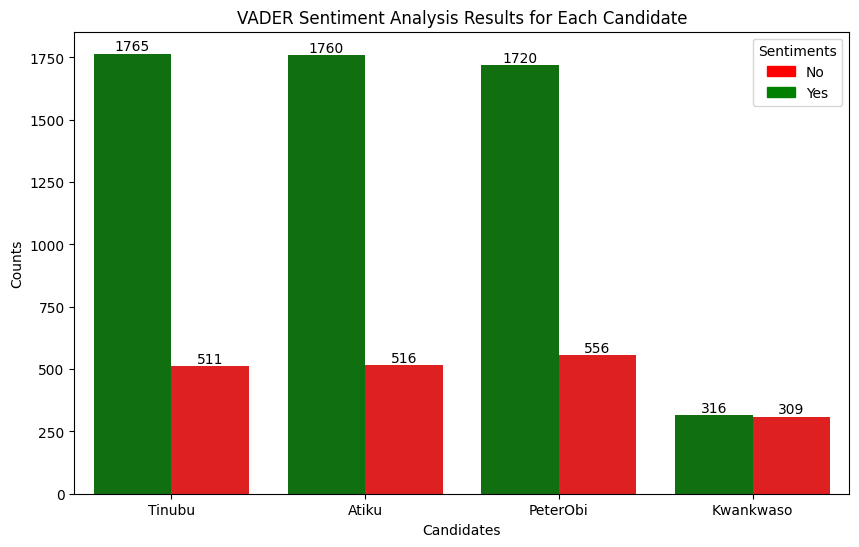

In [555]:
# drop nulls
after_elections_df2 = after_elections_df.dropna()

# drop kwankwaso first
without_kwankwaso = after_elections_df2[after_elections_df2['candidate'] != 'Kwankwaso']

# kwankwaso data
kwankwaso = after_elections_df2[after_elections_df2['candidate'] == 'Kwankwaso']                                 

# Filter without kwankwaso to include only same number of tweets as minimum tweet count for all candidates
without_kwankwaso = without_kwankwaso.groupby('candidate').head(2276)

# Concatenate the DataFrames vertically (along the rows)
concatenated_df = pd.concat([without_kwankwaso, kwankwaso])

# Reset the index of the resulting DataFrame
concatenated_df.reset_index(drop=True, inplace=True)

# Tockenizing data
final_pred_sequences_vader3 = tokenizer_vader.texts_to_sequences(concatenated_df['clean_Text'].values)
max_len = 29  # The maximum sequence length used during training
final_pred_sequences_padded_vader3 = pad_sequences(final_pred_sequences_vader3, maxlen=max_len)

# Predict the sentiment on the preprocessed data using the loaded LSTM model
print('Prediction Using Vader Model')
predictions_vader3 = model_lstm_vader.predict(final_pred_sequences_padded_vader3)

# Take the class with the highest probability as the predicted class (1 or 0)
binary_predictions_vader3 = np.argmax(predictions_vader3, axis=1)

# Add the binary predictions as a new column to the 'FINAL_PRED' DataFrame
concatenated_df['VaderSent_Pred'] = binary_predictions_vader3

# Define inverse mapping function to convert numerical labels to sentiment labels
inverse_sentiment_map = {1: 'Yes', 0: 'No'}

# apply mapping e-12qifunction to sentiment column - vader data
concatenated_df['VADER_Sentiment_labels'] = concatenated_df['VaderSent_Pred'].map(inverse_sentiment_map)

# drop column
concatenated_df.drop(['VaderSent_Pred'], axis=1, inplace=True)

# plot the bar plot
plot_grouped_sentiment_analysis(concatenated_df, 'candidate', 'VADER_Sentiment_labels', 'VADER')

The sentiment expressed on social media **before and after the elections** demonstrated a remarkable alignment with the official election results in terms of the candidates' positions. Tinubu consistently held the top position both on social media sentiment and in the official elections. 

### 4. How do sentiment analysis methods and tools, such as lexicon-based approaches or machine learning algorithms, perform in detecting and classifying sentiment in social media posts about the 2023 Nigerian Presidential election, and to what extent can sentiment analysis of social media be used as a reliable indicator of the accuracy of election results in Nigeria?

The Machine Learning lagorithms we used to predict sentiment on social media posts performed as follows:

* **Naive Bayes**

The accuracy of the Naive Bayes Model Using VADER: 43.23%

|    precision | recall | f1-score | support |
|-------------:|-------:|---------:|--------:|
| Negative     | 0.35   | 0.81     | 0.49    | 4845    |
| Positive     | 0.71   | 0.24     | 0.36    | 9433    |
| accuracy     | 0.43   |          |         | 14278   |
| macro avg    | 0.53   | 0.52     | 0.42    | 14278   |
| weighted avg | 0.59   | 0.43     | 0.40    | 14278   |


<br>
The accuracy of the Naive Bayes Model Using TextBlob: 45.75%

|    precision | recall | f1-score | support |
|-------------:|-------:|---------:|--------:|
| Negative     | 0.36   | 0.77     | 0.49    | 3434    |
| Positive     | 0.71   | 0.30     | 0.42    | 6672    |
| accuracy     | 0.46   |          |         | 10106   |
| macro avg    | 0.54   | 0.53     | 0.46    | 10106   |
| weighted avg | 0.59   | 0.46     | 0.44    | 10106   |




* **Random Forest:** 

Classification Report of the Random Forest Model on VADER dataset:

The accuracy of the Random Forest Model; VADER dataset: 83.06%



|    precision | recall | f1-score | support |
|-------------:|-------:|---------:|--------:|
| Negative     | 0.86   | 0.59     | 0.70    | 3833    |
| Positive     | 0.82   | 0.95     | 0.88    | 7590    |
| accuracy     | 0.83   |          |         | 11423   |
| macro avg    | 0.84   | 0.77     | 0.79    | 11423   |
| weighted avg | 0.83   | 0.83     | 0.82    | 11423   |


<br>
The accuracy of the Random Forest Model; TextBlob dataset: 89.87%

|    precision | recall | f1-score | support |
|-------------:|-------:|---------:|--------:|
| Negative     | 0.92   | 0.77     | 0.84    | 2749    |
| Positive     | 0.89   | 0.97     | 0.93    | 5336    |
| accuracy     | 0.90   |          |         | 8085    |
| macro avg    | 0.91   | 0.87     | 0.88    | 8085    |
| weighted avg | 0.90   | 0.90     | 0.90    | 8085    |


* **Support Vector Machine (SVM)**

<br>
The accuracy of the SVM Model; VADER dataset: 89.01%

|    precision | recall | f1-score | support |
|-------------:|-------:|---------:|--------:|
| Negative     | 0.86   | 0.81     | 0.83    | 3833    |
| Positive     | 0.90   | 0.93     | 0.92    | 7590    |
| accuracy     | 0.89   |          |         | 11423   |
| macro avg    | 0.88   | 0.87     | 0.87    | 11423   |
| weighted avg | 0.89   | 0.89     | 0.89    | 11423   |

<br>
The accuracy of the SVM Model; TextBlob dataset: 93.89%

|    precision | recall | f1-score | support |
|-------------:|-------:|---------:|--------:|
| Negative     | 0.93   | 0.89     | 0.91    | 2749    |
| Positive     | 0.94   | 0.96     | 0.95    | 5336    |
| accuracy     | 0.94   |          |         | 8085    |
| macro avg    | 0.94   | 0.93     | 0.93    | 8085    |
| weighted avg | 0.94   | 0.94     | 0.94    | 8085    |

<br>
<br>
Based on the results above, we can observe the performance of different sentiment analysis methods and tools, such as lexicon-based approaches (VADER and TextBlob) and machine learning algorithms (Random Forest, SVM, and Naive Bayes), in detecting and classifying sentiment in social media posts about the 2023 Nigerian Presidential election.

**Reliability of Sentiment Analysis for Election Results:**

The high accuracy and performance of SVM models using both VADER and TextBlob suggest that sentiment analysis can be a reliable indicator of public sentiment.

### Analysis of critical issues: 

Tweets will be analysed to identify the issues discussed before and after the election. This will enable an understanding of the factors influencing the sentiments towards the candidates.

To analyze the issues discussed in the tweets, we are going to conduct two analysis:
1. Content analysis (word clouds and word frequencies) and,
2. Topic Modeling using Latent Dirichlet Allocation (LDA)

### Content analysis (word clouds)

### Importing Additional Libraries

In [556]:
# Importing additional Libraries
from wordcloud import WordCloud

### Additional Preprocessing

In [570]:
# Remove greetings and unimportant words ###################################################
def remove_words(df, column_name, words_to_remove):
    """Remove specified words from a column of a pandas DataFrame.
    """
    words = df[column_name].str.lower().str.split() # Convert to lowercase and split into words
    words = words.apply(lambda x: [word for word in x if word not in words_to_remove])
    cleaned_column = words.str.join(' ') # Combine words back into strings
    df[column_name] = cleaned_column # Replace original column with cleaned column in DataFrame
    
    return df

words_to_remove = ['labour', 'party', 'nigeria', 'election', 'pdp', 'vote', 'presidential', 'nigerian', 
                   'apc', 'buhari', 'na', 'lago', 'political', 'president', "happy", "birthday", 
                   'i', 'the', 'you', 'like', 'he', 'this', 'it', 's']

# copy a slice of the dataframe
combined_df3 = combined_df2.copy()

# call the function to preprocess
combined_df3 = remove_words(combined_df3, 'clean_Text', words_to_remove)

### Word Cloud Before Elections

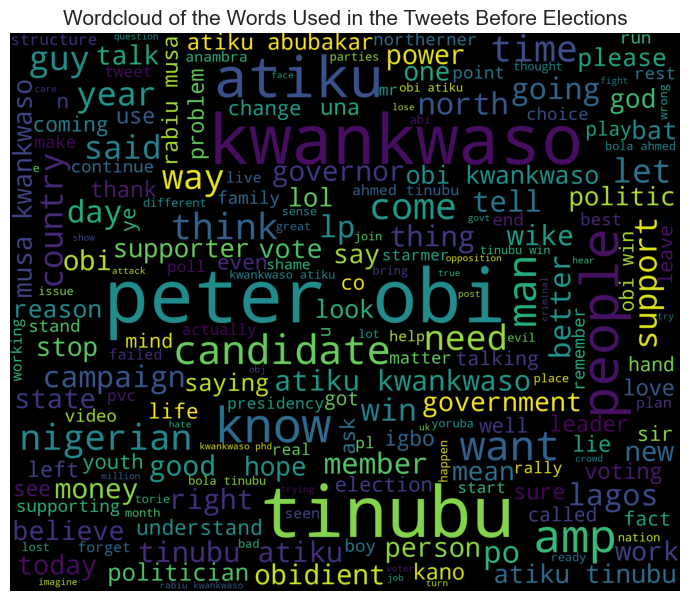

In [585]:
def plot_wordcloud(df, column, situation):
    string_Total = " ".join(df[column])

    #wordcloud for entire corpus
    fig = plt.figure(figsize = (7, 9))
    wordcloud_stw = WordCloud(
                    background_color= 'black',
                    width = 1800,
                    height = 1500, random_state = 10, max_font_size = 200
                    ).generate(string_Total)

    plt.imshow(wordcloud_stw)
    plt.title(f"Wordcloud of the Words Used in the Tweets {situation}", y=1.0, fontsize=15)
    plt.axis('off')

    plt.tight_layout()

    # plt.savefig('before_elections_wordcloud.png')
    
plot_wordcloud(combined_df3, 'clean_Text', 'Before Elections')

From the above wordloud of tweets before the elections, the presence of certain words like "supporting," "coming," "candidate," and "better", candidates names like "Kwankwaso", "Obi", "Tinubu", reflects the heightened anticipation and excitement among social media users as the election day draws near. People are actively expressing their support for their preferred candidates and engaging in discussions about the upcoming political event.

Additionally, the appearance of words like "problem," "politician," and "money" indicates that there are critical issues being discussed, and citizens are voicing their concerns about the challenges facing the country and the political landscape. It highlights the engagement of the public in conversations about policy matters and the expectations they have from the politicians they are considering supporting.

The word "people" suggests that the tweets are not just about individual candidates but also touch upon broader societal interests. Social media users are likely expressing their views about how the elected leaders can serve the interests and welfare of the general population.

Furthermore, the presence of words like "supporter" and "leader" indicates that social media discussions are not limited to candidate-centered conversations. Instead, people are also expressing their admiration for certain leaders and their potential impact on the political system.

### Word Cloud After Elections

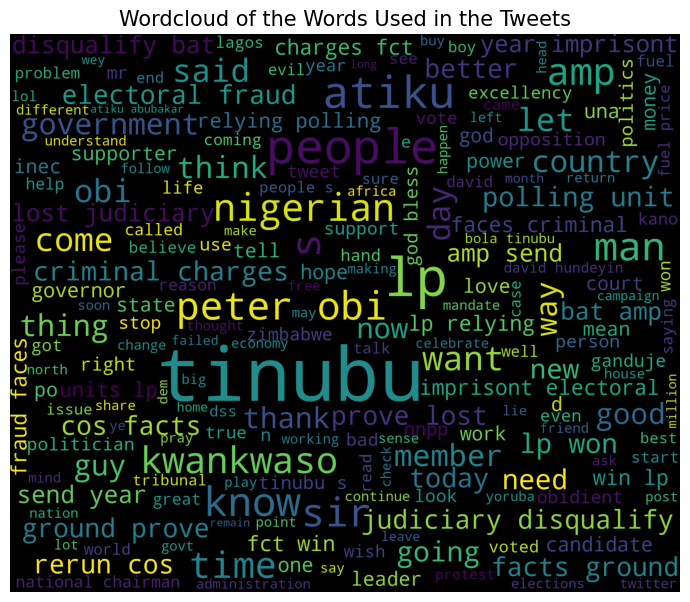

In [563]:
# copy a slice of the dataframe
concatenated_df2 = concatenated_df.copy()

# call the function to clean the data after elections further
concatenated_df2 = remove_words(concatenated_df2, 'clean_Text', words_to_remove)

plot_wordcloud(concatenated_df2, 'clean_Text', 'After Elections')

The presence of words like "charges," "electoral fraud," "criminal charges," "judiciary," "disqualify," "rerun," and "tribunal" in the word cloud of tweets after elections suggests that there is a significant discussion and public discourse surrounding legal and electoral issues related to the election process. These words indicate that people are expressing their opinions, concerns, and reactions to various legal aspects of the election, as well as instances of alleged fraud or malpractices.

Charges and Criminal Charges: The presence of these words suggests that there might be discussions about alleged criminal activities or accusations related to election irregularities or misconduct by candidates or party members. It indicates that there are ongoing debates and public scrutiny on potential legal actions against certain individuals or parties.

Electoral Fraud: The term "electoral fraud" indicates that people are discussing the possibility or occurrence of fraudulent activities during the election. This could involve various types of electoral malpractices, such as vote rigging, ballot tampering, or other unlawful actions to influence the election results.

Judiciary and Tribunal: The words "judiciary" and "tribunal" indicate that people are discussing legal aspects related to the election outcome and possible election disputes. This suggests that there might be legal challenges or cases brought before the judiciary or election tribunals to resolve election-related issues or disputes.

Disqualify and Rerun: The presence of these words suggests that there are discussions about disqualification of candidates or calls for a rerun of the election in certain constituencies. It indicates that there might be controversies or disagreements over the eligibility of certain candidates or the fairness of the election process in specific areas.

### Content analysis (word frequencies)

In [575]:
# installing additional libraries
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Word Frequencies Before Elections

In [574]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Assuming 'text_column' is the column containing the text
combined_df3['clean_Text'] = combined_df3['clean_Text'].apply(remove_stopwords)

# call the function to clean the data after elections further
combined_df3 = remove_words(combined_df3, 'clean_Text', words_to_remove)

# Word frequency 
freq_uncleaned = pd.Series(' '.join(combined_df3['clean_Text']).split()).value_counts()[:50] 
print(freq_uncleaned)

kwankwaso     22356
obi           18721
tinubu        18684
atiku         16163
peter         11530
people         7763
state          5524
candidate      5024
amp            5022
know           4667
man            4315
win            4101
’              4001
nigerians      3242
god            3239
north          3163
lagos          3065
come           3011
want           2990
campaign       2979
lp             2775
let            2729
time           2727
kano           2724
votes          2687
support        2679
said           2670
think          2525
good           2414
better         2352
country        2351
new            2318
way            2290
today          2188
nnpp           2185
years          1988
money          1977
right          1965
need           1939
going          1929
government     1910
governor       1837
south          1812
wike           1776
po             1710
power          1627
tell           1622
stop           1574
una            1559
voting         1541


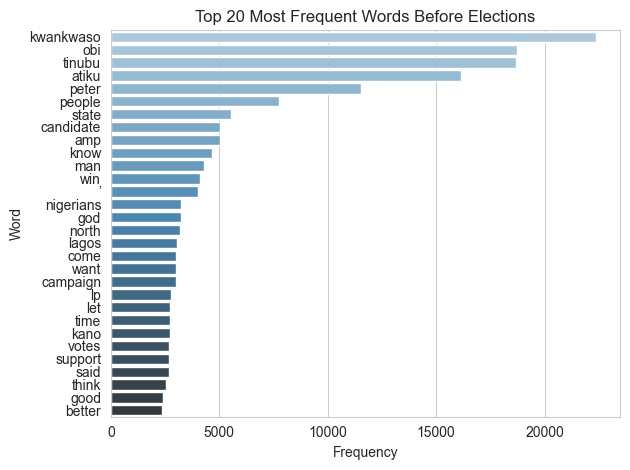

In [581]:
# Set the seaborn style to whitegrid
sns.set_style('whitegrid')

# Create a bar plot with the 30 most frequent words and their frequencies
sns.barplot(x=freq_uncleaned.head(30).values, y=freq_uncleaned.head(30).index, palette='Blues_d')

# Set the title and axis labels for the plot
plt.title('Top 20 Most Frequent Words Before Elections')
plt.xlabel('Frequency')
plt.ylabel('Word')

# Adjust the layout of the plot to make it more visually appealing
plt.tight_layout()

# Save the plot (commented out since it's not being used in this code)
# plt.savefig('word_frequency.png')

# Display the plot
plt.show()

The word frequencies for tweets before the elections indicate the prevalence of certain keywords and topics that were frequently discussed on social media during that period. 

### Word Frequencies After Elections

In [580]:
# Assuming 'text_column' is the column containing the text
concatenated_df2['clean_Text'] = concatenated_df2['clean_Text'].apply(remove_stopwords)

# call the function to clean the data after elections further
concatenated_df2 = remove_words(concatenated_df2, 'clean_Text', words_to_remove)

# Word frequency 
freq_uncleaned2 = pd.Series(' '.join(concatenated_df2['clean_Text']).split()).value_counts()[:50] 
print(freq_uncleaned2)

tinubu        1567
lp            1397
obi            613
people         578
amp            572
atiku          565
kwankwaso      439
sir            379
peter          350
man            343
’              325
state          315
god            308
know           306
nnpp           304
nigerians      291
fuel           266
good           248
new            241
n              241
win            237
time           234
let            220
government     217
lost           206
said           205
country        203
want           203
bat            203
year           201
judiciary      193
come           193
years          191
national       191
cos            189
criminal       188
today          187
candidate      181
send           178
way            175
🔴              172
think          171
leader         167
court          164
fct            163
thank          162
chairman       161
fraud          161
rerun          157
prove          156
dtype: int64


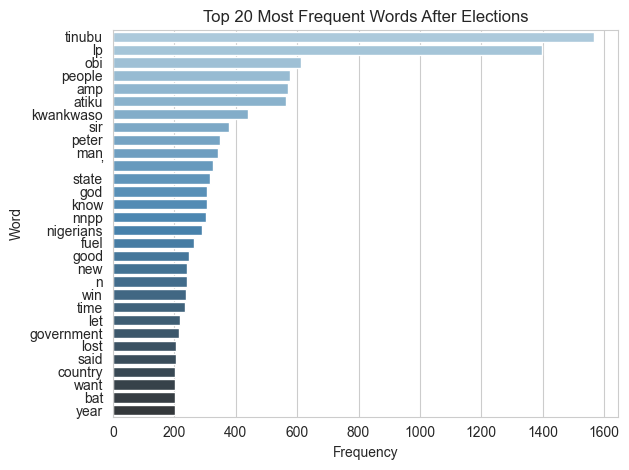

In [582]:
# Set the seaborn style to whitegrid
sns.set_style('whitegrid')

# Create a bar plot with the 30 most frequent words and their frequencies
sns.barplot(x=freq_uncleaned2.head(30).values, y=freq_uncleaned2.head(30).index, palette='Blues_d')

# Set the title and axis labels for the plot
plt.title('Top 20 Most Frequent Words After Elections')
plt.xlabel('Frequency')
plt.ylabel('Word')

# Adjust the layout of the plot to make it more visually appealing
plt.tight_layout()

# Save the plot (commented out since it's not being used in this code)
# plt.savefig('word_frequency.png')

# Display the plot
plt.show()

Based on the word frequencies in the tweets collected after the elections, we can identify several likely topics that are commonly discussed by users on social media. These topics provide insights into the subjects that garnered significant attention and engagement in the post-election period. Some of the likely topics are as follows:

Political Figures: Tweets are likely to discuss specific political figures and leaders such as "tinubu," "lp," "obi," "atiku," and "kwankwaso." Users may share their opinions, reactions, and updates related to these figures.

Government and Governance: The word "government" indicates that discussions are focused on the functioning and performance of the government post-election. Users may talk about policy decisions, governance issues, and the performance of elected officials.

Legal Matters: Words like "court," "judiciary," and "fraud" suggest that legal matters related to the election might be a significant topic of discussion. Users could be sharing information or expressing opinions about election-related court cases, fraud allegations, or tribunal rulings.

Election Rerun and Protests: The term "rerun" indicates the possibility of discussions around election reruns or disputed results in certain regions. Users may be discussing the impact of reruns on the election outcome and any associated protests or reactions.

Political Affiliation: The presence of names like "atiku" and "kwankwaso" along with party acronyms like "nnpp" indicates discussions about the political affiliations and support for specific candidates and parties.

Social Issues: Some tweets might touch upon social issues, such as "people," "man," and "nigerians," reflecting broader discussions about the welfare and concerns of citizens.

Expressions of Opinions: Words like "think," "want," and "prove" suggest users are likely expressing their opinions, desires, or expectations post-election.

Thanksgiving and Appreciation: The word "thank" could indicate expressions of gratitude or appreciation for various reasons related to the election.

Location-specific Topics: Words like "lagos," "kano," and "fct" indicate discussions about specific regions, indicating that regional or local issues might also be a prominent topic of interest.

### Topic Modeling using Latent Dirichlet Allocation (LDA)

### Importing the relevant libraries

In [595]:
import spacy
import pyLDAvis.gensim_models
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

In [596]:
#Load the English model
!python -m spacy download en_core_web_md -qq

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


### Removing stopwords and tokenizing the messages column

In [644]:
def add_tokens_to_dataframe(df, text_column, tokens_column):
    """
    Adds a new column of tokens (lemmatized, lowercase, and without stopwords) to the DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the text data.
    - text_column (str): The name of the column containing the text data.
    - tokens_column (str): The name of the new column to store the tokens.

    Description:
    'add_tokens_to_dataframe' function takes a DataFrame, a text column, and a tokens column name 
    as input and adds a new column to DataFrame containing the tokens extracted from the text data.
    The tokens are lemmatized, converted to lowercase, and stopwords are removed.

    Example usage:
    >>> import spacy
    >>> nlp_en = spacy.load('en_core_web_sm')
    >>> add_tokens_to_dataframe(nospam_df, 'raw_content_en', 'tokens')
    """
    # Load the spaCy English model for tokenization and lemmatization
    nlp_en = spacy.load('en_core_web_md')

    # Tags I want to remove from the text
    removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

    # Initialize an empty list to store tokens for each text in the DataFrame
    tokens = []

    # Process each text in the specified column and extract tokens
    for text in nlp_en.pipe(df[text_column]):
        # Extract lemmatized, lowercase, and non-stopword tokens for each text
        proj_tok = [token.lemma_.lower() for token in text if token.pos_ not in removal 
                    and not token.is_stop and token.is_alpha]

        # Append the tokens to the list
        tokens.append(proj_tok)

    # Add the 'tokens' column to the DataFrame
    df[tokens_column] = tokens

# Tweets Before Elections
combined_df3['tokens'] = add_tokens_to_dataframe(combined_df3, 'clean_Text', 'Tokens')
    
# Tweets after elections
concatenated_df2['tokens'] = add_tokens_to_dataframe(concatenated_df2, 'clean_Text', 'Tokens')

7453


### Creating a Bog of Words

This code is used to create a document-term matrix from a collection of texts. 

In [682]:
# print the shape of the data after elections
print('After elections:',concatenated_df2.shape[0])

After elections: 7453


In [683]:
# We will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
# before elections
combined_df4 = combined_df3.sample(n=7453, random_state=42)
dictionary1 = Dictionary(combined_df4['Tokens'])

# After elections
concatenated_df3 = concatenated_df2.sample(n=7453, random_state=42)
dictionary2 = Dictionary(concatenated_df3['Tokens'])

### Creating Corpus

In [684]:
# tweets before elections
corpus1 = [dictionary1.doc2bow(doc) for doc in combined_df4['Tokens']]
print('len of Corpus 1:', len(corpus1), 'rows')

# Tweets after elections
corpus2 = [dictionary2.doc2bow(doc) for doc in concatenated_df3['Tokens']]
print('len of Corpus 2:', len(corpus2), 'rows')

len of Corpus 1: 7453 rows
len of Corpus 2: 7453 rows


### LDA Model building

The next step is to train the unsupervised machine learning model on the data. We chose to work with the LdaMulticore, which uses all CPU cores to parallelize and speed up model training.

In [696]:
# Before Elections
lda_model_b4_elections = LdaMulticore(corpus=corpus1, 
                         id2word=dictionary1, 
                         iterations=10, 
                         num_topics=15, 
                         workers = 2, 
                         passes=10)

In [697]:
# After Elections
lda_model_after_elections = LdaMulticore(corpus=corpus2, 
                         id2word=dictionary2, 
                         iterations=10, 
                         num_topics=15, 
                         workers = 2, 
                         passes=10)

### Showing the 10 Topics and the Related Words

This code is used to print out the topics that were generated by the Latent Dirichlet Allocation (LDA) model. It takes in one argument - the number of topics to print out. If the argument is not specified, it will print out all the topics. The code then iterates through the topics and prints out the top words for each topic.

### Before Elections

In [698]:
lda_model_b4_elections.print_topics(-1)

[(0,
  '0.037*"kwankwaso" + 0.033*"state" + 0.013*"tinubu" + 0.013*"governor" + 0.013*"obi" + 0.012*"man" + 0.010*"kano" + 0.008*"atiku" + 0.008*"need" + 0.007*"people"'),
 (1,
  '0.025*"lp" + 0.022*"come" + 0.015*"kwankwaso" + 0.012*"atiku" + 0.009*"tinubu" + 0.009*"good" + 0.009*"people" + 0.008*"go" + 0.007*"know" + 0.007*"state"'),
 (2,
  '0.023*"candidate" + 0.021*"tinubu" + 0.011*"people" + 0.011*"atiku" + 0.011*"say" + 0.010*"come" + 0.008*"naira" + 0.007*"amp" + 0.007*"man" + 0.007*"youth"'),
 (3,
  '0.016*"kwankwaso" + 0.013*"member" + 0.011*"tinubu" + 0.010*"love" + 0.008*"governor" + 0.007*"atiku" + 0.006*"corbyn" + 0.006*"starmer" + 0.006*"man" + 0.006*"school"'),
 (4,
  '0.052*"tinubu" + 0.029*"obi" + 0.020*"peter" + 0.014*"south" + 0.014*"know" + 0.013*"atiku" + 0.011*"people" + 0.010*"wike" + 0.010*"kwankwaso" + 0.008*"north"'),
 (5,
  '0.020*"kwankwaso" + 0.019*"amp" + 0.016*"tinubu" + 0.014*"people" + 0.014*"atiku" + 0.007*"candidate" + 0.007*"man" + 0.007*"country" + 

The topics extracted from the tweets before elections by the LDA model are represented by the tuples. Each tuple consists of a topic number and the top words that are most relevant to that particular topic, along with their corresponding probabilities.

* **Topic 0:**

Words: kwankwaso, state, tinubu, governor, obi, man, kano, atiku, need, people
This topic may be discussing political figures like "kwankwaso" and "tinubu," along with mentions of "state" and "governor."

* **Topic 1:**

Words: lp, come, kwankwaso, atiku, tinubu, good, people, go, know, state
This topic might be discussing "kwankwaso" and "atiku," and the use of "lp" and "come" in the context of political events.

* **Topic 2:**

Words: candidate, tinubu, people, atiku, say, come, naira, amp, man, youth
This topic seems to involve discussions about political candidates, including "tinubu" and "atiku."

* **Topic 3:**

Words: kwankwaso, member, tinubu, love, governor, atiku, corbyn, starmer, man, school
This topic may be discussing political figures like "kwankwaso" and "tinubu," possibly in relation to "governor" and "school."

* **Topic 4:**

Words: tinubu, obi, peter, south, know, atiku, people, wike, kwankwaso, north
This topic might discuss the political figures "tinubu," "obi," and "peter," possibly in relation to specific regions like "south" and "north."

* **Topic 5:**

Words: kwankwaso, amp, tinubu, people, atiku, candidate, man, country, money, government
This topic seems to involve discussions about political figures like "kwankwaso" and "tinubu," possibly in the context of their impact on the "country" and "government."

* **Topic 6:**

Words: state, kwankwaso, candidate, river, atiku, work, kano, campaign, tinubu, obi
This topic may be discussing political candidates and their activities, including "kwankwaso" and "atiku."

* **Topic 7:**

Words: kwankwaso, vote, candidate, know, say, take, think, gt, people, let
This topic might involve discussions about voting, political candidates, and public opinions.

* **Topic 8:**

Words: kwankwaso, allah, atiku, muslim, guy, obi, crowd, rabiu, northern, speak
This topic may discuss religious aspects, including "allah," "muslim," and "crowd," possibly in relation to political figures.

* **Topic 9:**

Words: tinubu, amen, campaign, nah, people, amp, yrs, nigerian, talk, lie
This topic seems to involve discussions about "tinubu" and "campaign," possibly with mentions of the "nigerian" context.

* **Topic 10:**

Words: obi, peter, kwankwaso, god, atiku, people, support, come, tell, amp
This topic might be discussing "obi" and "peter" in the context of political support and actions.

* **Topic 11:**

Words: atiku, tinubu, know, kwankwaso, court, lp, agent, come, shame, today
This topic seems to involve discussions about "atiku," "tinubu," and "court," possibly in relation to legal matters conerning elections.

* **Topic 12:**

Words: kwankwaso, atiku, tinubu, support, right, answer, yes, question, go, man
This topic might be discussing political support and asking questions to "kwankwaso" and "atiku."

* **Topic 13:**

Words: atiku, obi, kwankwaso, peter, tinubu, bat, una, play, po, think
This topic may discuss the actions of political figures like "atiku," "obi," and "tinubu" and their impact on the public.

* **Topic 14:**

Words: win, kwankwaso, kano, tinubu, year, atiku, nnpp, rabiu, candidate, musa
This topic might discuss winning and political figures like "kwankwaso" and "atiku" in relation to specific regions like "kano."

Generally, tweets before elections were discussing the candidates, and people were extending support to their preferred presidential candidates. The discussions revolved around politics, governance and elections.

### After Elections

In [699]:
lda_model_after_elections.print_topics(-1)

[(0,
  '0.021*"tinubu" + 0.014*"lp" + 0.007*"alliance" + 0.006*"think" + 0.006*"nc" + 0.006*"lead" + 0.006*"party" + 0.006*"mean" + 0.005*"anti" + 0.005*"dynasty"'),
 (1,
  '0.025*"lp" + 0.017*"amp" + 0.010*"gt" + 0.009*"tax" + 0.007*"look" + 0.007*"buy" + 0.007*"people" + 0.006*"play" + 0.005*"influencer" + 0.005*"pay"'),
 (2,
  '0.025*"lp" + 0.012*"come" + 0.010*"people" + 0.009*"tribunal" + 0.009*"new" + 0.008*"witness" + 0.007*"need" + 0.007*"e" + 0.007*"nnpp" + 0.006*"fail"'),
 (3,
  '0.019*"lp" + 0.011*"tinubu" + 0.010*"people" + 0.009*"burn" + 0.009*"cap" + 0.008*"market" + 0.008*"stake" + 0.008*"democracy" + 0.008*"rise" + 0.008*"k"'),
 (4,
  '0.063*"lp" + 0.035*"year" + 0.033*"amp" + 0.030*"send" + 0.030*"lose" + 0.029*"criminal" + 0.029*"win" + 0.028*"face" + 0.028*"bat" + 0.027*"fact"'),
 (5,
  '0.038*"tinubu" + 0.018*"fuel" + 0.018*"n" + 0.014*"government" + 0.011*"price" + 0.011*"lp" + 0.011*"people" + 0.009*"economy" + 0.009*"litre" + 0.008*"follow"'),
 (6,
  '0.074*"sir"

The topics extracted from the tweets after elections by the LDA model are represented by the tuples. Each tuple consists of a topic number and the top words that are most relevant to that particular topic, along with their corresponding probabilities.

* **Topic 0:**

Words: tinubu, lp, alliance, think, nc, lead, party, mean, anti, dynasty
This topic may involve discussions about political figures like "tinubu" and "lp," possibly in relation to political alliances and opinions.

* **Topic 1:**

Words: lp, amp, gt, tax, look, buy, people, play, influencer, pay
This topic might involve discussions about "lp" and "amp," possibly related to economic matters like "tax" and "buy."

* **Topic 2:**

Words: lp, come, people, tribunal, new, witness, need, e, nnpp, fail
This topic seems to involve discussions about "lp" and "come," possibly in relation to legal matters like "tribunal" and "witness."

* **Topic 3:**

Words: lp, tinubu, people, burn, cap, market, stake, democracy, rise, k
This topic may discuss "lp" and "tinubu," possibly in relation to economic and political discussions like "democracy."

* **Topic 4:**

Words: lp, year, amp, send, lose, criminal, win, face, bat, fact
This topic might involve discussions about "lp" and the use of "amp," possibly in the context of election outcomes and criminal issues.

* **Topic 5:**

Words: tinubu, fuel, n, government, price, lp, people, economy, litre, follow
This topic seems to involve discussions about "tinubu," "fuel," and "government," possibly in relation to economic issues like "price."

* **Topic 6:**

Words: sir, love, thank, man, people, good, say, respect, lp, know
This topic may discuss expressions of appreciation like "sir" and "thank," along with general sentiments about "people" and "love."

* **Topic 7:**

Words: lp, tinubu, vote, candidate, fake, get, ipob, people, insult, nice
This topic might involve discussions about voting and political candidates, possibly with mentions of "tinubu."

 **Topic 8:**

Words: tinubu, atiku, obi, amp, lp, court, po, people, inec, case
This topic seems to involve discussions about political figures like "tinubu," "atiku," and "obi," possibly in the context of legal matters.

* **Topic 9:**

Words: fuel, lp, tinubu, subsidy, una, price, remove, buy, nigerian, say
This topic might discuss "fuel" and its implications, possibly with mentions of "tinubu" and "nigerian" context.

* **Topic 10:**

Words: kwankwaso, state, national, nnpp, governor, chairman, ganduje, lp, kano, tinubu
This topic may be discussing political figures like "kwankwaso" and "governor," possibly in the context of state and national matters.

* **Topic 11:**

Words: excellency, people, state, amp, gov, tinubu, lp, god, time, thank
This topic seems to involve expressions of respect like "excellency" and "thank," possibly in relation to political figures.

* **Topic 12:**

Words: tinubu, god, join, teach, member, lp, bless, tweet, launch, child
This topic might discuss religious aspects like "god" and expressions of blessings and teachings.

* **Topic 13:**

Words: david, tinubu, god, bless, zimbabwe, dss, country, hundeyin, nysc, nnamdi
This topic seems to involve various topics like "zimbabwe," "country," and possibly news and events.

* **Topic 14:**

Words: obi, atiku, peter, vote, man, tinubu, know, kwankwaso, wish, good
This topic may discuss political figures like "obi" and "atiku," possibly in relation to election results and opinions.

In general, comparing the discussions before and after elections based on the topics generated by the LDA models reveals some interesting insights:

The discussions before elections primarily revolved around specific political figures, campaigns, and general political issues. However, after the elections, the focus seems to broaden, encompassing discussions on various topics like economics, governance, legal matters, and religious sentiments, in addition to political figures and party-related discussions. The shift in topics suggests that after the elections, people are discussing a more diverse range of subjects, reflecting the changing political and social landscape in the aftermath of the voting process.